In [1]:
%matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau
import Utility
import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj, load_ply
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes_as_batch
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    BlendParams,
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))

print(torch.version.cuda)
from datetime import datetime

SMPLSH_Dir = r'..\SMPL_reimp'

import sys
sys.path.insert(0, SMPLSH_Dir)
import smplsh_torch

from os.path import join
import pyvista as pv
import Logger

import copy

10.1


In [3]:
import importlib
importlib.reload(Utility)
from Utility import *

In [4]:
class RenderingCfg:
    def __init__(s):
        s.sigma = 1e-4
        s.blurRange = 1e-4
        s.faces_per_pixel = 50
        s.bodyJointOnly = False
        s.randSeedPerturb = 1234
        s.noiseLevel = 0.5
        s.numIterations = 2000
        s.learningRate = 0.005
        s.terminateLoss = 200
        s.plotStep = 10
        s.numCams = 16
        s.imgSize = 2160
        
        s.biLaplacian = False
        s.lpSmootherW = 0.0001
        s.normalSmootherW = 0.1
        
        s.vertexFixingWeight = 100

        
class Renderer:
    def __init__(s, cfg = RenderingCfg):
        s.cfg = cfg
        # blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
        s.blend_params = BlendParams(sigma=cfg.sigma, gamma=1e-4)

        # Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
        # -z direction. 
        s.lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
#         cameras = OpenGLPerspectiveCameras(device=device)
        # Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
        # interpolate the texture uv coordinates for each vertex, sample from a texture image and 
        # apply the Phong lighting model
        
        if cfg.blurRange!= 0:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= np.log(1. / cfg.blurRange - 1.) * s.blend_params.sigma, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
        else:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= 0, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
            
        s.rasterizer=MeshRasterizer(
                cameras=None, 
                raster_settings=s.raster_settings
            )
        if cfg.blurRange!= 0:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
            #     shader=SoftPhongShader(
            #         device=device, 
            #         cameras=cameras,
            #         lights=lights,
            #         blend_params=blend_params
            #     )
                shader=SoftSilhouetteShader(
                    blend_params=s.blend_params
                    # device=device, 
                    # cameras=cameras,
                    # lights=lights
                )
            )
        else:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
            #     shader=SoftPhongShader(
            #         device=device, 
            #         cameras=cameras,
            #         lights=lights,
            #         blend_params=blend_params
            #     )
                shader=SoftSilhouetteShader(
                    blend_params=s.blend_params
                    # device=device, 
                    # cameras=cameras,
                    # lights=lights
                )
            )

In [5]:
cfg = RenderingCfg()
# cfg.sigma = 1e-3
cfg.noiseLevel = 0.1
# cfg.blurRange = 1e-1
# cfg.sigma = 1e-4
# cfg.sigma = 1e-5

# cfg.blurRange = 1e-4

# cfg.sigma = 1e-6
# cfg.blurRange = 1e-5

cfg.sigma = 1e-7
cfg.blurRange = 1e-7

# cfg.plotStep = 20
cfg.plotStep = 5

cfg.numCams = 16
# cfg.learningRate = 1
# cfg.learningRate = 0.1
# cfg.learningRate = 1
# cfg.learningRate = 0.1
cfg.learningRate = 0.4


cfg.normalShiftLevel = 10
# cfg.faces_per_pixel = 14
# cfg.faces_per_pixel = 30
cfg.faces_per_pixel = 15

# cfg.imgSize = 2160   
cfg.imgSize = 1080
device = torch.device("cuda:0")
cfg.terminateLoss = 0.1

cfg.lpSmootherW = 0.0001
# cfg.normalSmootherW = 0.1
cfg.normalSmootherW = 1


renderSynth = Renderer(cfg)

cfgRef = RenderingCfg()
cfgRef.faces_per_pixel = 1
cfgRef.blurRange = 0
cfgRef.sigma = 0
cfgRef.imgSize = 1080
renderRef = Renderer(cfgRef)

In [6]:
camParamF = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\CameraParams\cam_params.json'
imageFolder =  r'F:\WorkingCopy2\2020_06_04_SilhouetteExtraction\3052\Silhouette'
# modelFile = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Output\RealData\SilhouettePoseFitting_Sig1e-07_BR1e-07_Fpp5_NCams16_ImS1080_LR0.002\FinalMesh.obj'
modelFile = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Output\RealDataPose\SilhouettePoseFitting_Sig1e-07_BR1e-07_Fpp5_NCams16_ImS1080_LR0.002_JR1e-06\FinalMesh.obj'

outFolder = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Output\RealDataSilhouette'
smplshExampleMeshFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSH\SMPLSH.obj'

In [7]:
handIndicesFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\HandIndices.json'
HeadIndicesFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\HeadIndices.json'

handIndices = json.load(open(handIndicesFile))
headIndices = json.load(open(HeadIndicesFile))

indicesToFix = copy.copy(handIndices)
indicesToFix.extend(headIndices)

In [8]:
LNP = getLaplacian(smplshExampleMeshFile)

BiLNP = LNP @ LNP
if cfg.biLaplacian:
    LNP = torch.tensor(BiLNP,  dtype=torch.float32, device=device, requires_grad=False)
else:
    LNP = torch.tensor(LNP,  dtype=torch.float32, device=device, requires_grad=False)

In [9]:
# load Images
image_refs_out, crops_out = load_images(imageFolder, cropSize=cfg.imgSize)

actual_img_shape = (2160, 4000)
cam_params, cams_torch = load_cameras(camParamF, device, actual_img_shape)
print(len(cam_params), ':', cam_params[0].keys())
print(cams_torch.keys())

smplshExampleMesh = pv.PolyData(smplshExampleMeshFile)

actual_img_shape: (2160, 4000)
16 : dict_keys(['K', 'dist', 'R', 'T', 'fx', 'fy', 'cx', 'cy'])
dict_keys(['R', 'T', 'fl', 'pp'])


In [10]:
cams = init_camera_batches(cams_torch, device)

In [11]:
verts, faces, aux = load_obj(modelFile)
verts = verts.to(device)
faces_idx = faces.verts_idx.to(device)

nVerts = verts.shape[0]

C:\Users\Anka\.conda\envs\pytorch3d\lib\site-packages\pytorch3d-0.2.0-py3.6-win-amd64.egg\pytorch3d\io\obj_io.py:70: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


In [12]:
nNormals = normalizeNormals(aux.normals).to(device)

torch.Size([6750])


In [13]:
# normalShift = torch.tensor(np.full((nVerts,1), 0), dtype=torch.float32, requires_grad = True, device=device)

xyzShift = torch.tensor(np.full((nVerts,3), 0), dtype=torch.float32, requires_grad = True, device=device)

In [14]:
xyzShift.shape

torch.Size([6750, 3])

In [15]:
# modifiedVerts = verts + normalShift * nNormals

modifiedVerts = verts + xyzShift
mesh = Meshes(
                verts=[modifiedVerts.to(device)],   
                faces=[faces_idx.to(device)], 
#                 textures=textures.to(device)
            )

In [16]:
modifiedVerts.requires_grad

True

In [17]:
expName = 'XYZ_HHFix_Sig_' + str(cfg.sigma) + '_BR' + str(cfg.blurRange) + '_Fpp' + str(cfg.faces_per_pixel) \
+ '_NCams' + str(cfg.numCams)+ 'ImS' + str(cfg.imgSize) + "_LR" + str(cfg.learningRate) + "_LW" + str(cfg.lpSmootherW) + "_NW" + str(cfg.normalSmootherW)

outFolderForExperiment = join(outFolder, expName)
os.makedirs(outFolderForExperiment, exist_ok=True)
print(outFolderForExperiment)

json.dump({"CfgSynth":cfg.__dict__, "CfgRef":cfgRef.__dict__,}, open(join(outFolderForExperiment, 'cfg.json'), 'w'), indent=2)

outFolderMesh = join(outFolderForExperiment, 'Mesh')
os.makedirs(outFolderMesh, exist_ok=True)

F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Output\RealDataSilhouette\XYZ_HHFix_Sig_1e-07_BR1e-07_Fpp15_NCams16ImS1080_LR0.4_LW0.0001_NW1


In [18]:
def visualize2DResults(images, backGroundImages=None, outImgFile=None, rows = 2, pytorch3DImg=True, sizeInInches = 2):
    lossVal = 0
    numCams = len(images)
    numCols = int(numCams / rows)
    fig, axs = plt.subplots(rows, numCols)
    fig.set_size_inches(numCols*sizeInInches, rows*sizeInInches)
    with torch.no_grad():
        for iRow in range(rows):
            for iCol in range(numCols):
                iCam = rows* iRow + iCol
                if pytorch3DImg:
                    imgAlpha = images[iCam][0,...,3]
                else:
                    imgAlpha = images[iCam]
                    
                if backGroundImages is not None:
                    img = np.copy(backGroundImages[iCam])
#                     fgMask = np.logical_not(np.where())
                    for iChannel in range(3):
                        img[..., iChannel] = np.where(imgAlpha, imgAlpha, backGroundImages[iCam][...,iChannel])
                    imgAlpha = img
                    
                imgAlpha = cv2.flip(imgAlpha, -1)
                
                axs[iRow, iCol].imshow(imgAlpha, vmin=0.0, vmax=1.0)
                axs[iRow, iCol].axis('off')

        if outImgFile is not None:
            fig.savefig(outImgFile, dpi=512, transparent=True, bbox_inches='tight', pad_inches=0)

<IPython.core.display.Javascript object>


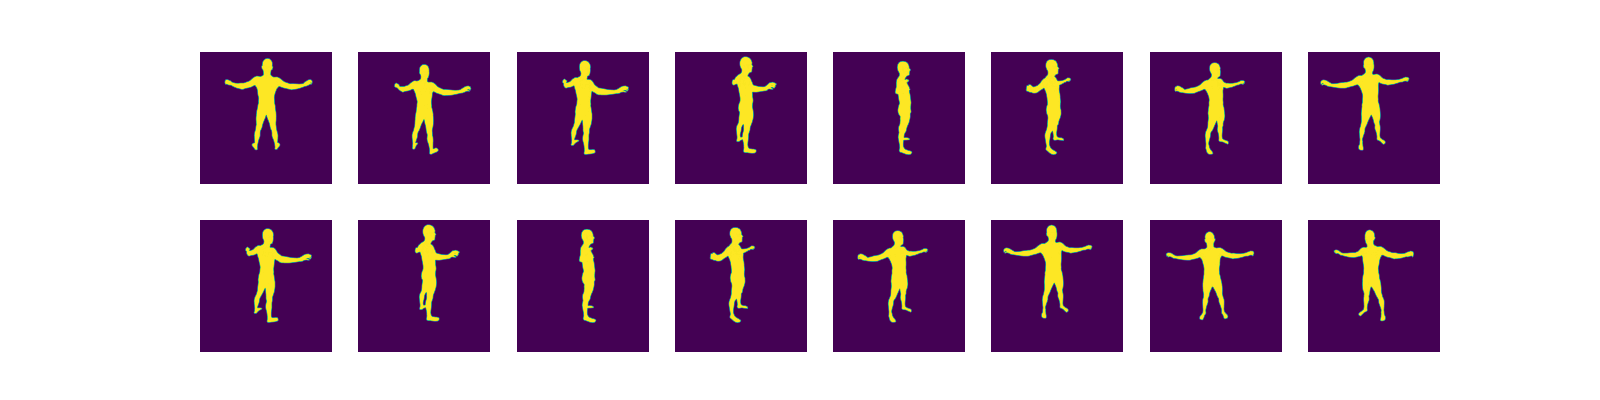

Before release: active_bytes.all.current: 203.15648 MB
After release: active_bytes.all.current: 203.15648 MB


In [19]:
images = []
with torch.no_grad():
    for iCam in range(len(cams)):
        image_cur = renderSynth.renderer(mesh,  cameras=cams[iCam])
        images.append(image_cur.cpu().detach().numpy())
visualize2DResults(images)
showCudaMemUsage(device)

In [20]:
diffImages = []
imagesRef = []

loss = 0
for iCam in range(len(cams)):
    imagesRef.append(crops_out[iCam][...,0])
    imgDiff = np.abs(images[iCam][0, ..., 3] - imagesRef[iCam])
    diffImages.append(imgDiff)
    
    loss += 1 -np.sum(np.abs(images[iCam][..., 3] * imagesRef[iCam][..., 3])) / np.sum(np.abs(imagesRef[iCam][..., 3] + images[iCam][..., 3] - imagesRef[iCam][..., 3] * images[iCam][..., 3]))

In [21]:
print("mesh_laplacian_smoothing", mesh_laplacian_smoothing(mesh))
print("mesh_normal_consistency", mesh_normal_consistency(mesh))

mesh_laplacian_smoothing tensor(2.5945, device='cuda:0')
mesh_normal_consistency tensor(0.0464, device='cuda:0')


<IPython.core.display.Javascript object>


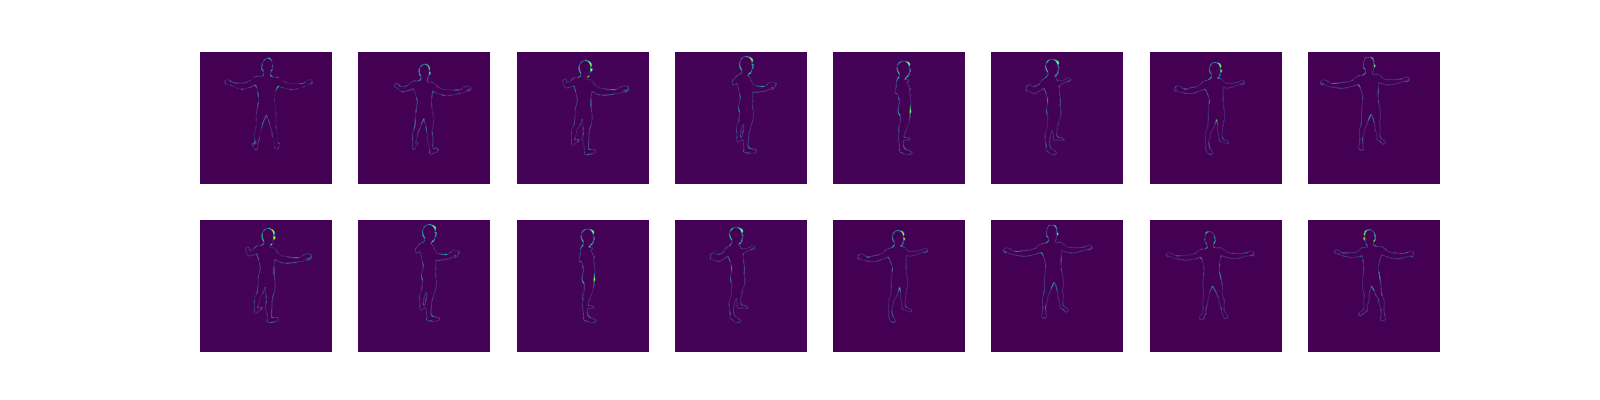

In [22]:
visualize2DResults(diffImages,pytorch3DImg=False)

In [23]:
# with torch.no_grad():
#     loss = torch.sum((imageRef[..., 3] - image[..., 3]) ** 2)
# print('Inital loss:', loss)
poses = []
losses = []

# cfg.learningRate = 0.05
# cfg.learningRate = 0.1
# cfg.plotStep = 5
# cfg.learningRate = 3

In [24]:
optimizer = torch.optim.Adam([xyzShift], lr=cfg.learningRate)

logFile = join(outFolderForExperiment, 'Logs.txt')
logger = Logger.configLogger(logFile)

In [25]:
torch.cuda.empty_cache()
showCudaMemUsage(device)


Before release: active_bytes.all.current: 204.913664 MB
After release: active_bytes.all.current: 204.913664 MB


C:\Users\Anka\.conda\envs\pytorch3d\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


2020-06-10 14:28:07,074 logger INFO loss 1.30, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


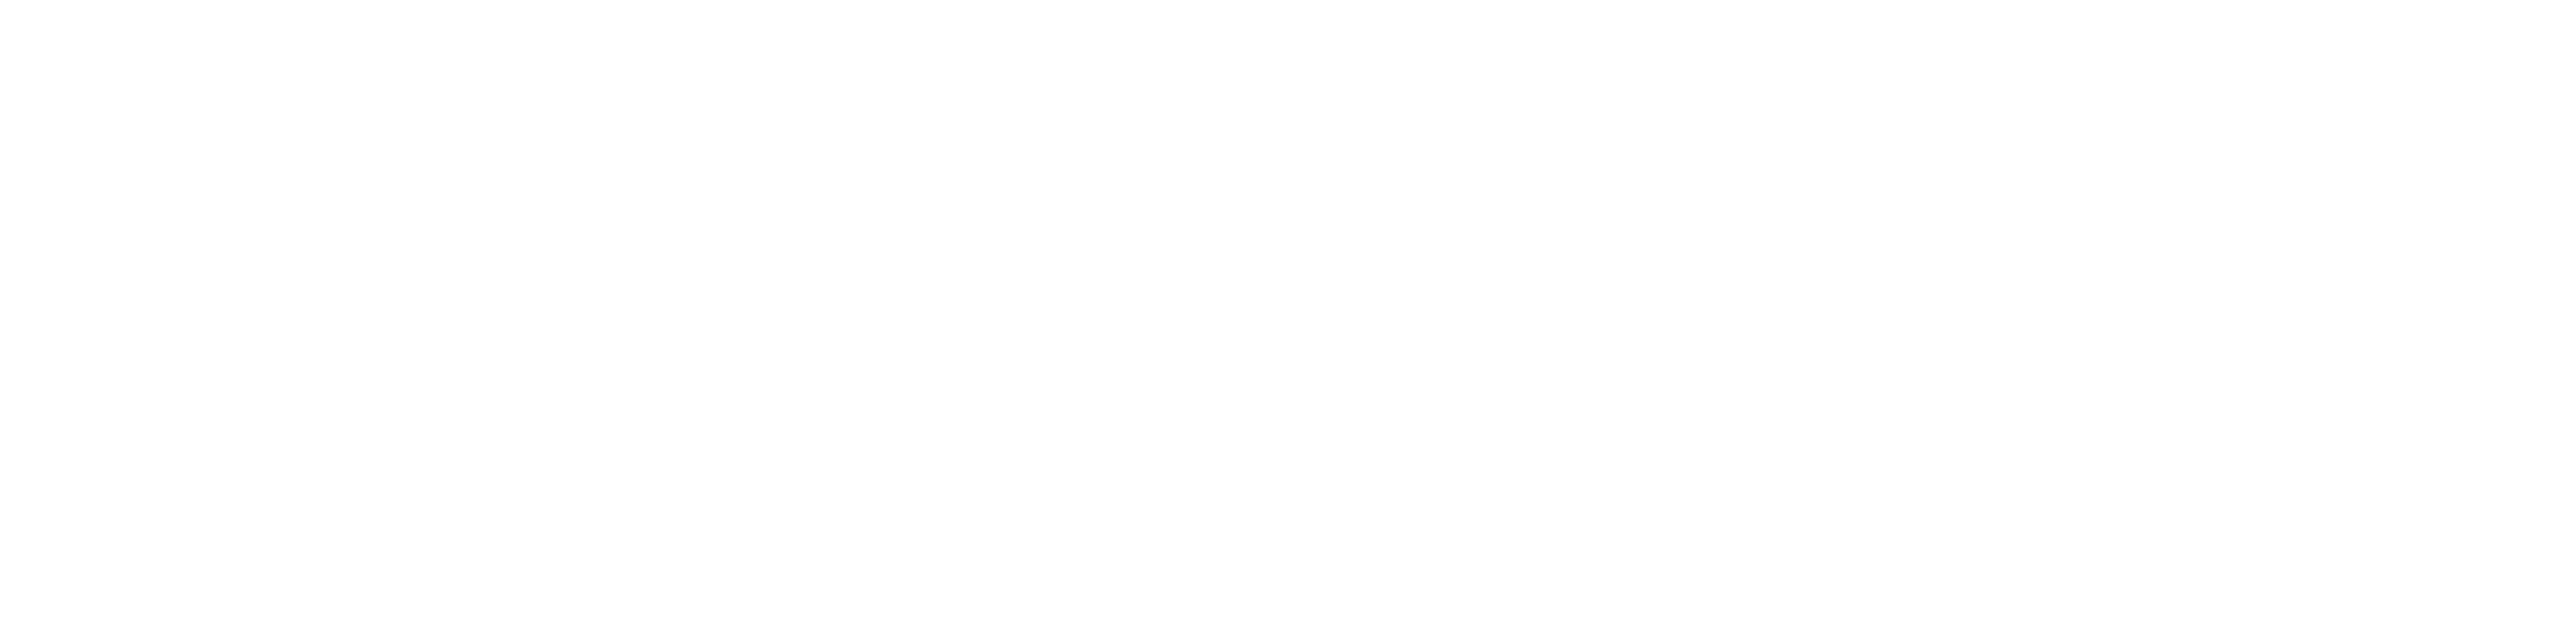

2020-06-10 14:28:31,135 logger INFO loss 2.33, MemUsed:231.75
2020-06-10 14:28:37,310 logger INFO loss 1.47, MemUsed:231.75
2020-06-10 14:28:43,662 logger INFO loss 1.59, MemUsed:231.75
2020-06-10 14:28:49,831 logger INFO loss 1.88, MemUsed:231.75
2020-06-10 14:28:56,030 logger INFO loss 1.74, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


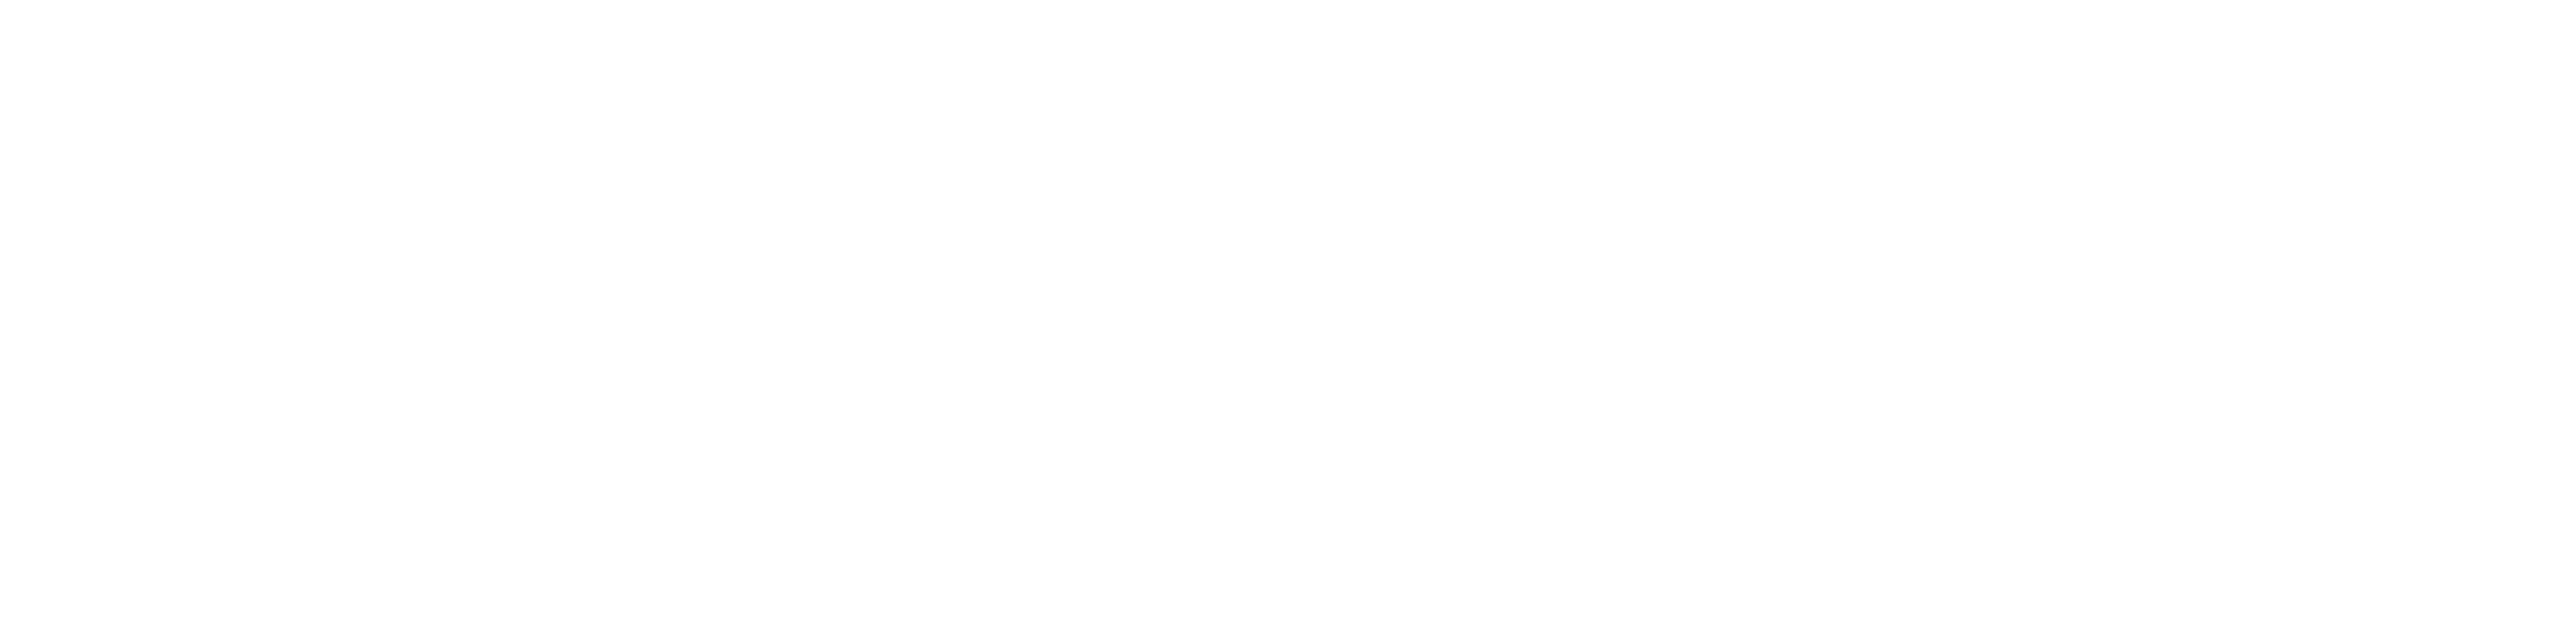

2020-06-10 14:29:20,182 logger INFO loss 1.47, MemUsed:231.75
2020-06-10 14:29:26,421 logger INFO loss 1.36, MemUsed:231.75
2020-06-10 14:29:32,641 logger INFO loss 1.43, MemUsed:231.75
2020-06-10 14:29:38,916 logger INFO loss 1.53, MemUsed:231.75
2020-06-10 14:29:45,133 logger INFO loss 1.52, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


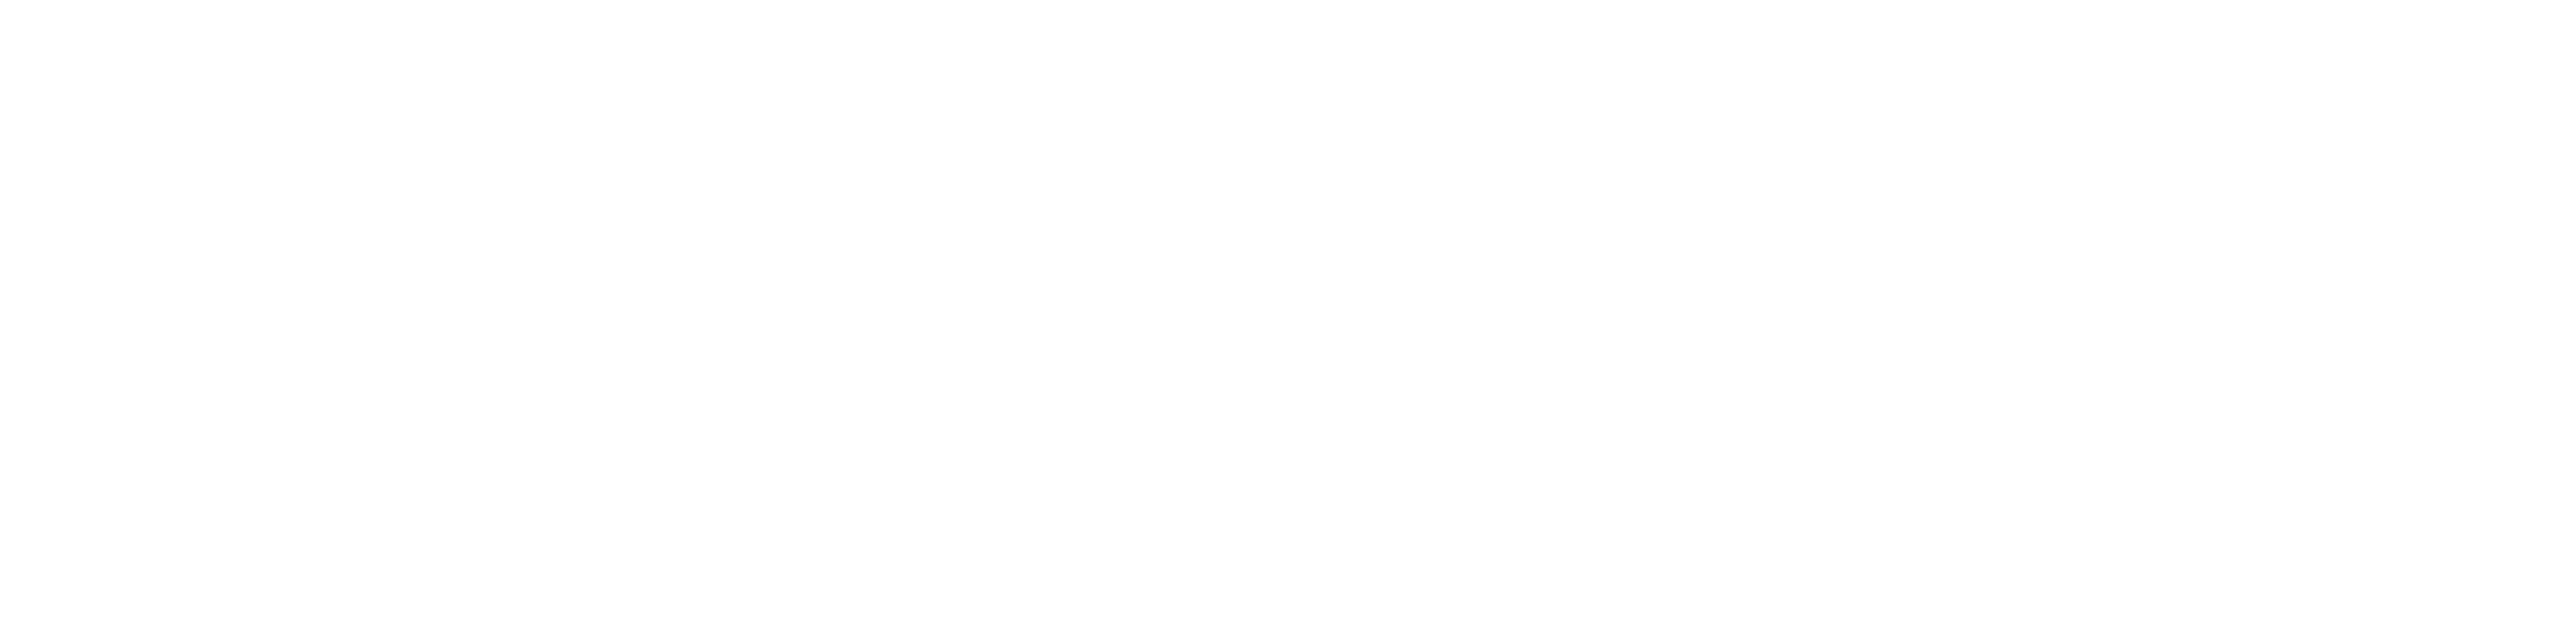

2020-06-10 14:30:09,285 logger INFO loss 1.41, MemUsed:231.75
2020-06-10 14:30:15,511 logger INFO loss 1.33, MemUsed:231.75
2020-06-10 14:30:21,786 logger INFO loss 1.33, MemUsed:231.75
2020-06-10 14:30:28,027 logger INFO loss 1.38, MemUsed:231.75
2020-06-10 14:30:34,305 logger INFO loss 1.42, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


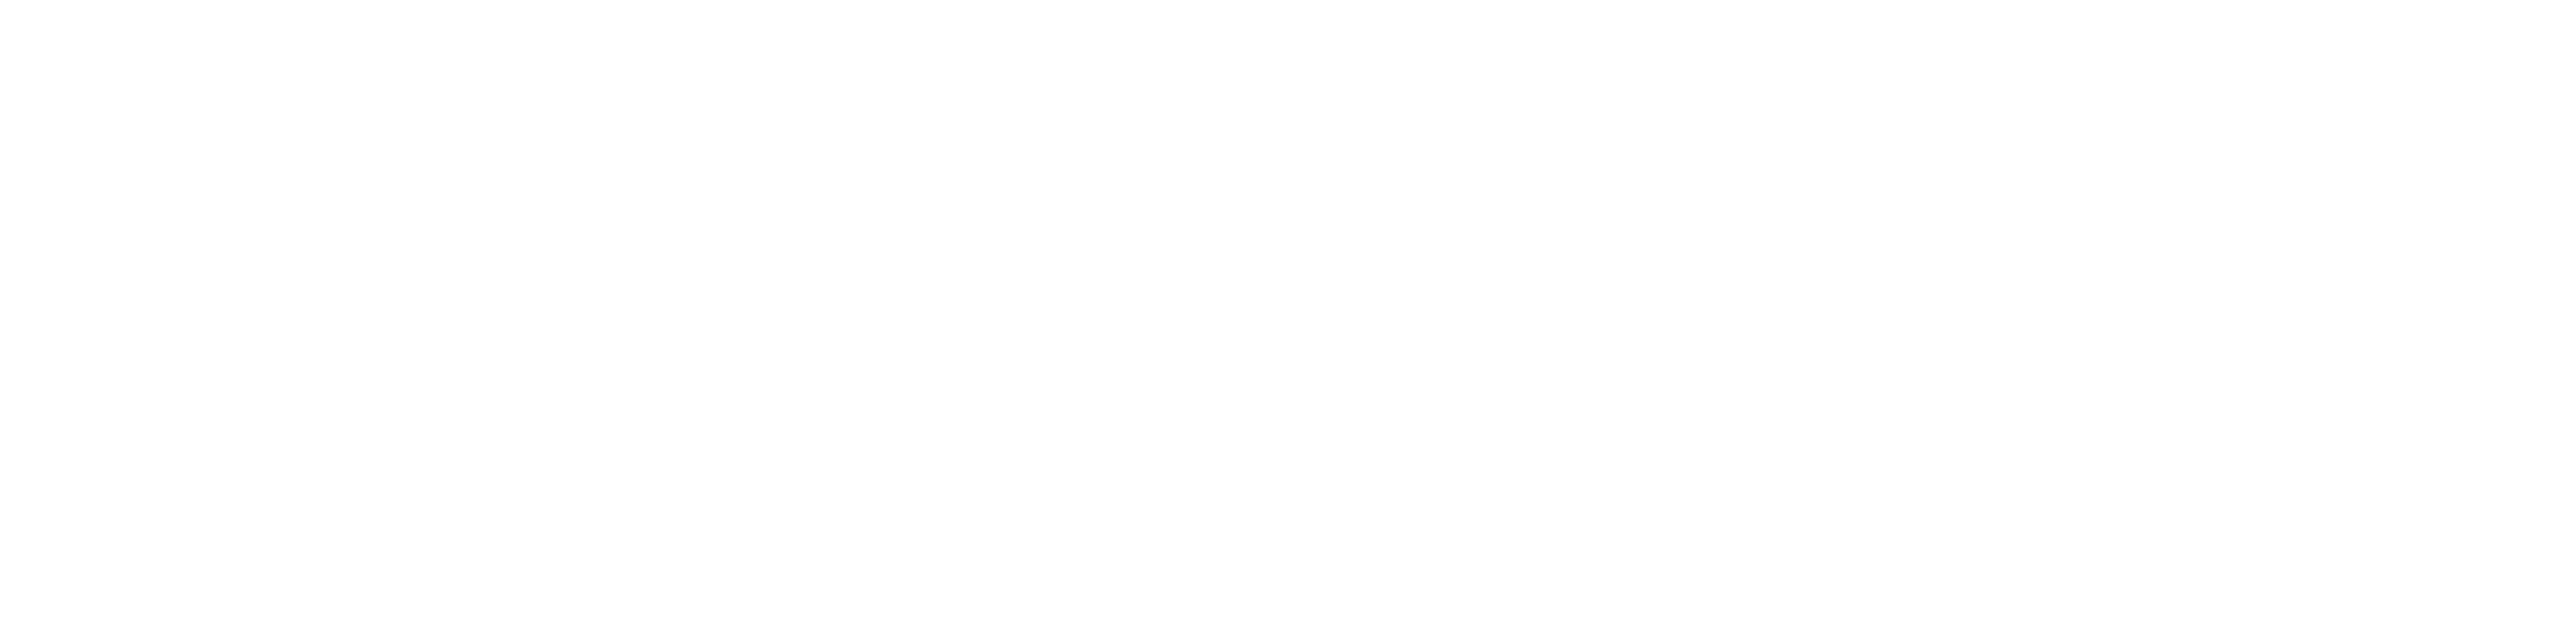

2020-06-10 14:30:58,522 logger INFO loss 1.40, MemUsed:231.75
2020-06-10 14:31:04,850 logger INFO loss 1.35, MemUsed:231.75
2020-06-10 14:31:11,102 logger INFO loss 1.30, MemUsed:231.75
2020-06-10 14:31:17,385 logger INFO loss 1.30, MemUsed:231.75
2020-06-10 14:31:23,645 logger INFO loss 1.32, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


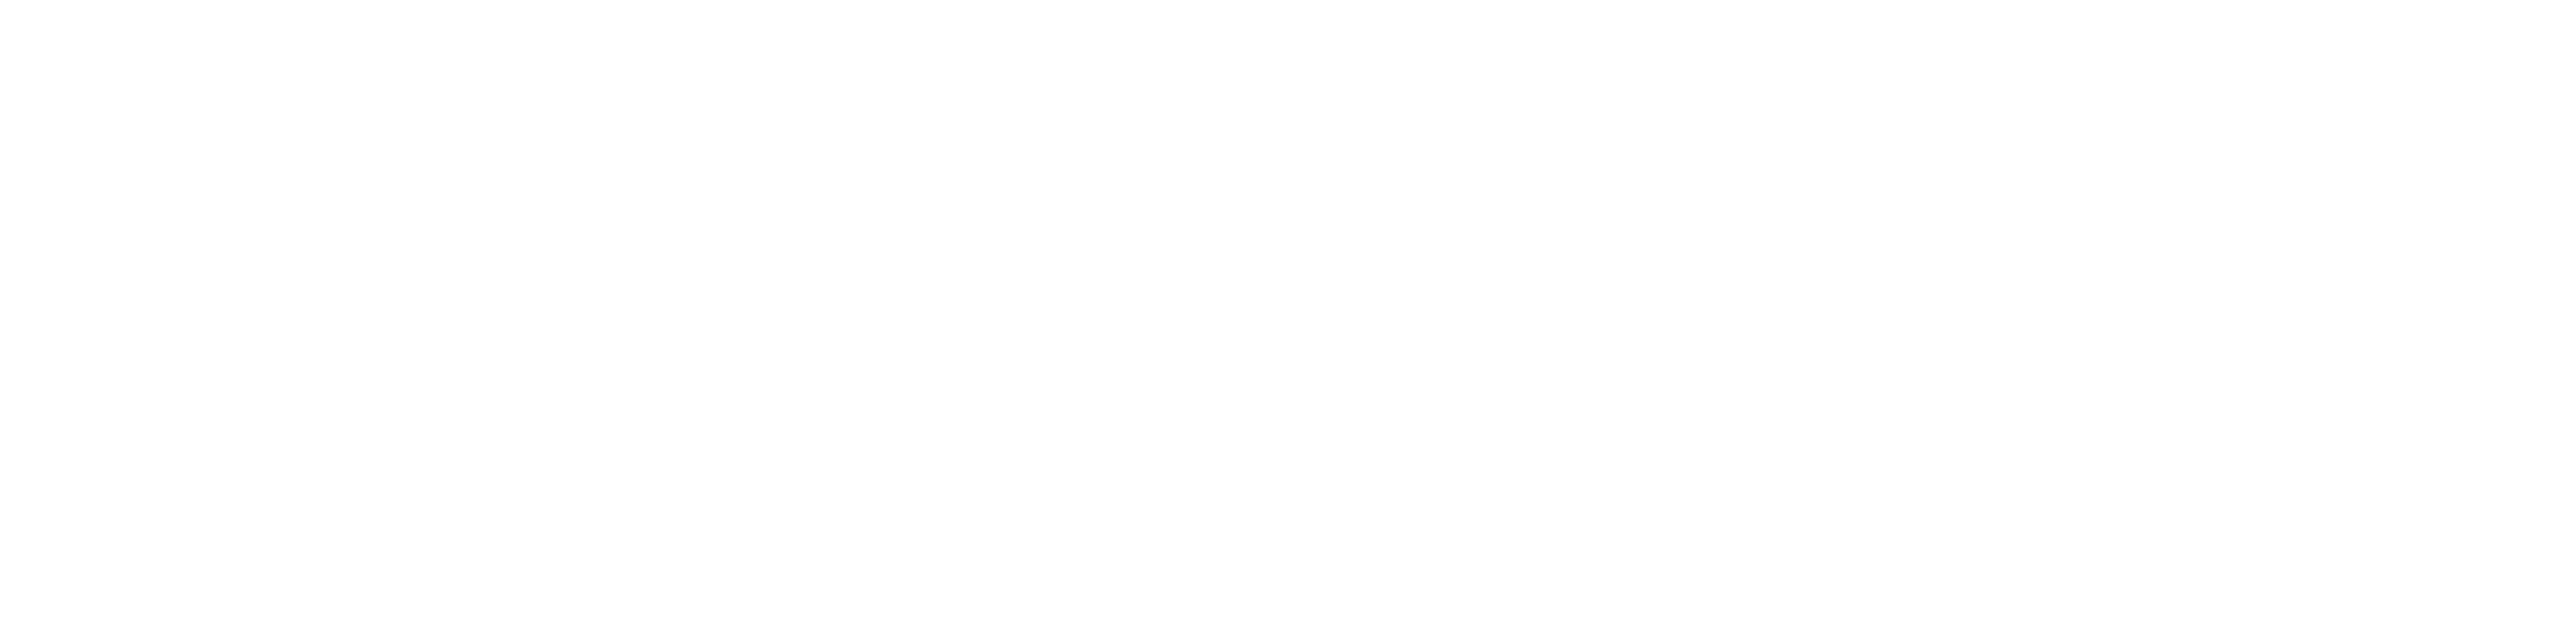

2020-06-10 14:31:47,980 logger INFO loss 1.34, MemUsed:231.75
2020-06-10 14:31:54,220 logger INFO loss 1.32, MemUsed:231.75
2020-06-10 14:32:00,503 logger INFO loss 1.30, MemUsed:231.75
2020-06-10 14:32:06,767 logger INFO loss 1.28, MemUsed:231.75
2020-06-10 14:32:13,077 logger INFO loss 1.29, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


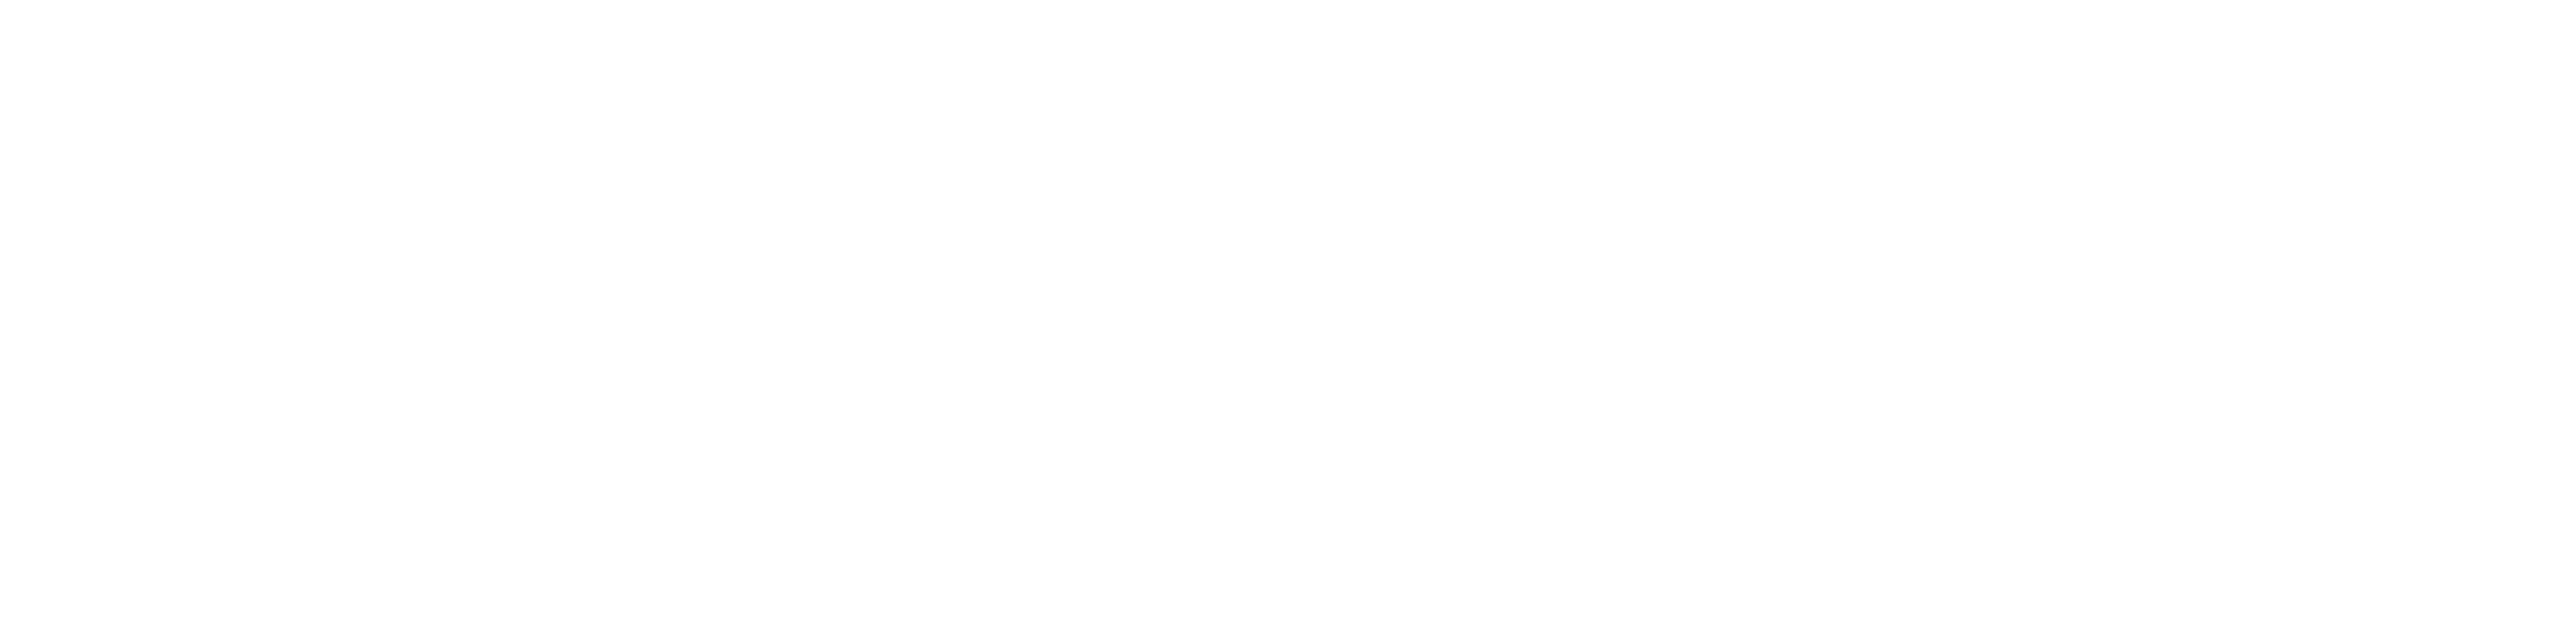

2020-06-10 14:32:37,248 logger INFO loss 1.30, MemUsed:231.75
2020-06-10 14:32:43,570 logger INFO loss 1.31, MemUsed:231.75
2020-06-10 14:32:49,833 logger INFO loss 1.30, MemUsed:231.75
2020-06-10 14:32:56,112 logger INFO loss 1.28, MemUsed:231.75
2020-06-10 14:33:02,365 logger INFO loss 1.27, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


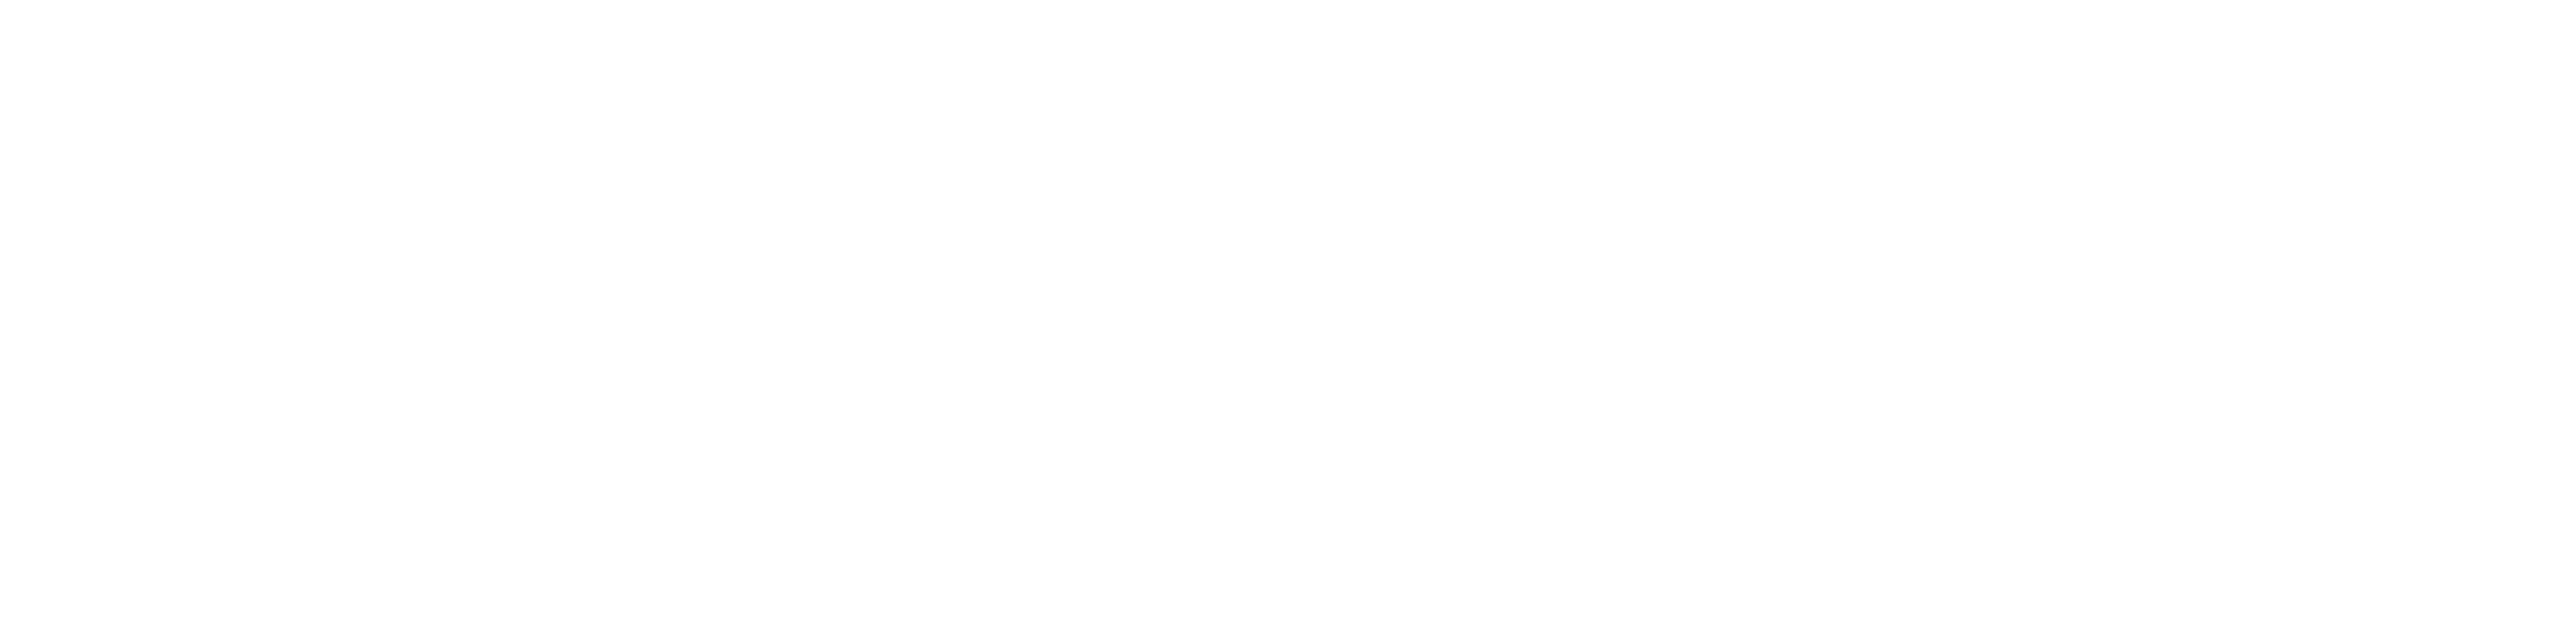

2020-06-10 14:33:26,652 logger INFO loss 1.27, MemUsed:231.75
2020-06-10 14:33:32,903 logger INFO loss 1.28, MemUsed:231.75
2020-06-10 14:33:39,209 logger INFO loss 1.28, MemUsed:231.75
2020-06-10 14:33:45,472 logger INFO loss 1.27, MemUsed:231.75
2020-06-10 14:33:51,800 logger INFO loss 1.27, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


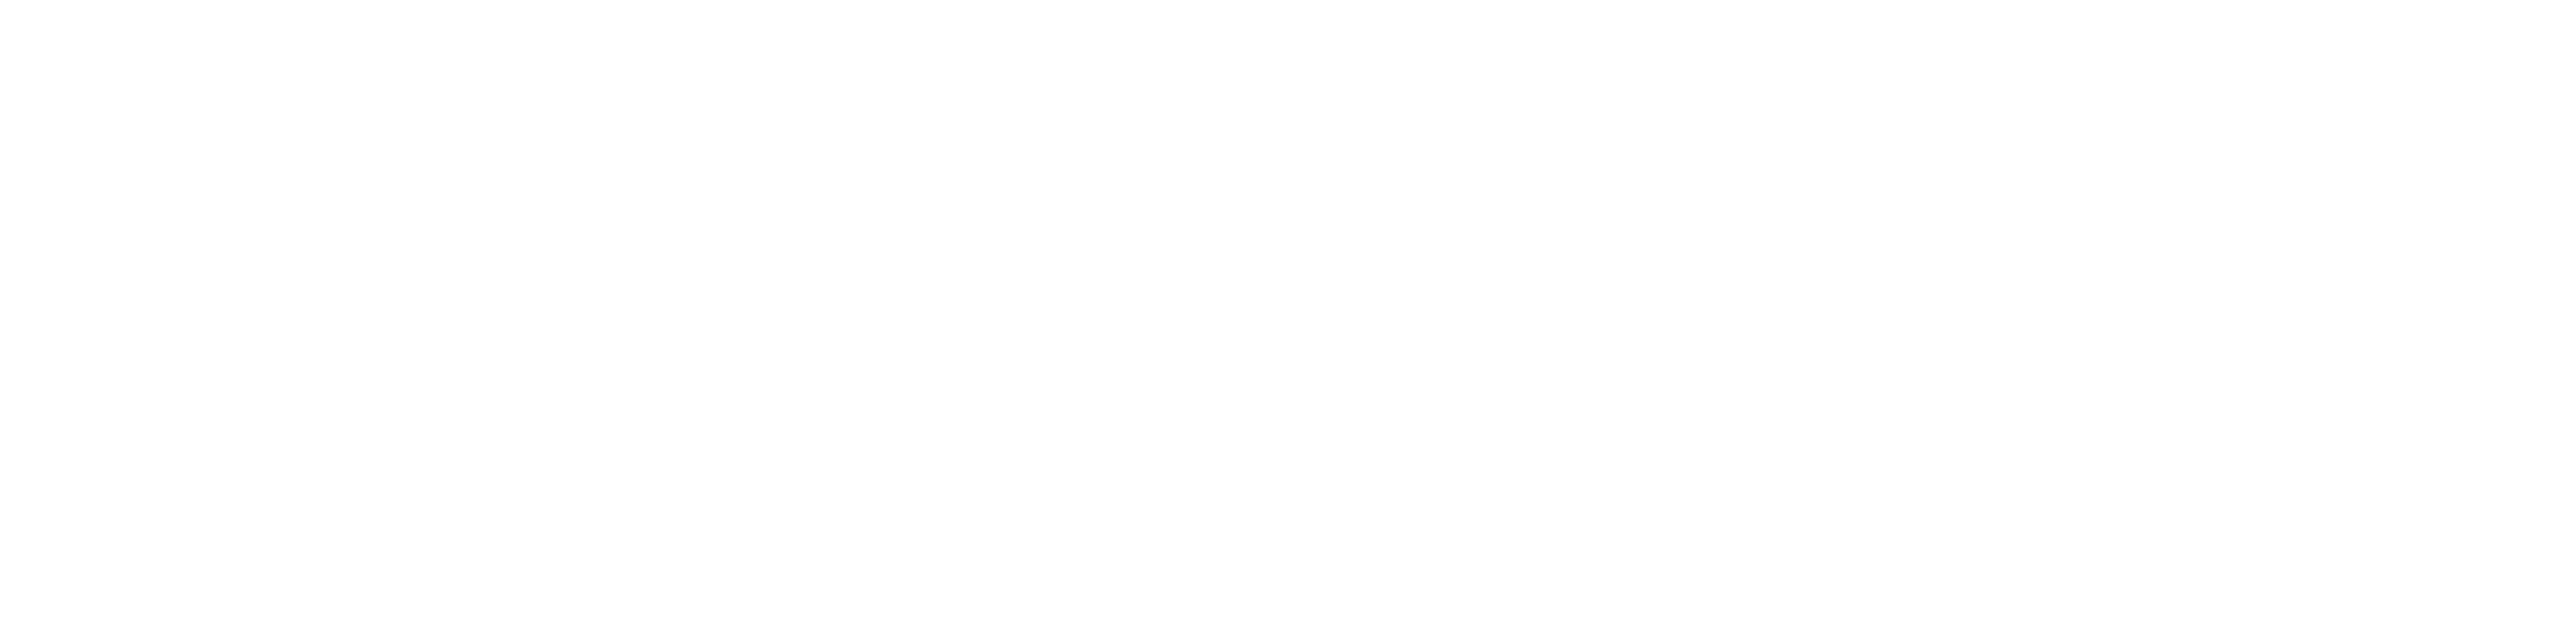

2020-06-10 14:34:16,093 logger INFO loss 1.27, MemUsed:231.75
2020-06-10 14:34:22,375 logger INFO loss 1.27, MemUsed:231.75
2020-06-10 14:34:28,662 logger INFO loss 1.28, MemUsed:231.75
2020-06-10 14:34:34,948 logger INFO loss 1.28, MemUsed:231.75
2020-06-10 14:34:41,251 logger INFO loss 1.27, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


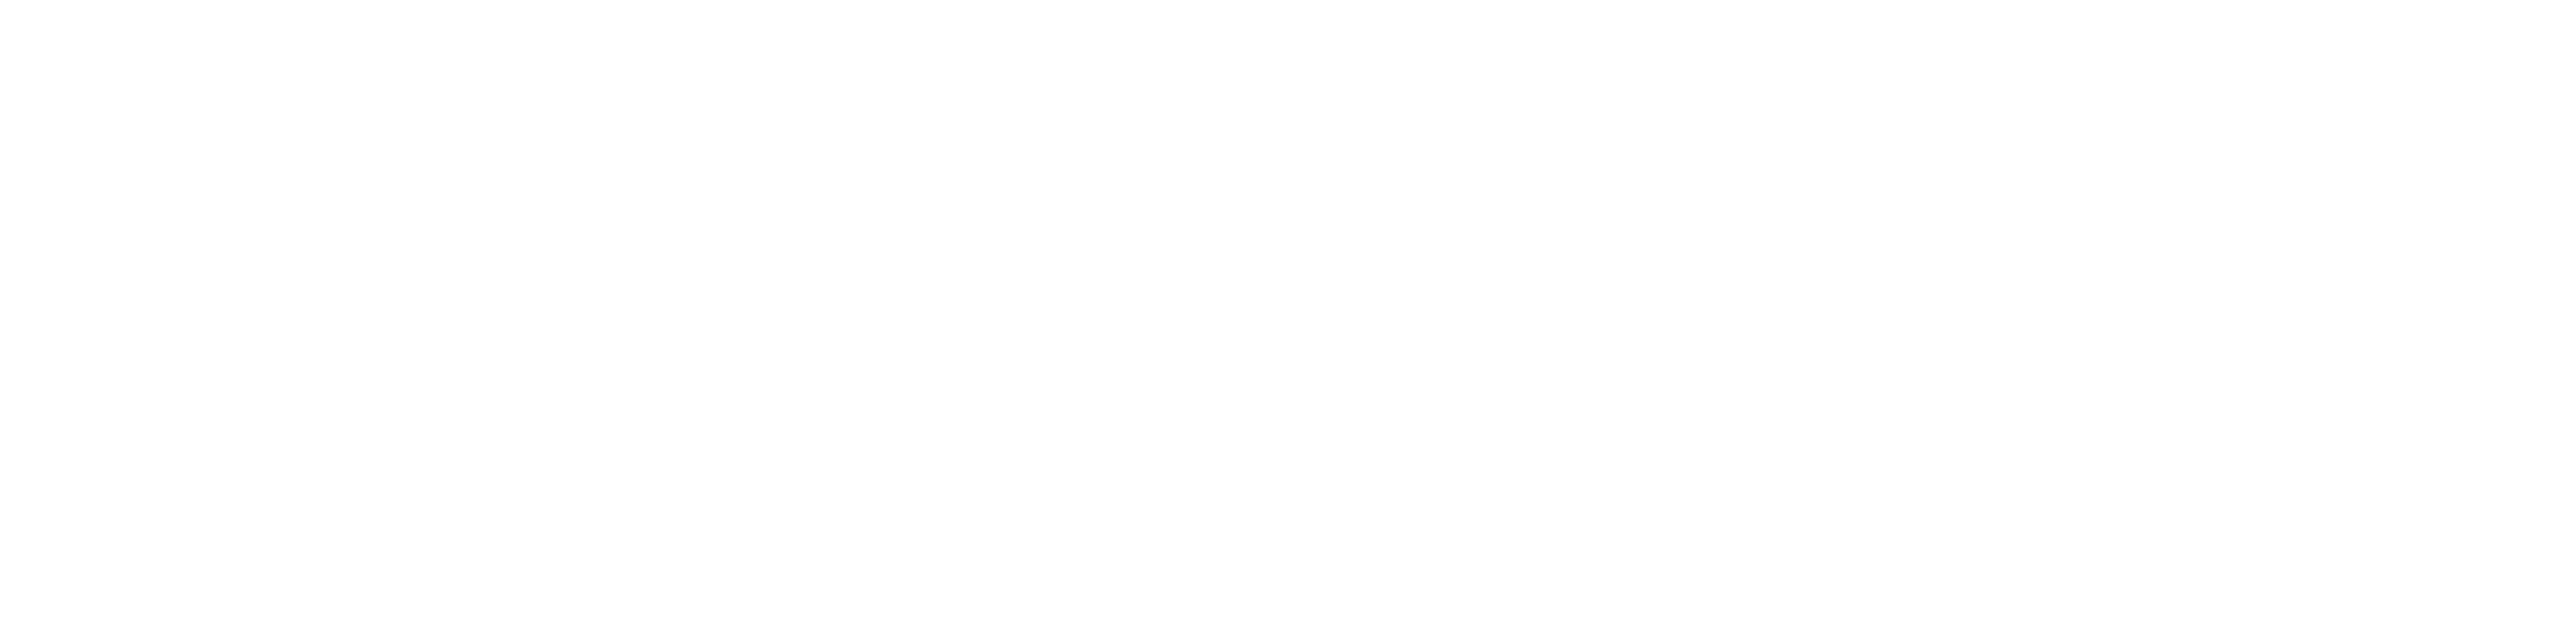

2020-06-10 14:35:05,709 logger INFO loss 1.27, MemUsed:231.75
2020-06-10 14:35:12,369 logger INFO loss 1.27, MemUsed:231.75
2020-06-10 14:35:18,643 logger INFO loss 1.27, MemUsed:231.75
2020-06-10 14:35:24,974 logger INFO loss 1.27, MemUsed:231.75
2020-06-10 14:35:31,306 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


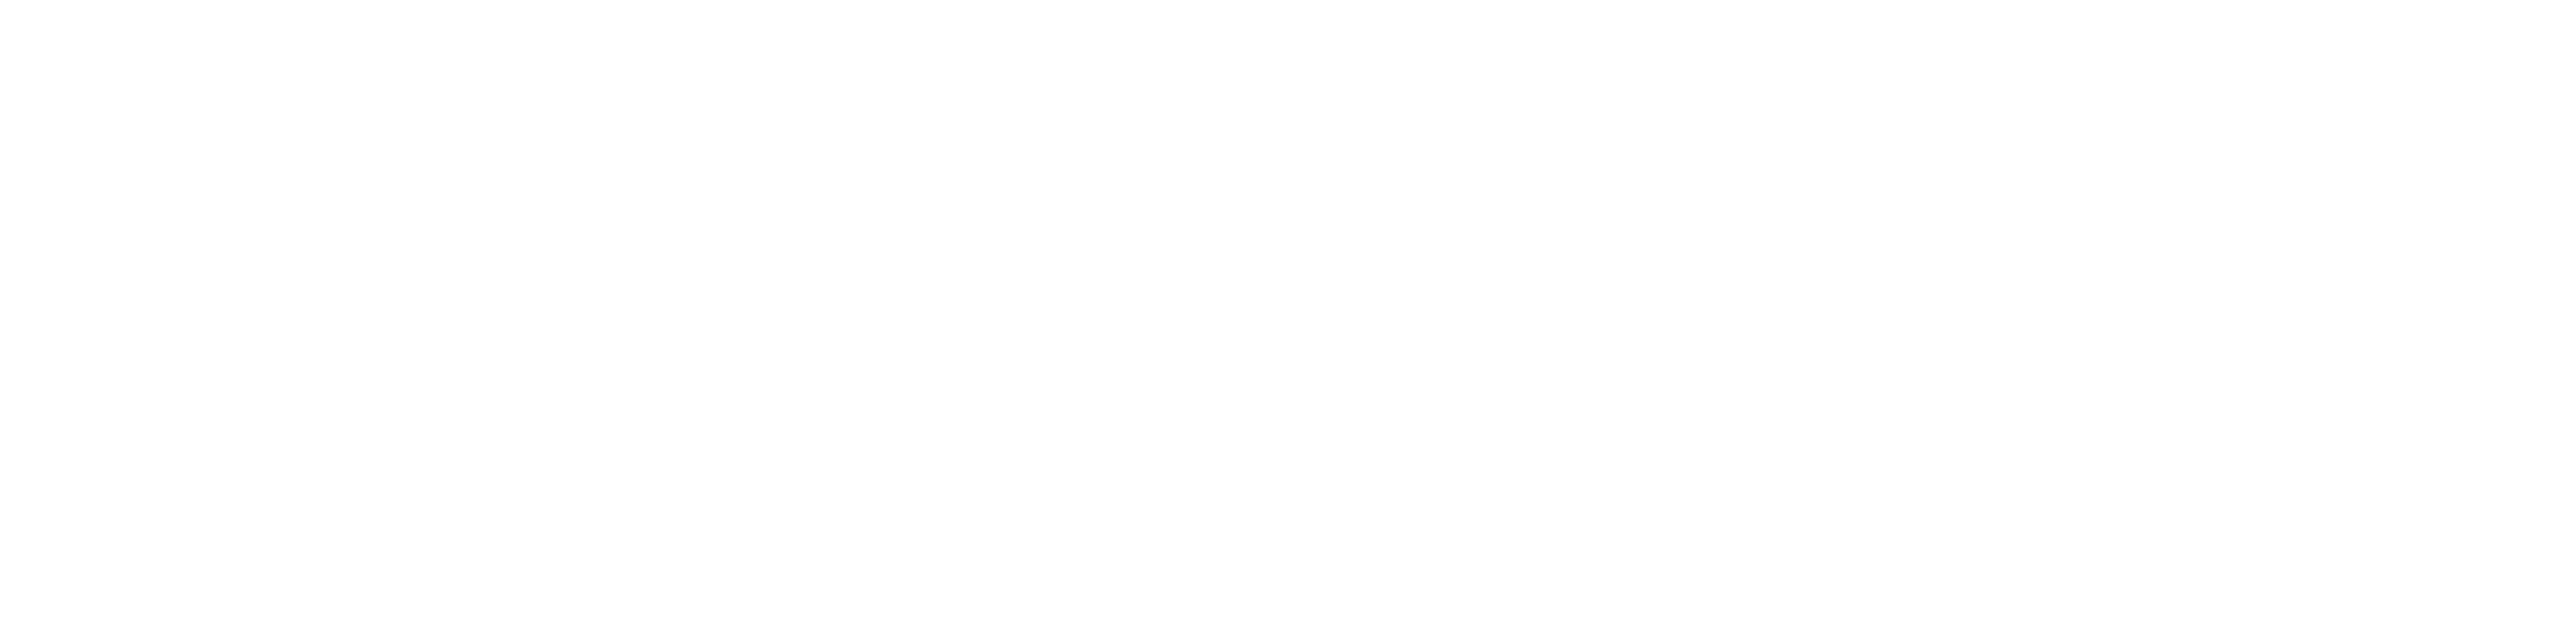

2020-06-10 14:35:55,748 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:36:01,990 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:36:08,273 logger INFO loss 1.27, MemUsed:231.75
2020-06-10 14:36:14,522 logger INFO loss 1.27, MemUsed:231.75
2020-06-10 14:36:20,914 logger INFO loss 1.27, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


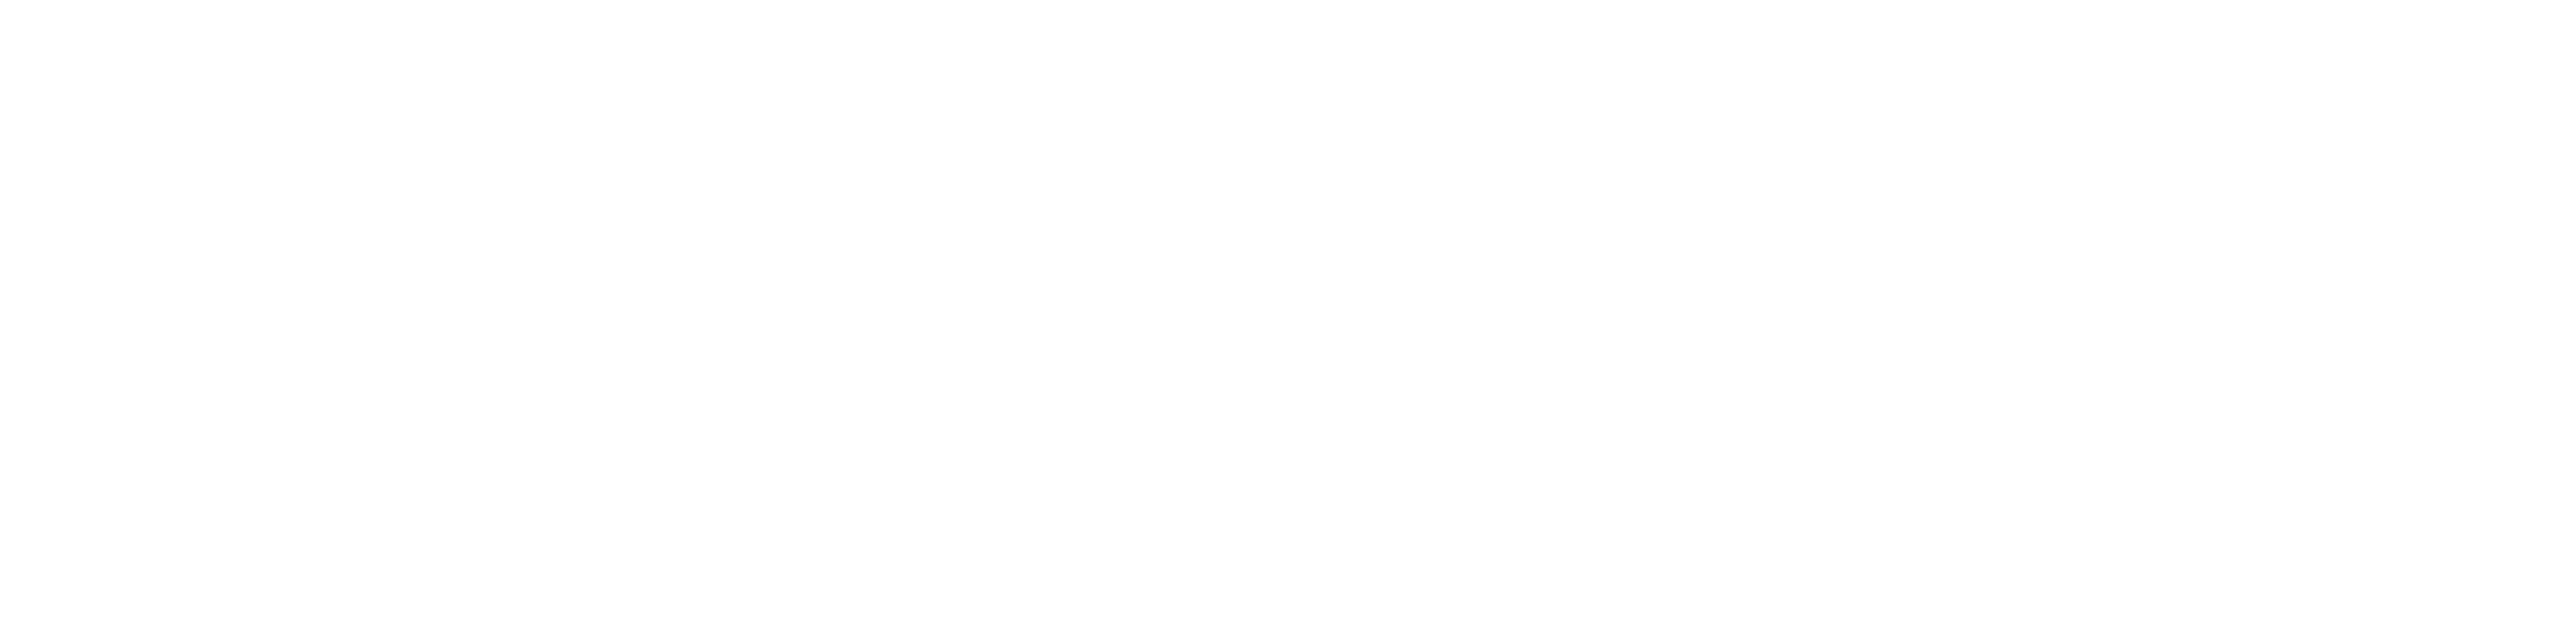

2020-06-10 14:36:45,204 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:36:51,534 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:36:57,797 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:37:04,087 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:37:10,364 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


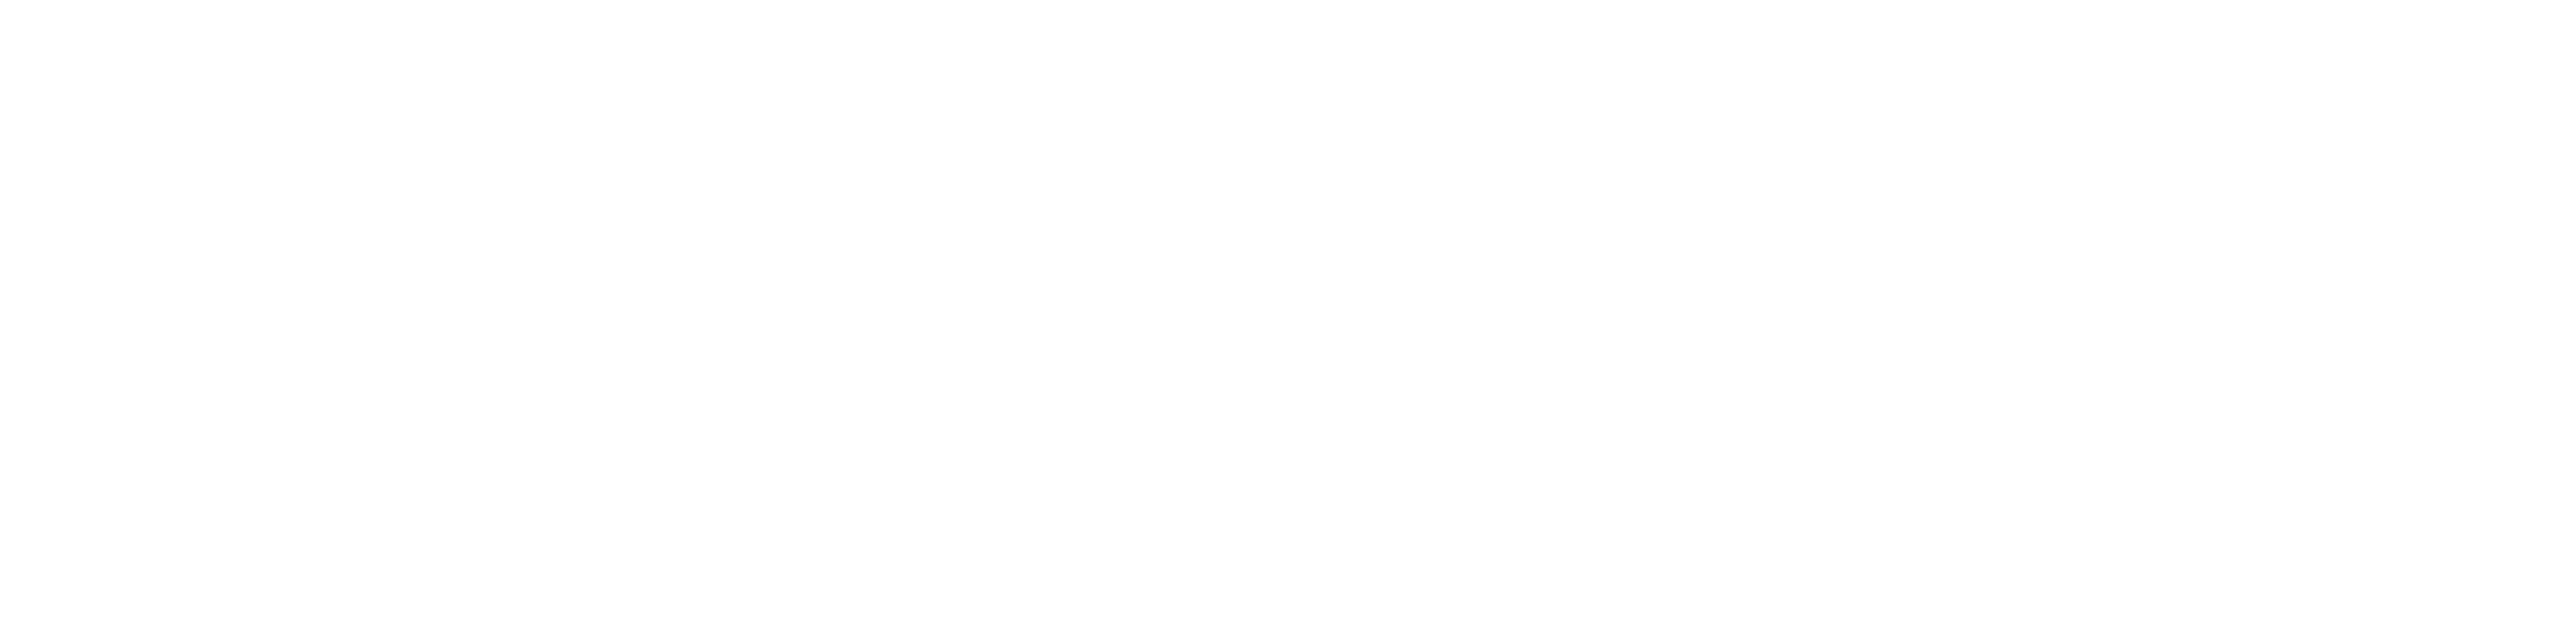

2020-06-10 14:37:34,748 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:37:41,136 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:37:47,592 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:37:53,997 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:38:00,376 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


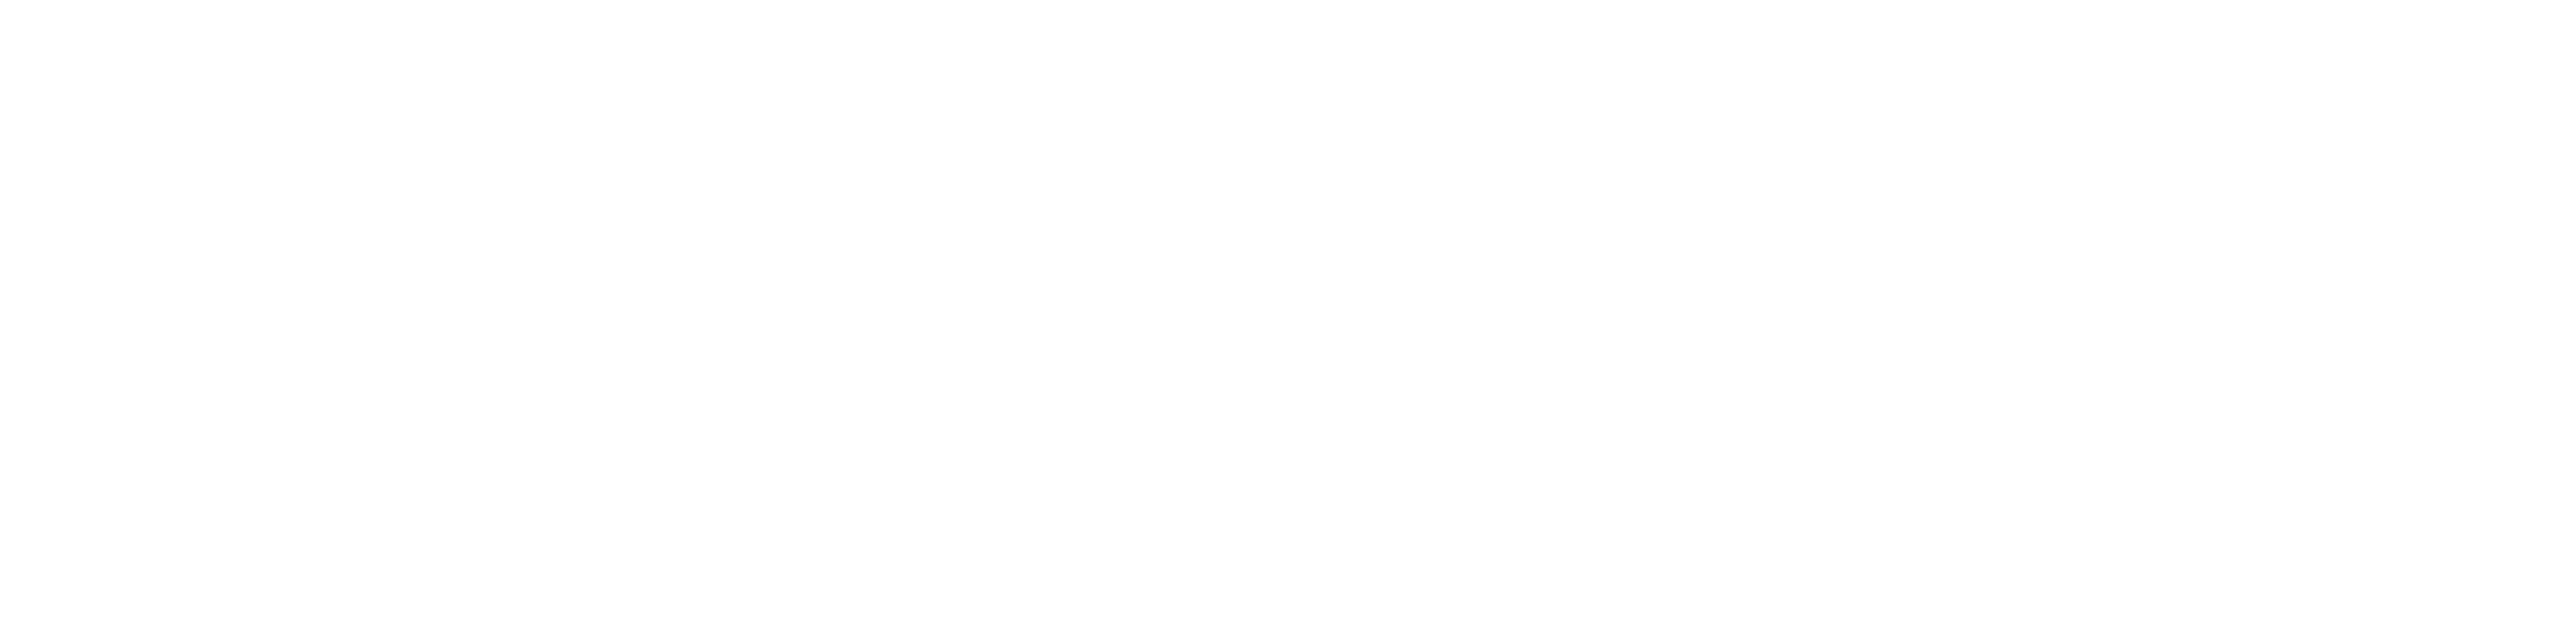

2020-06-10 14:38:24,811 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:38:31,225 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:38:37,527 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:38:43,848 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:38:50,235 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


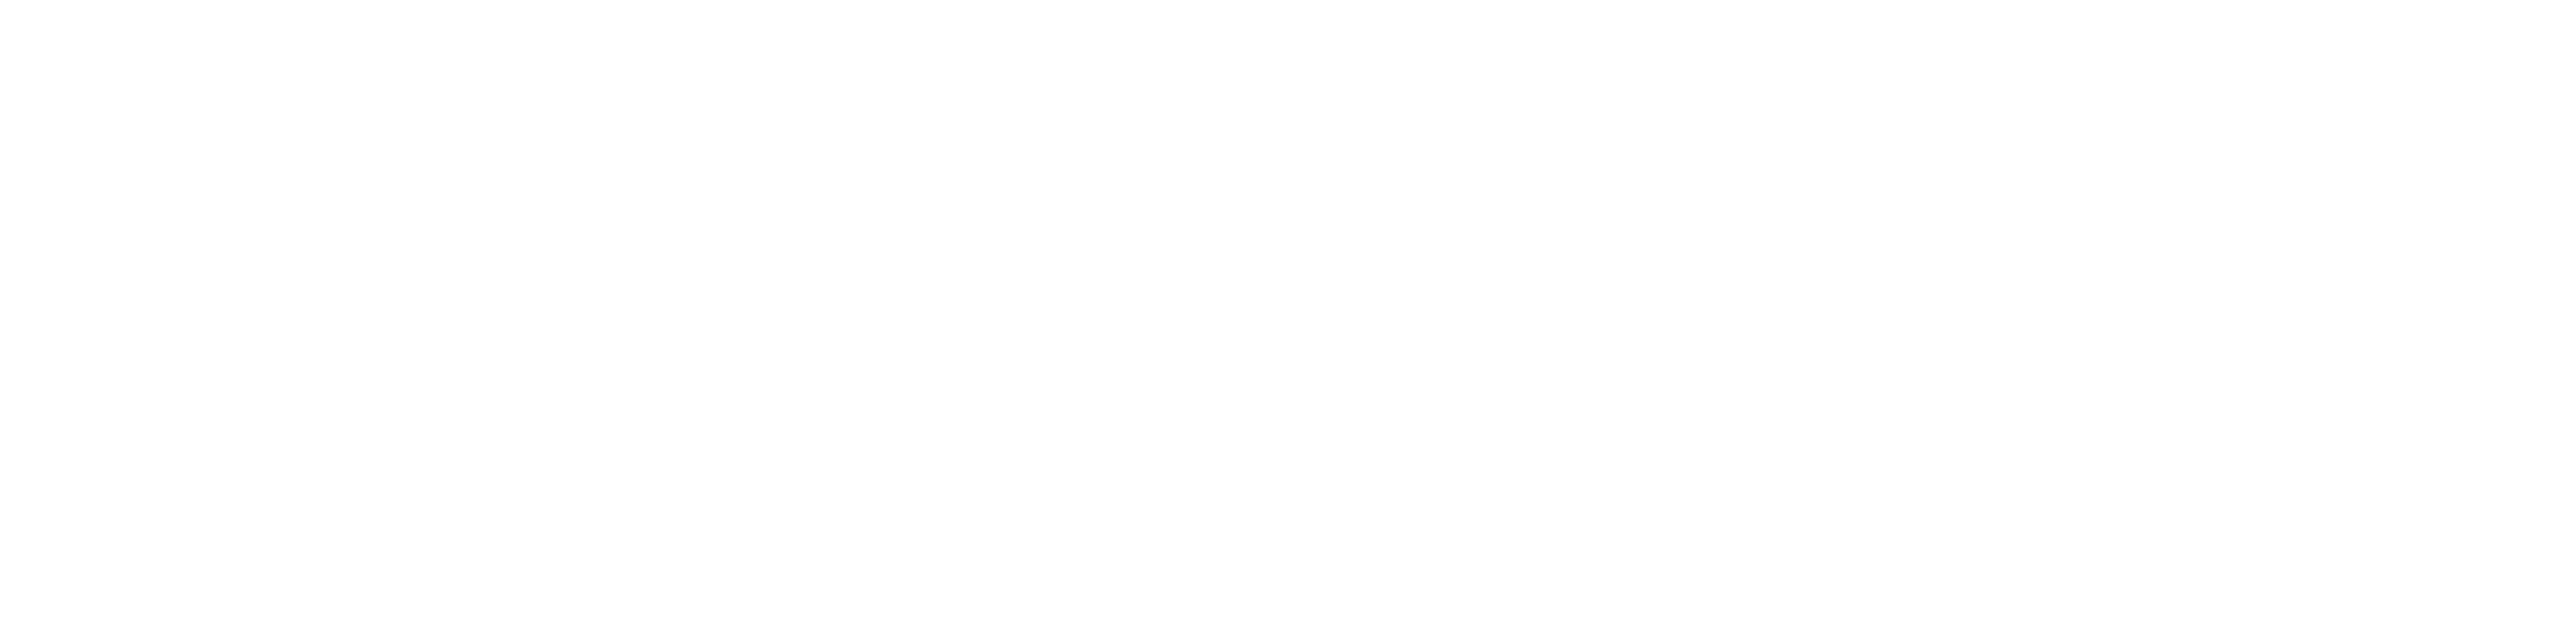

2020-06-10 14:39:14,959 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:39:21,521 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:39:27,841 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:39:34,126 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:39:40,588 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


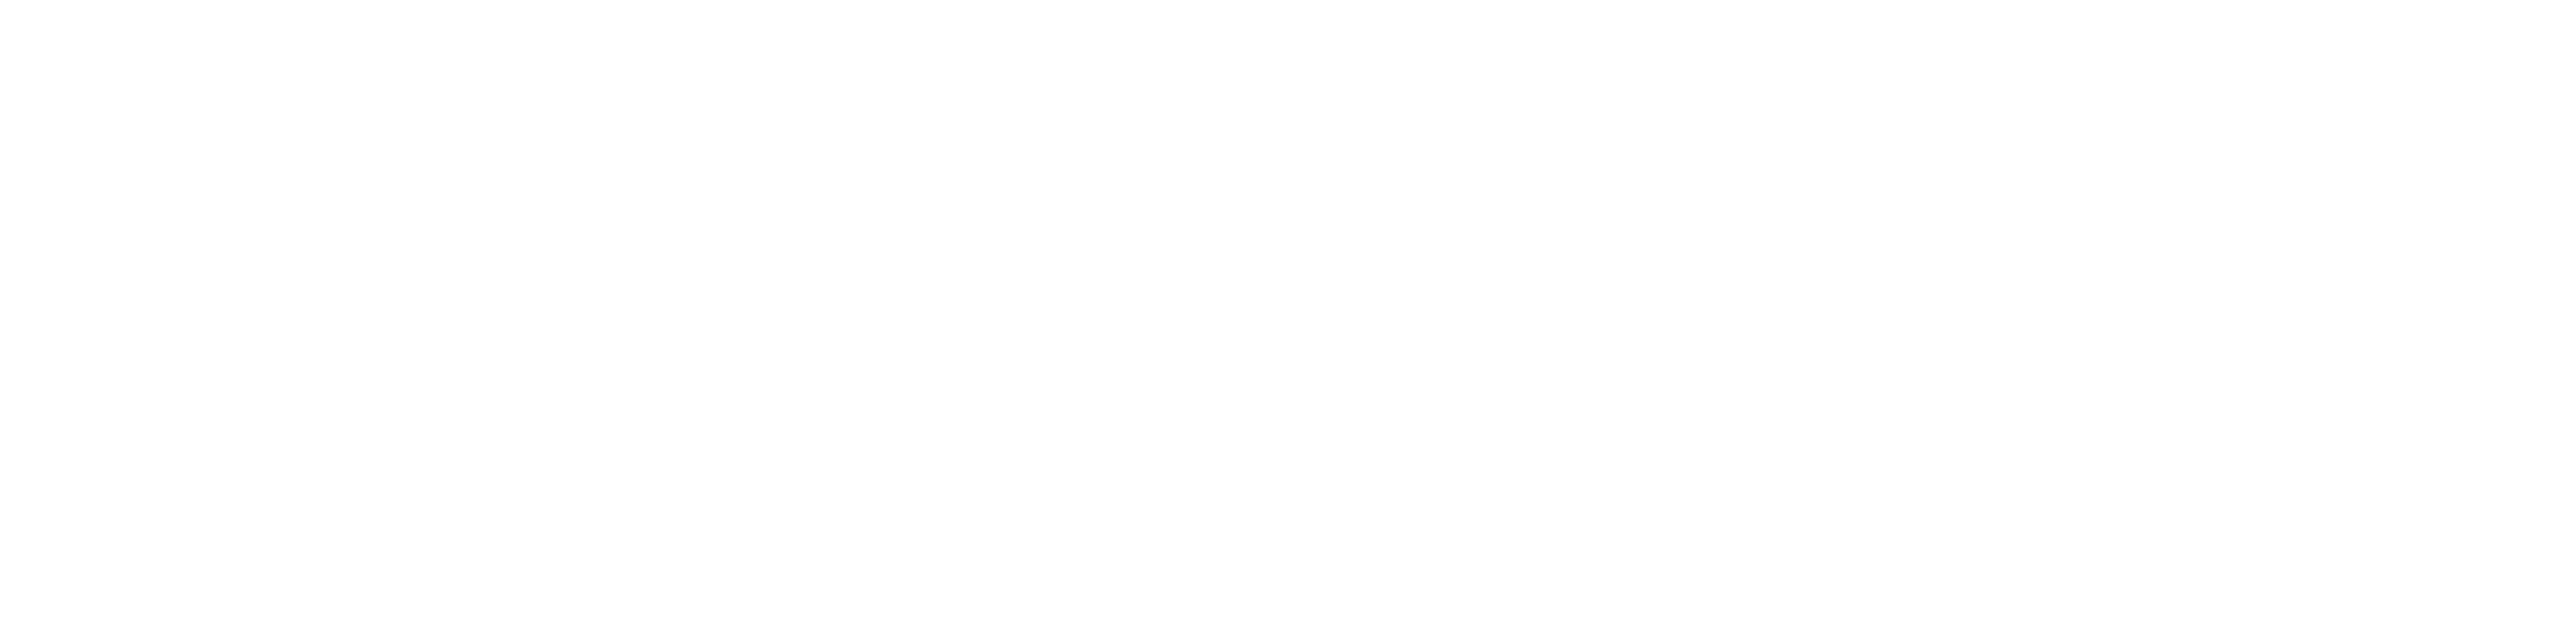

2020-06-10 14:40:04,982 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:40:11,238 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:40:17,541 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:40:23,812 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:40:30,185 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


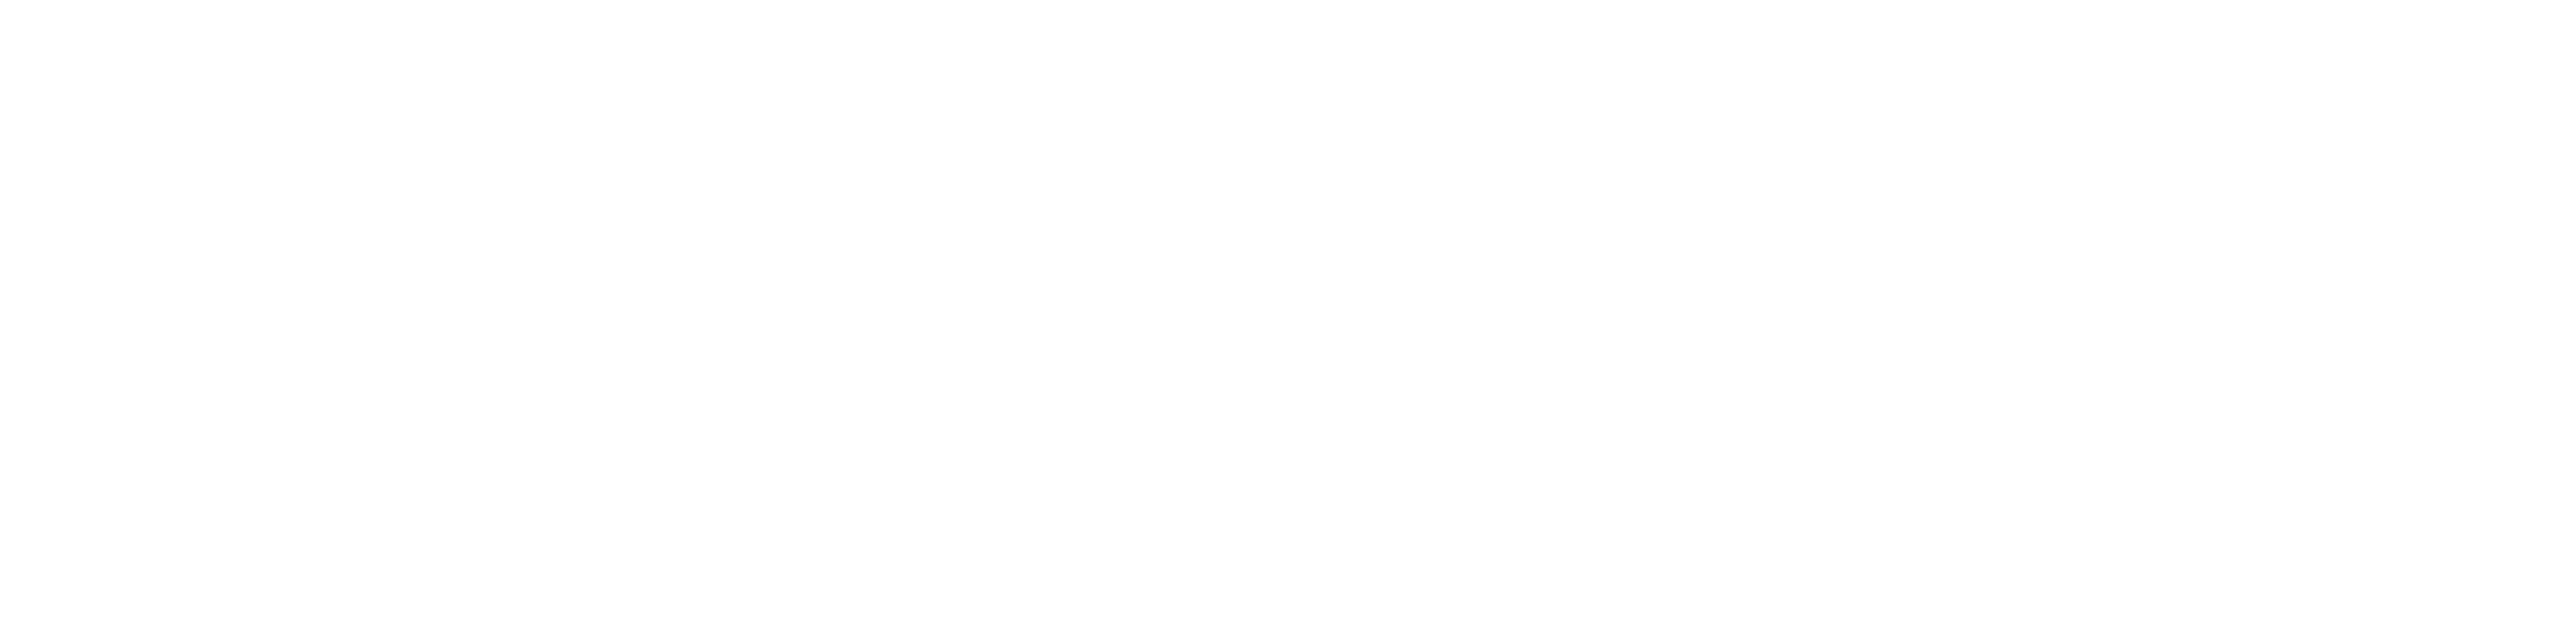

2020-06-10 14:40:54,658 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:41:00,932 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:41:07,198 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:41:13,497 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:41:19,849 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


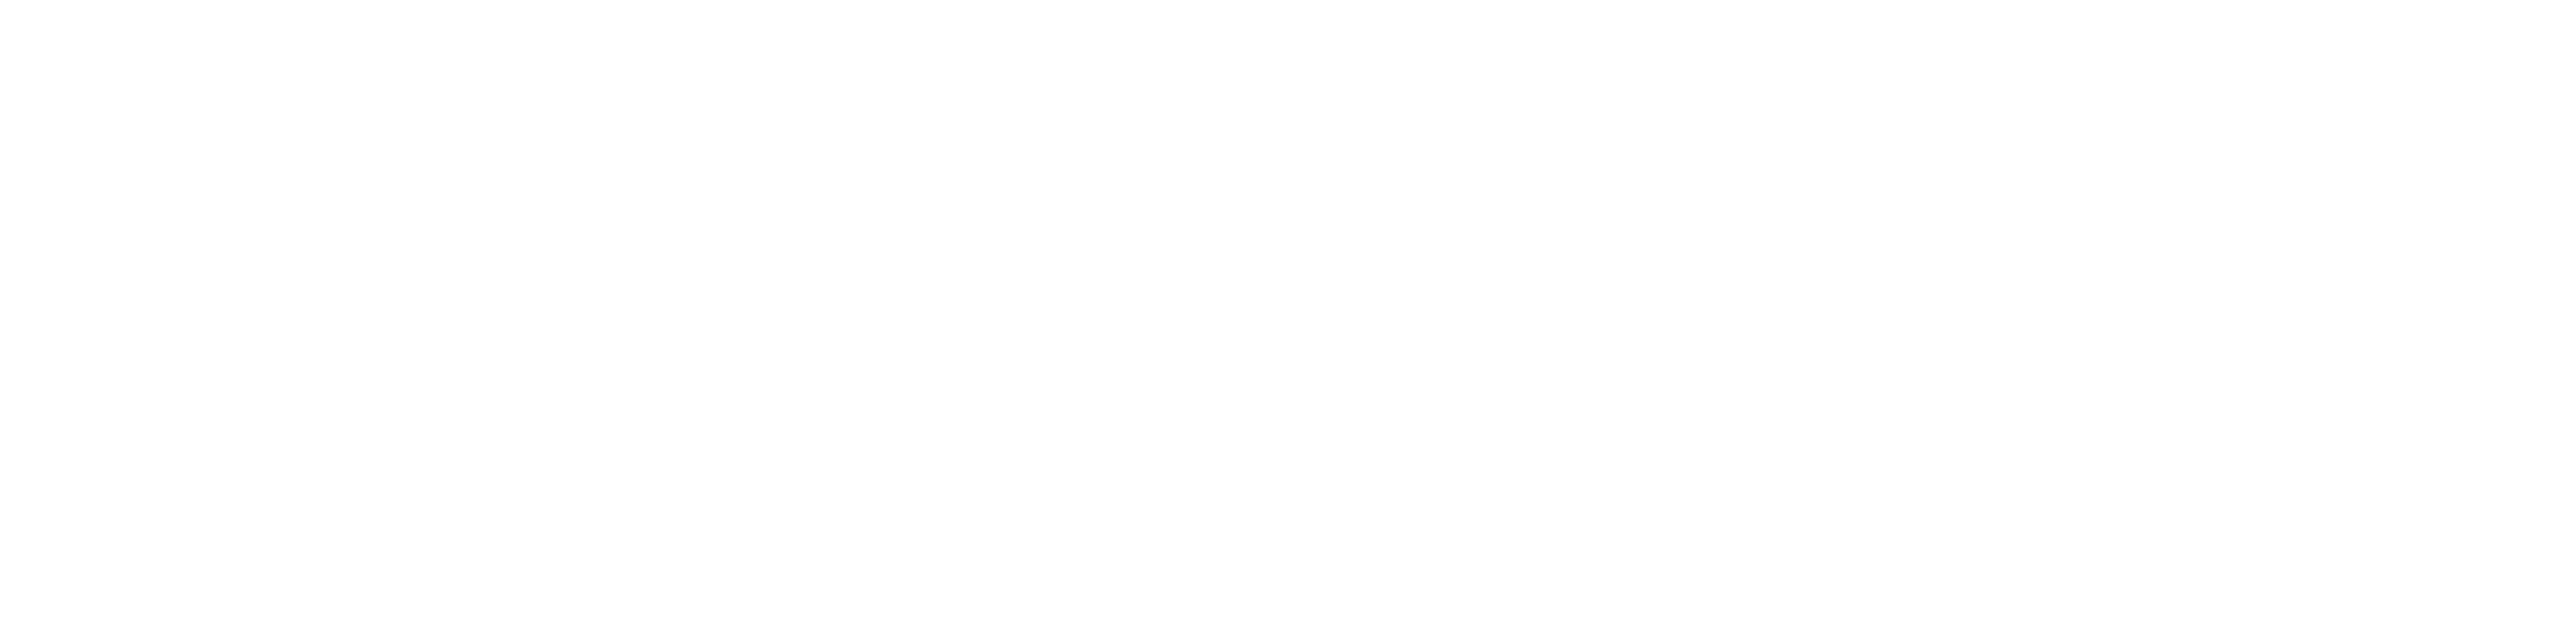

2020-06-10 14:41:44,348 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:41:50,653 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:41:56,970 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:42:03,340 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:42:09,865 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


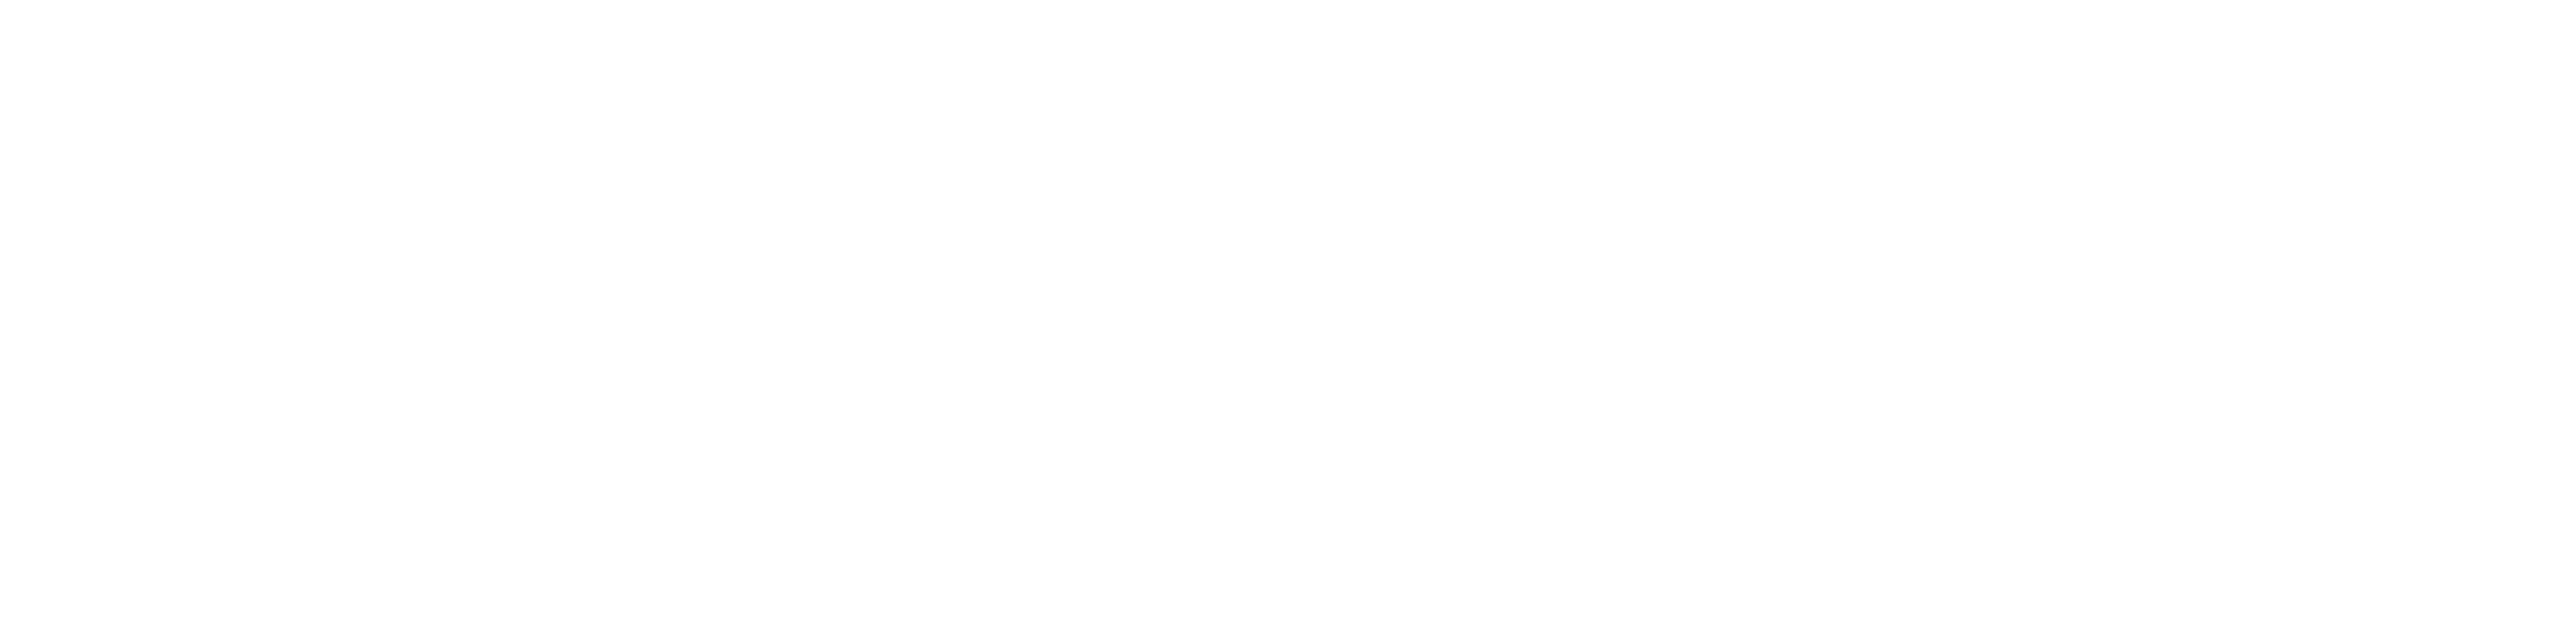

2020-06-10 14:42:34,522 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:42:40,988 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:42:47,292 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:42:53,848 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:43:00,167 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


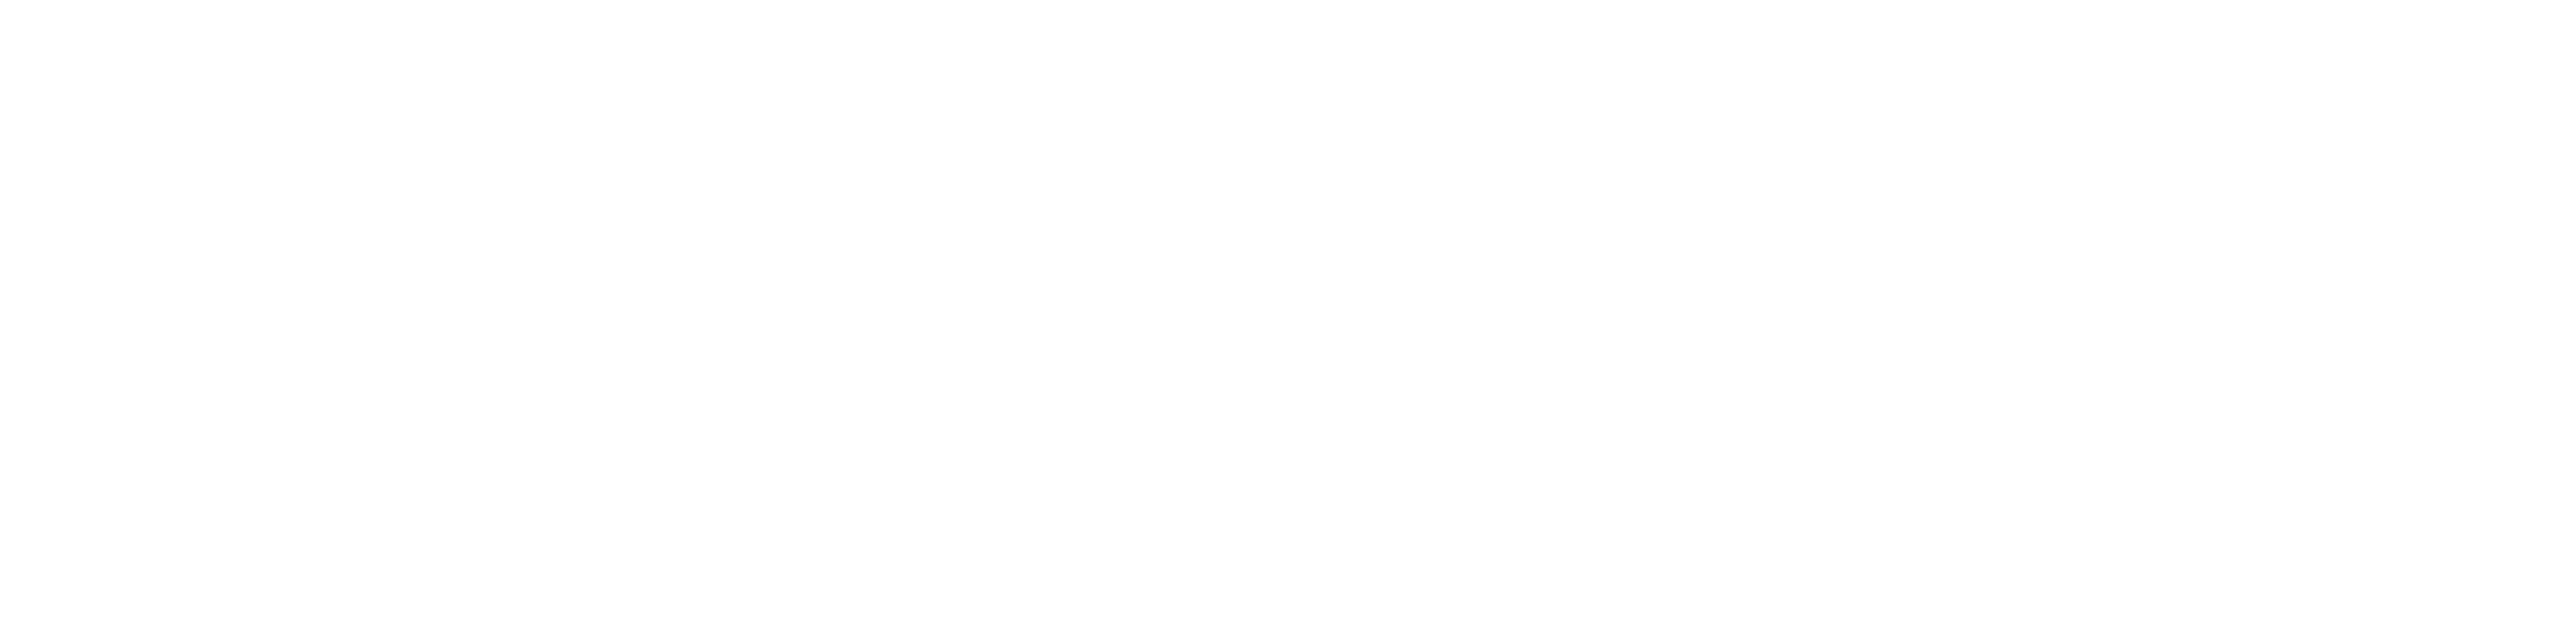

2020-06-10 14:43:24,871 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:43:31,326 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:43:37,661 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:43:43,987 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:43:50,493 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


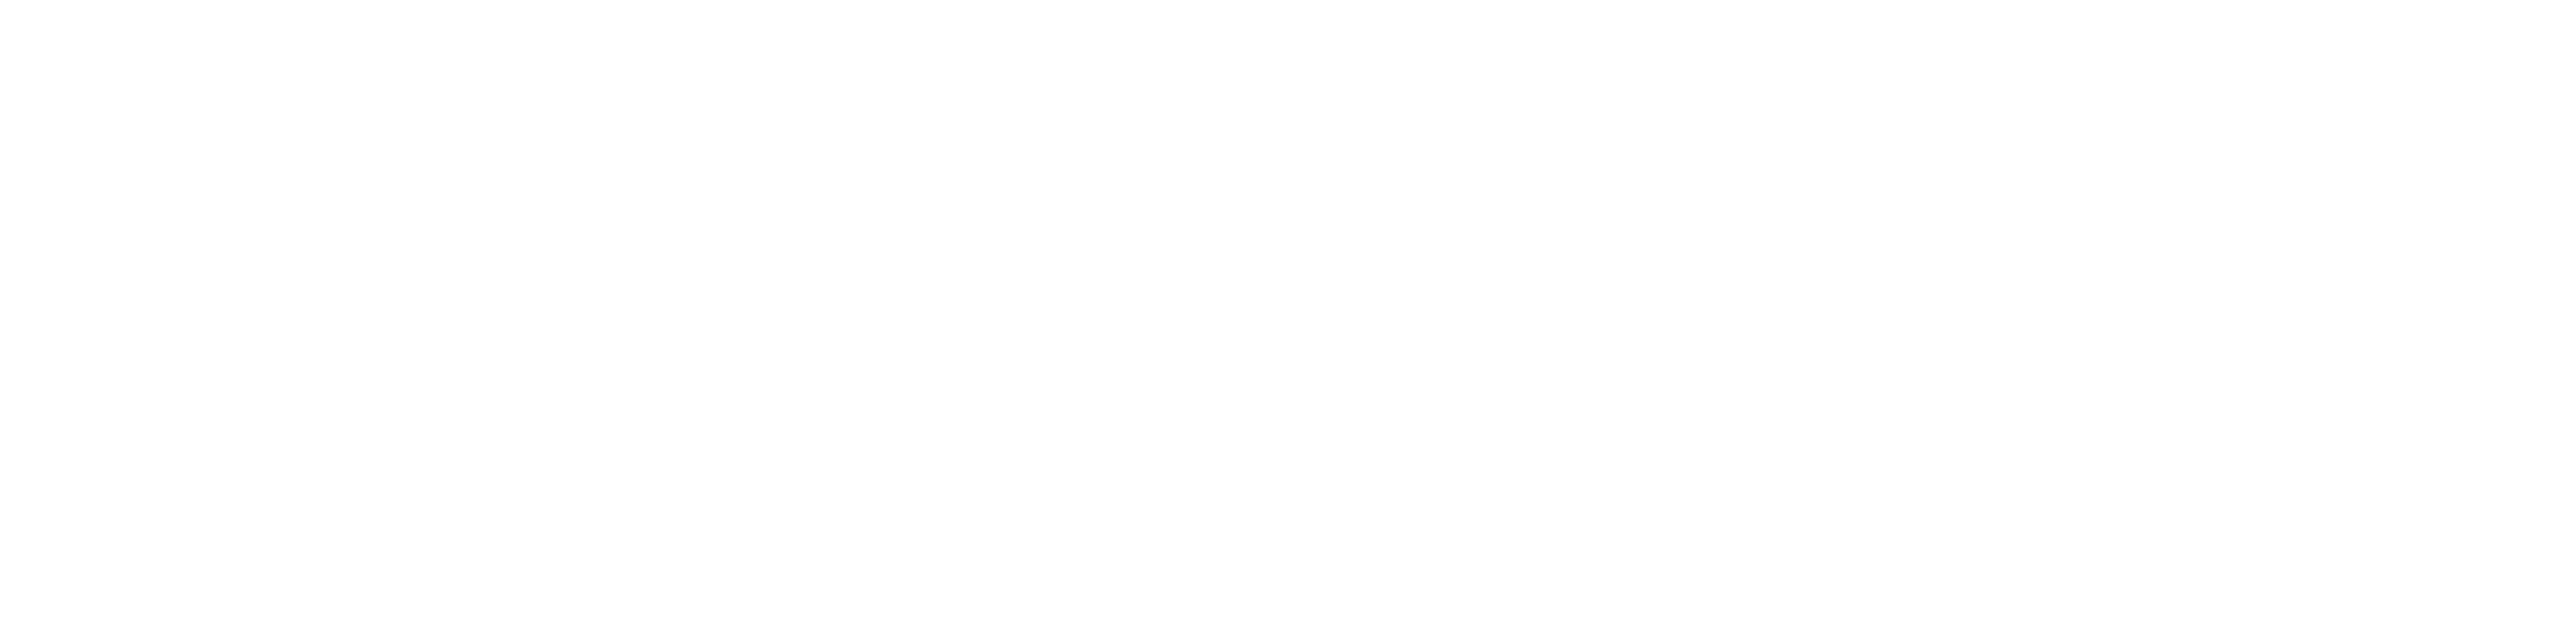

2020-06-10 14:44:15,092 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:44:21,405 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:44:27,671 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:44:33,954 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:44:40,351 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


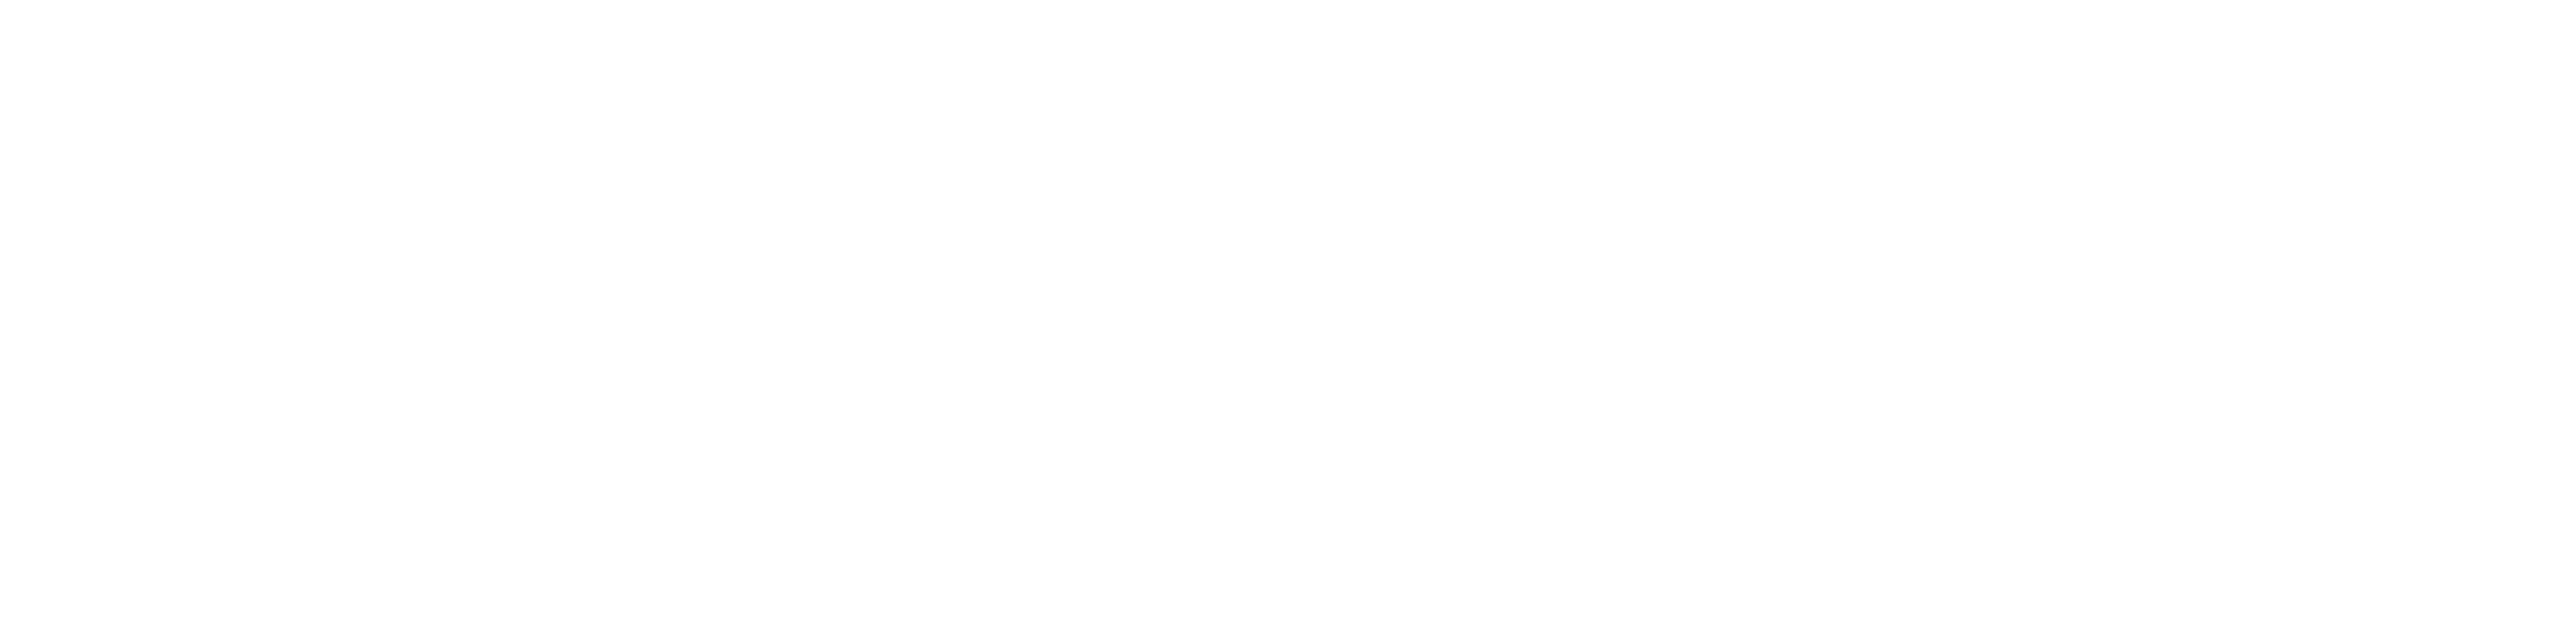

2020-06-10 14:45:04,671 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:45:10,884 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:45:17,126 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:45:23,353 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:45:29,747 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


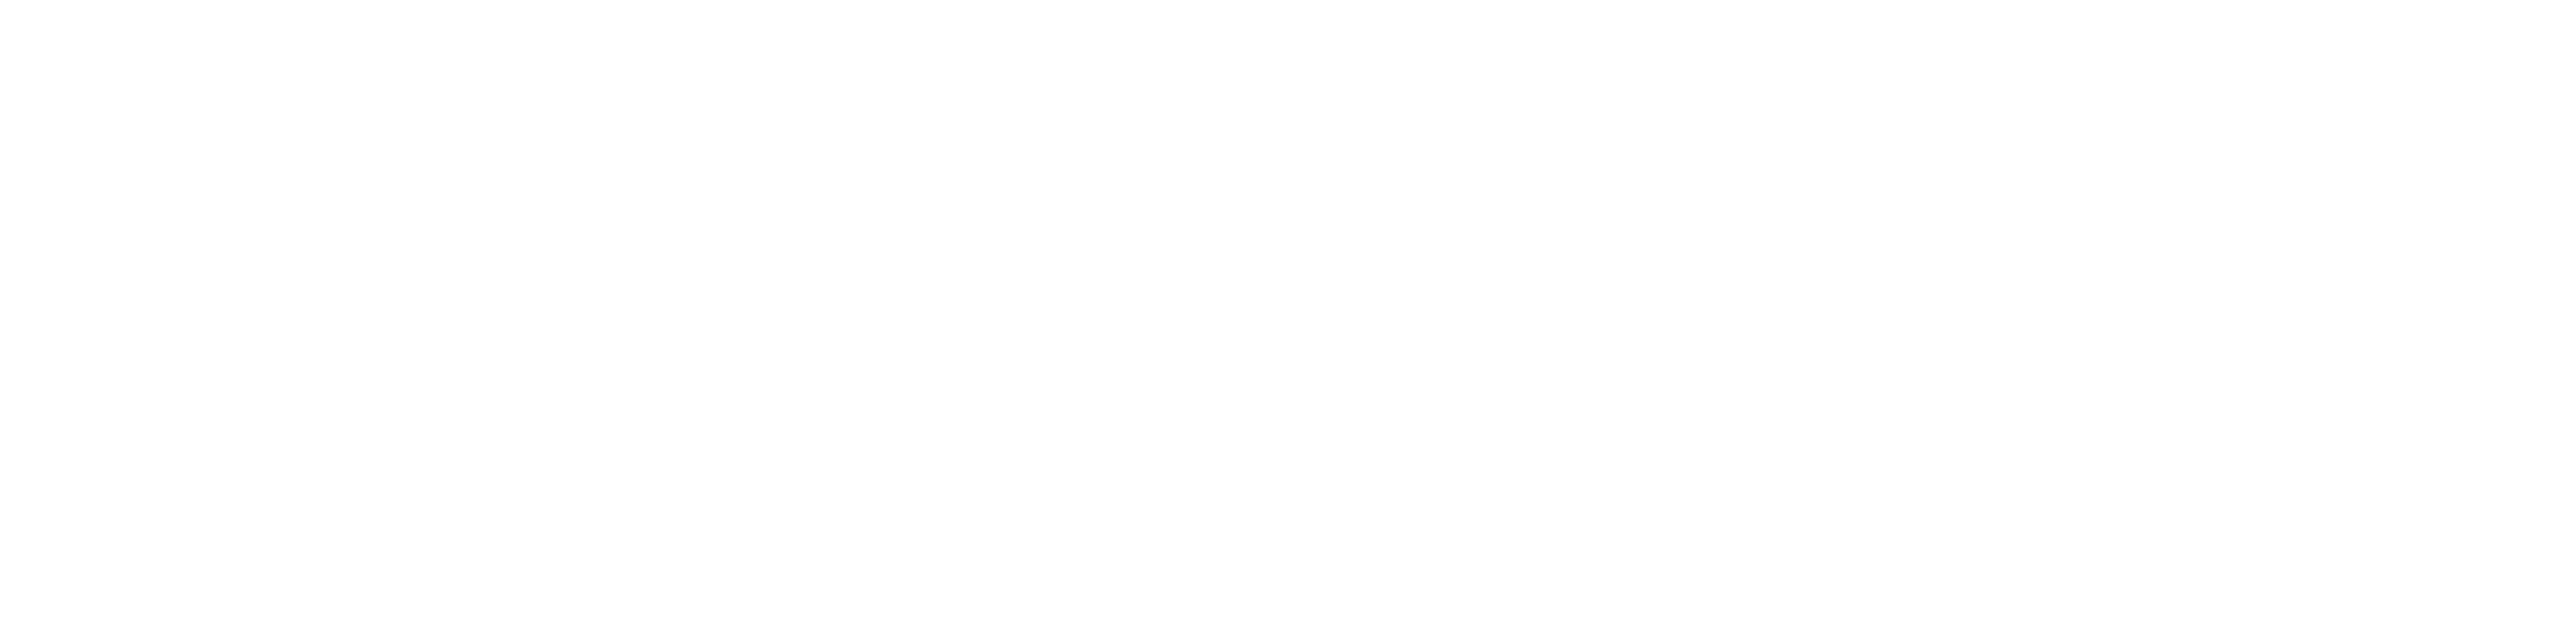

2020-06-10 14:45:54,034 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:46:00,202 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:46:06,596 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:46:12,811 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:46:19,184 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


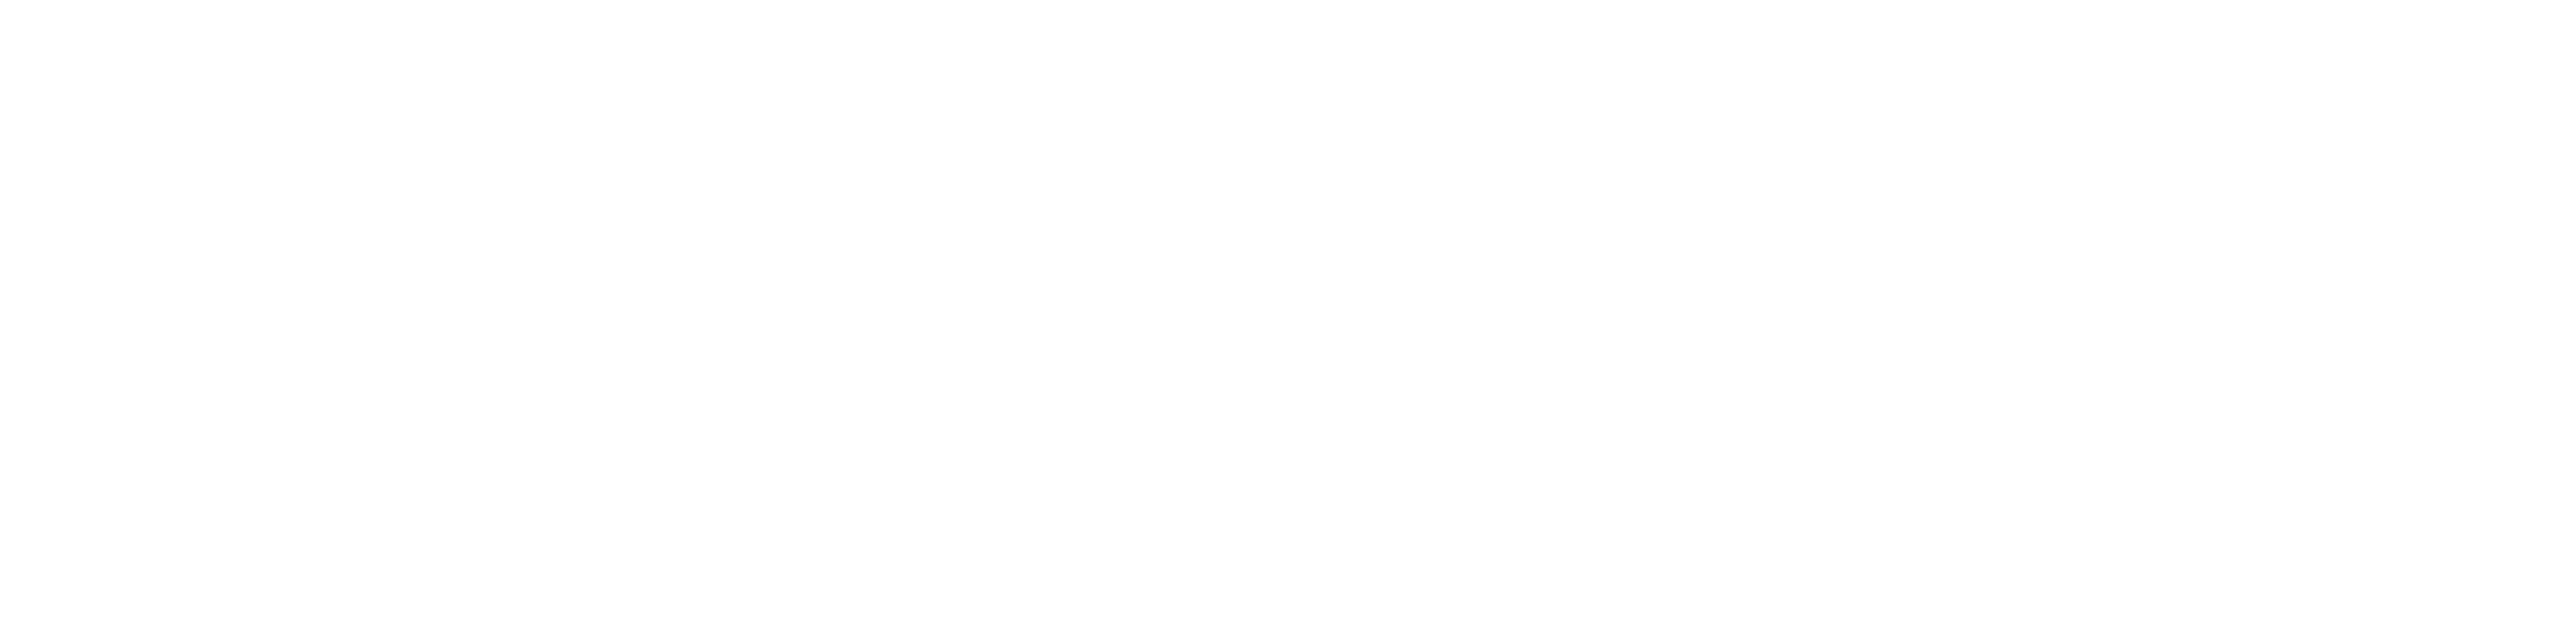

2020-06-10 14:46:43,533 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:46:49,795 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:46:56,002 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:47:02,271 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:47:08,523 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


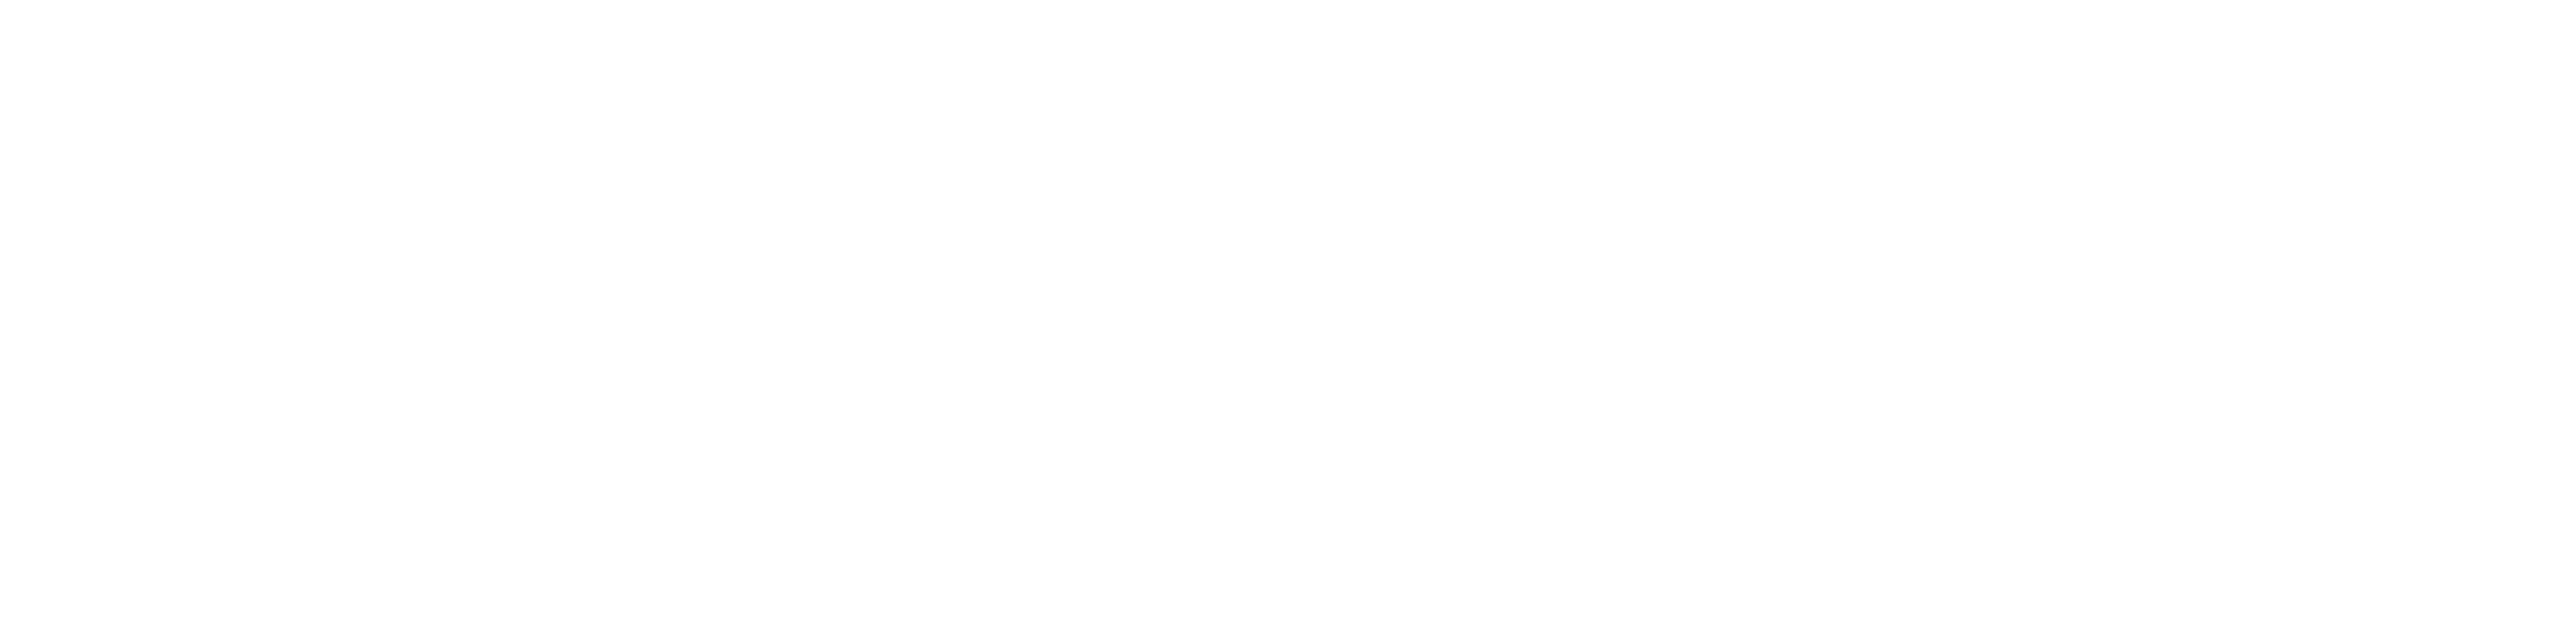

2020-06-10 14:47:32,901 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:47:38,997 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:47:45,138 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:47:51,255 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:47:57,400 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


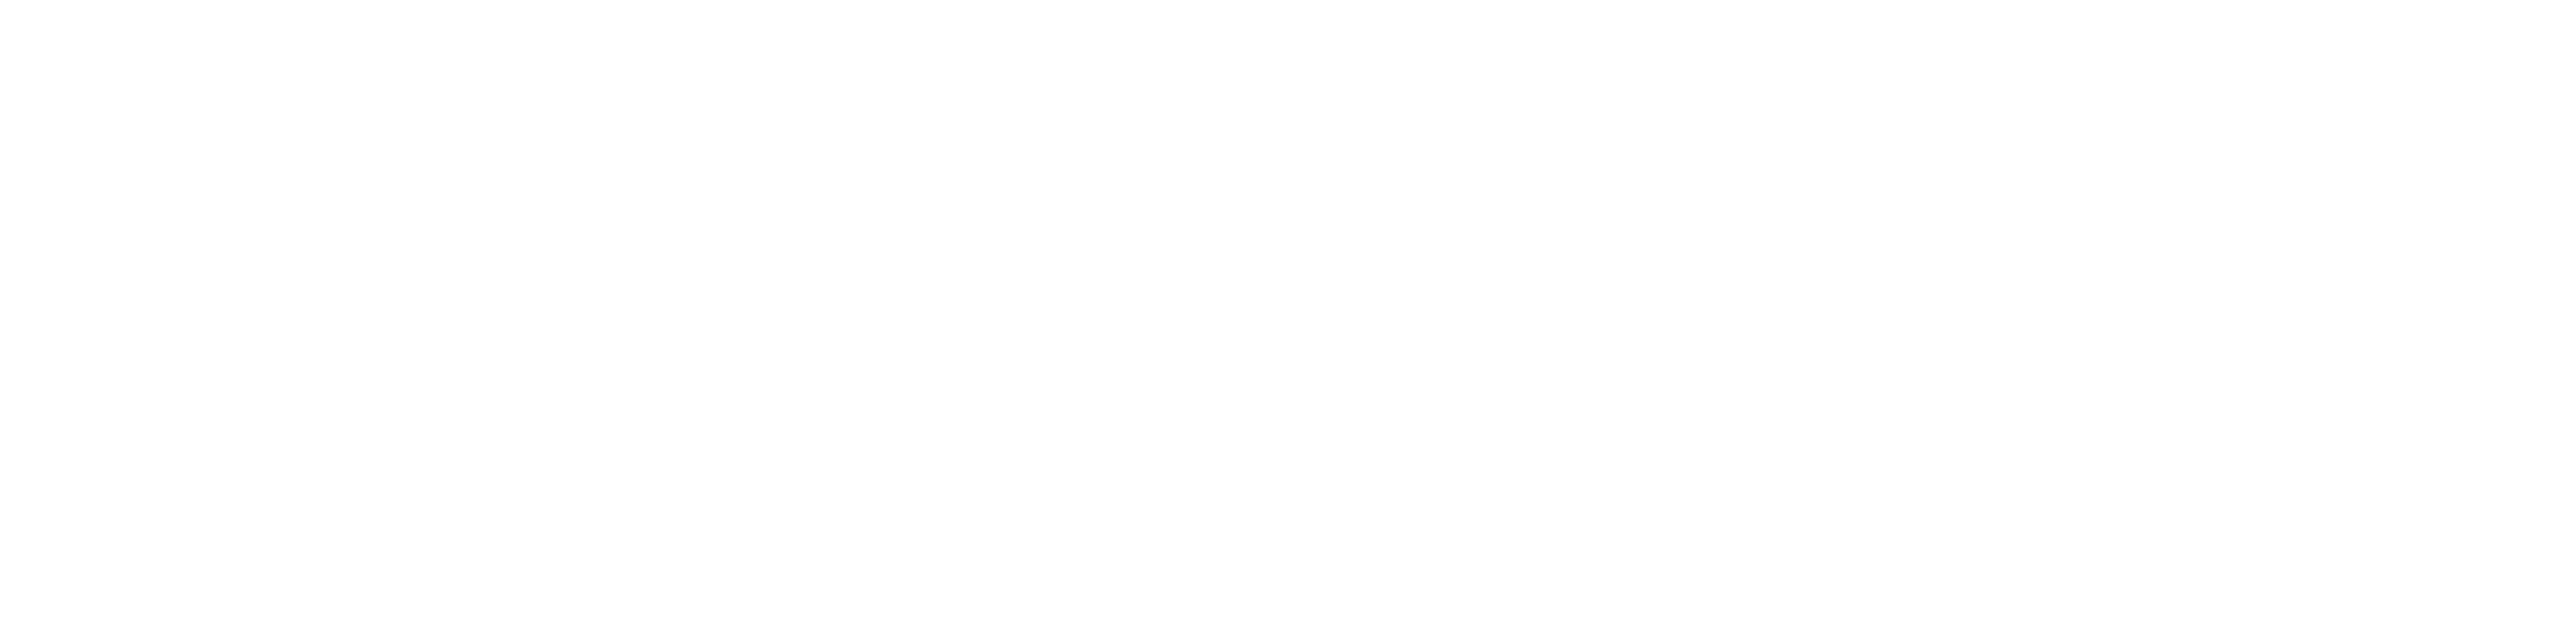

2020-06-10 14:48:21,517 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:48:27,711 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:48:33,967 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:48:40,355 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:48:46,703 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


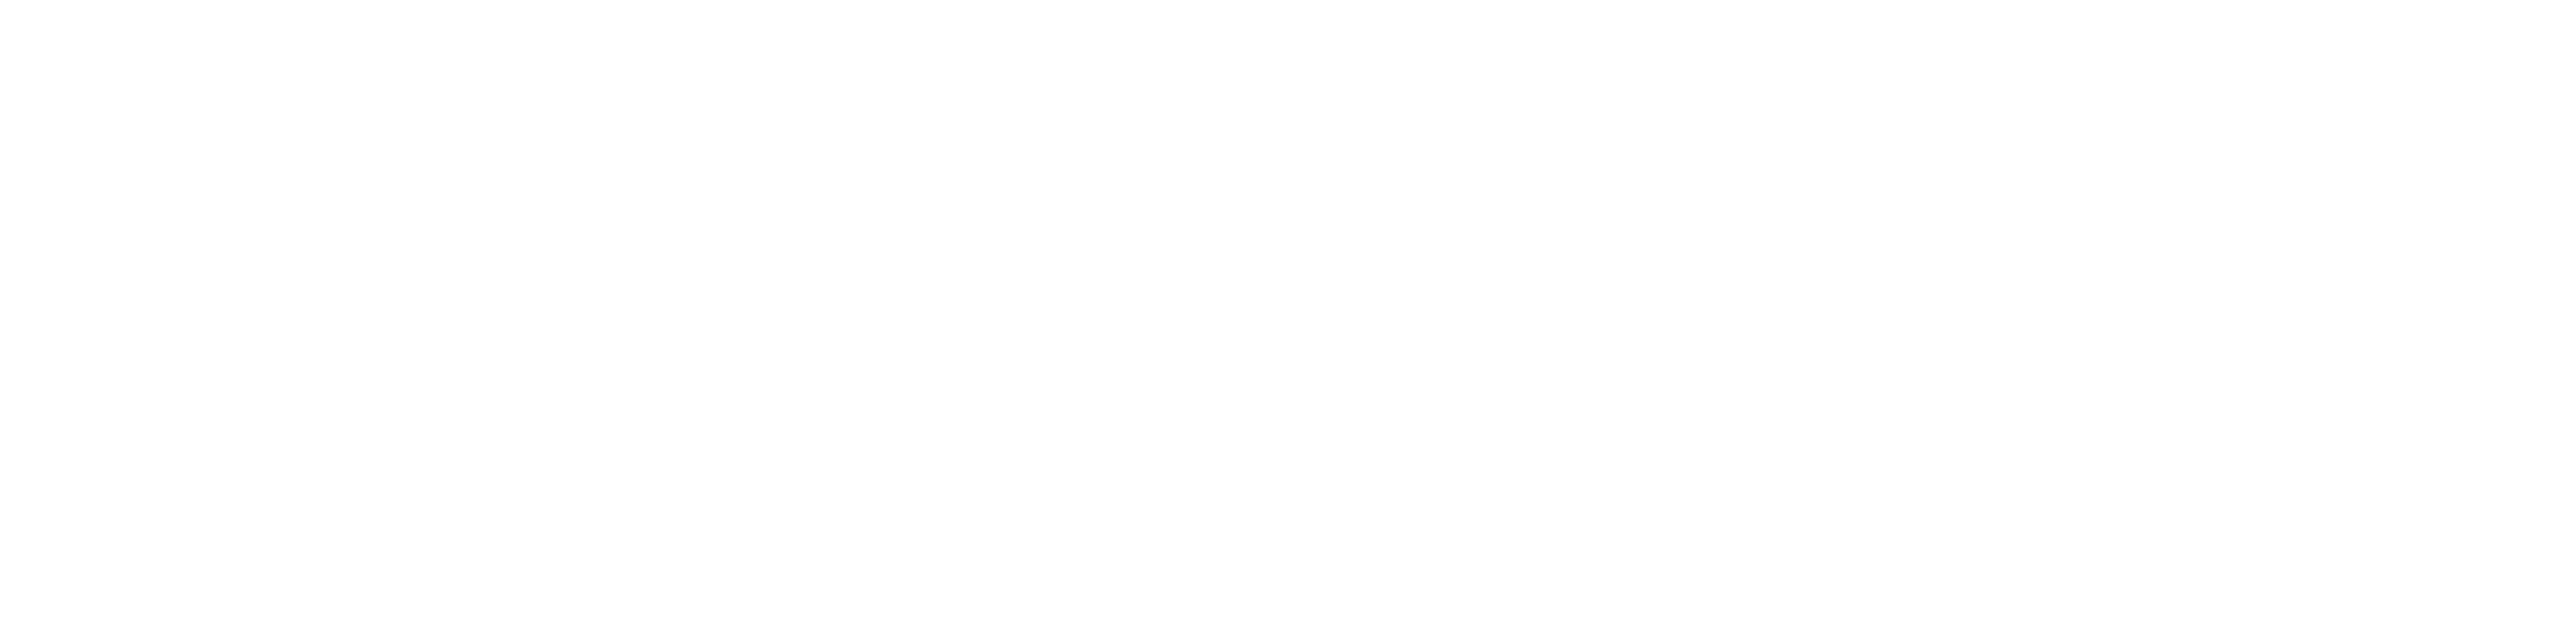

2020-06-10 14:49:10,781 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:49:16,915 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:49:23,586 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:49:29,718 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:49:35,999 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


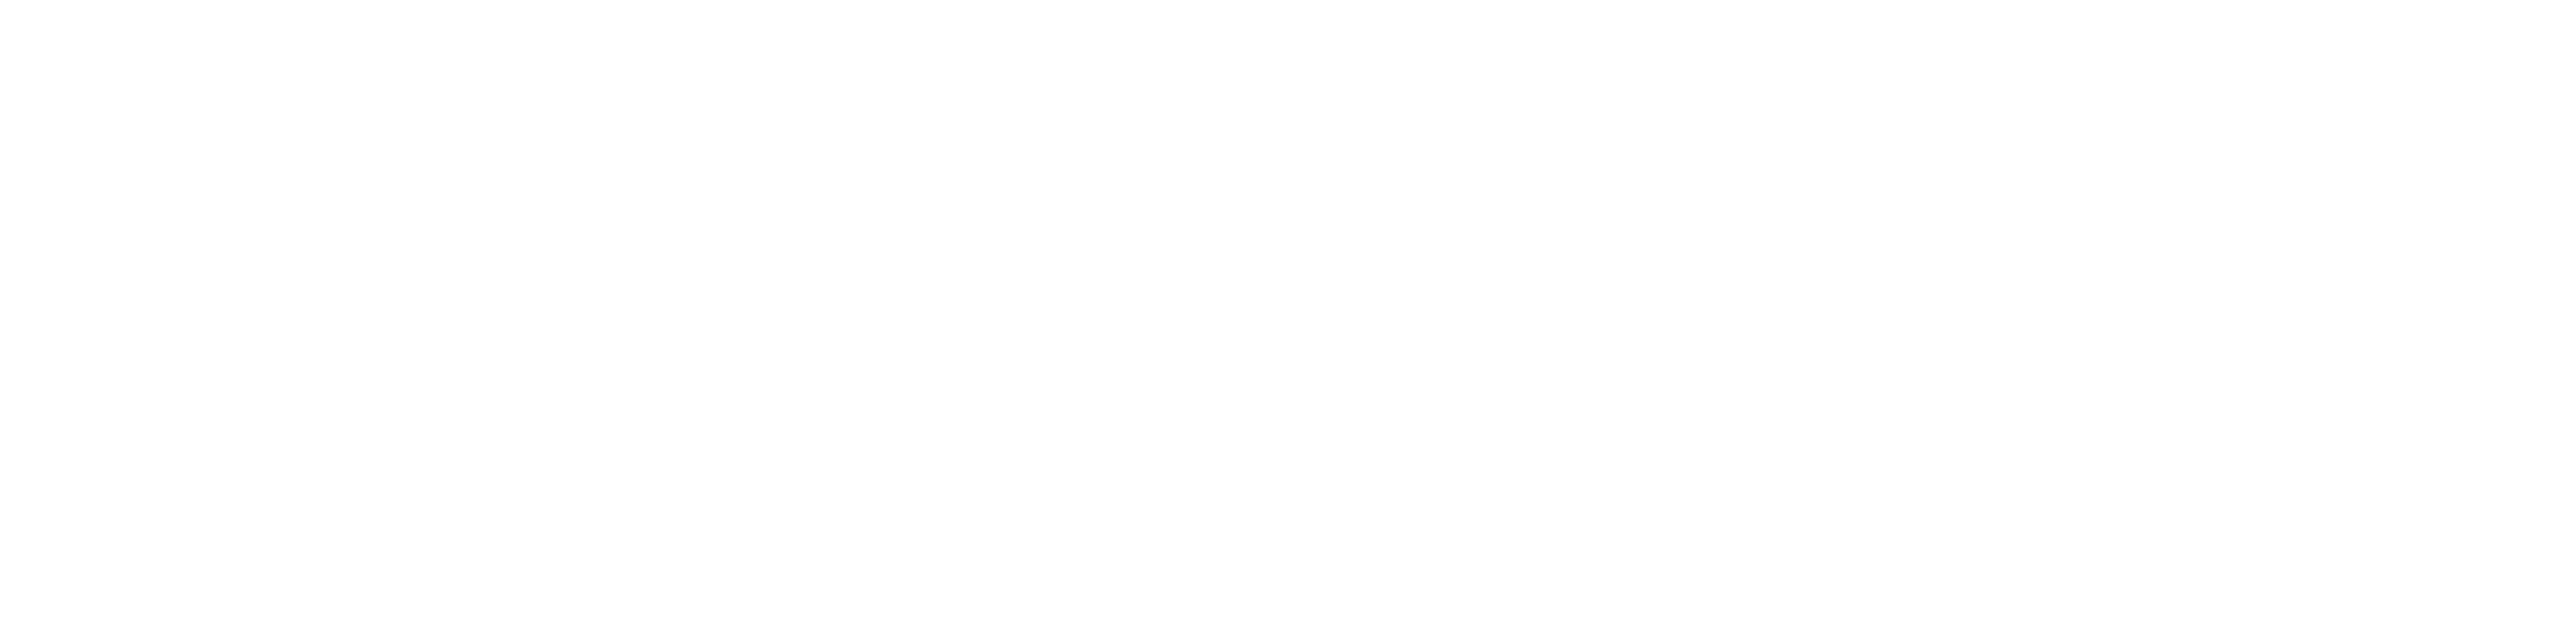

2020-06-10 14:50:00,012 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:50:06,186 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:50:12,291 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:50:18,429 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:50:24,565 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


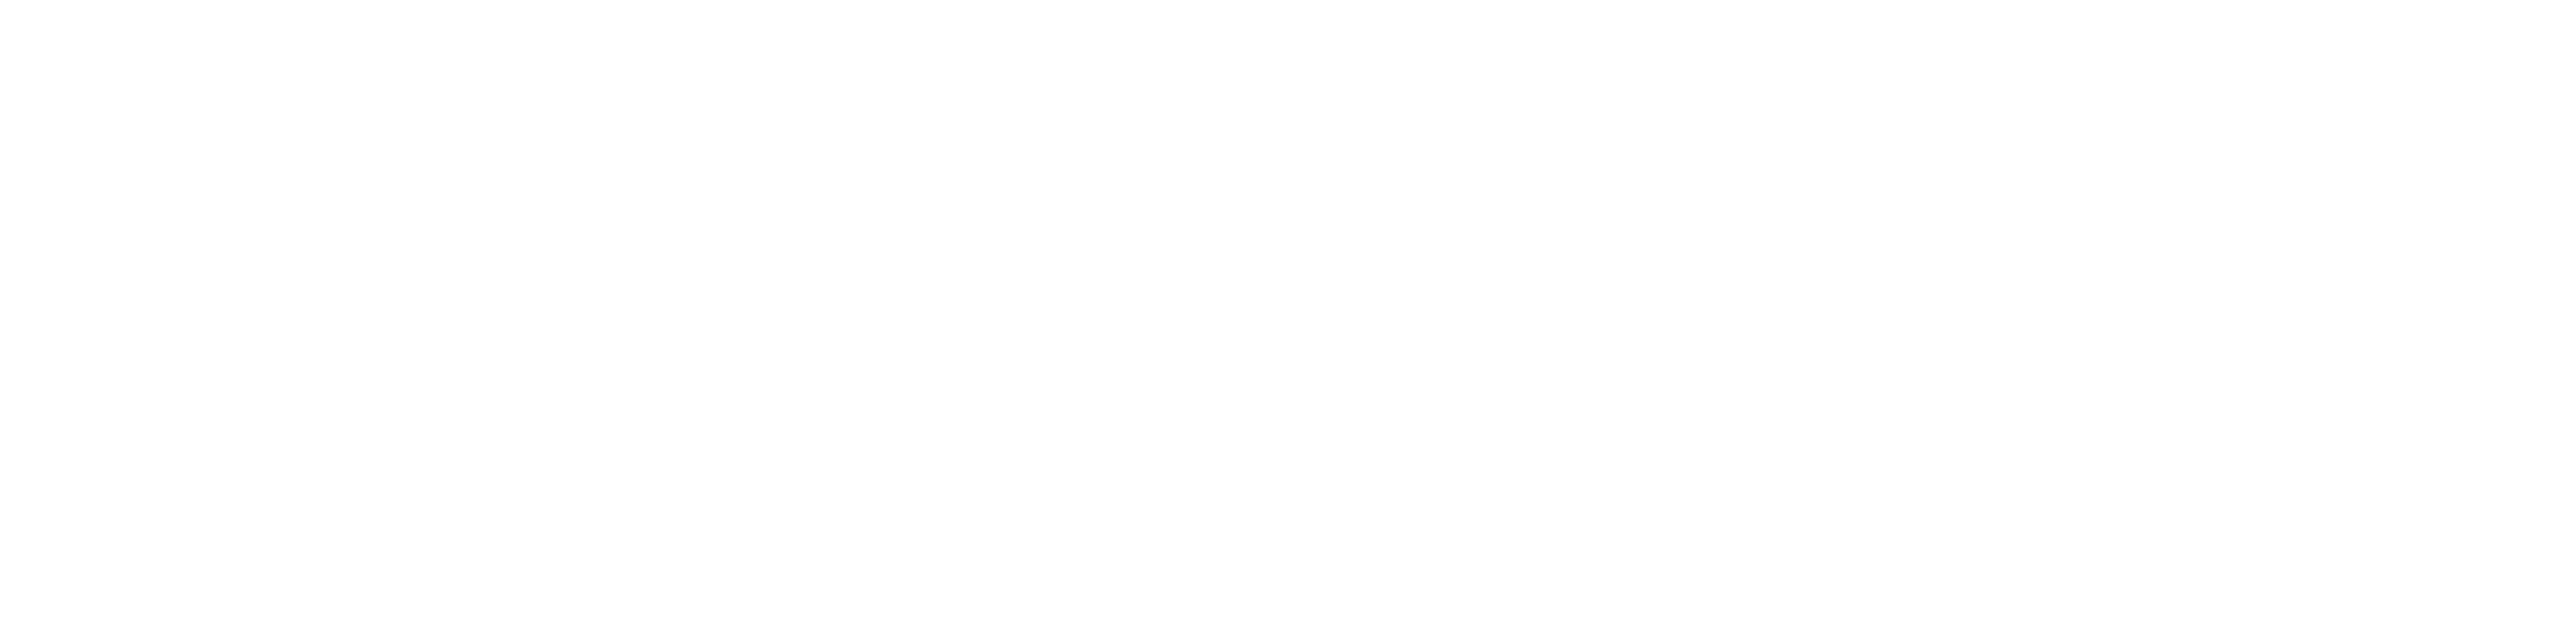

2020-06-10 14:50:48,419 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:50:54,491 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:51:00,610 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:51:06,682 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:51:12,817 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


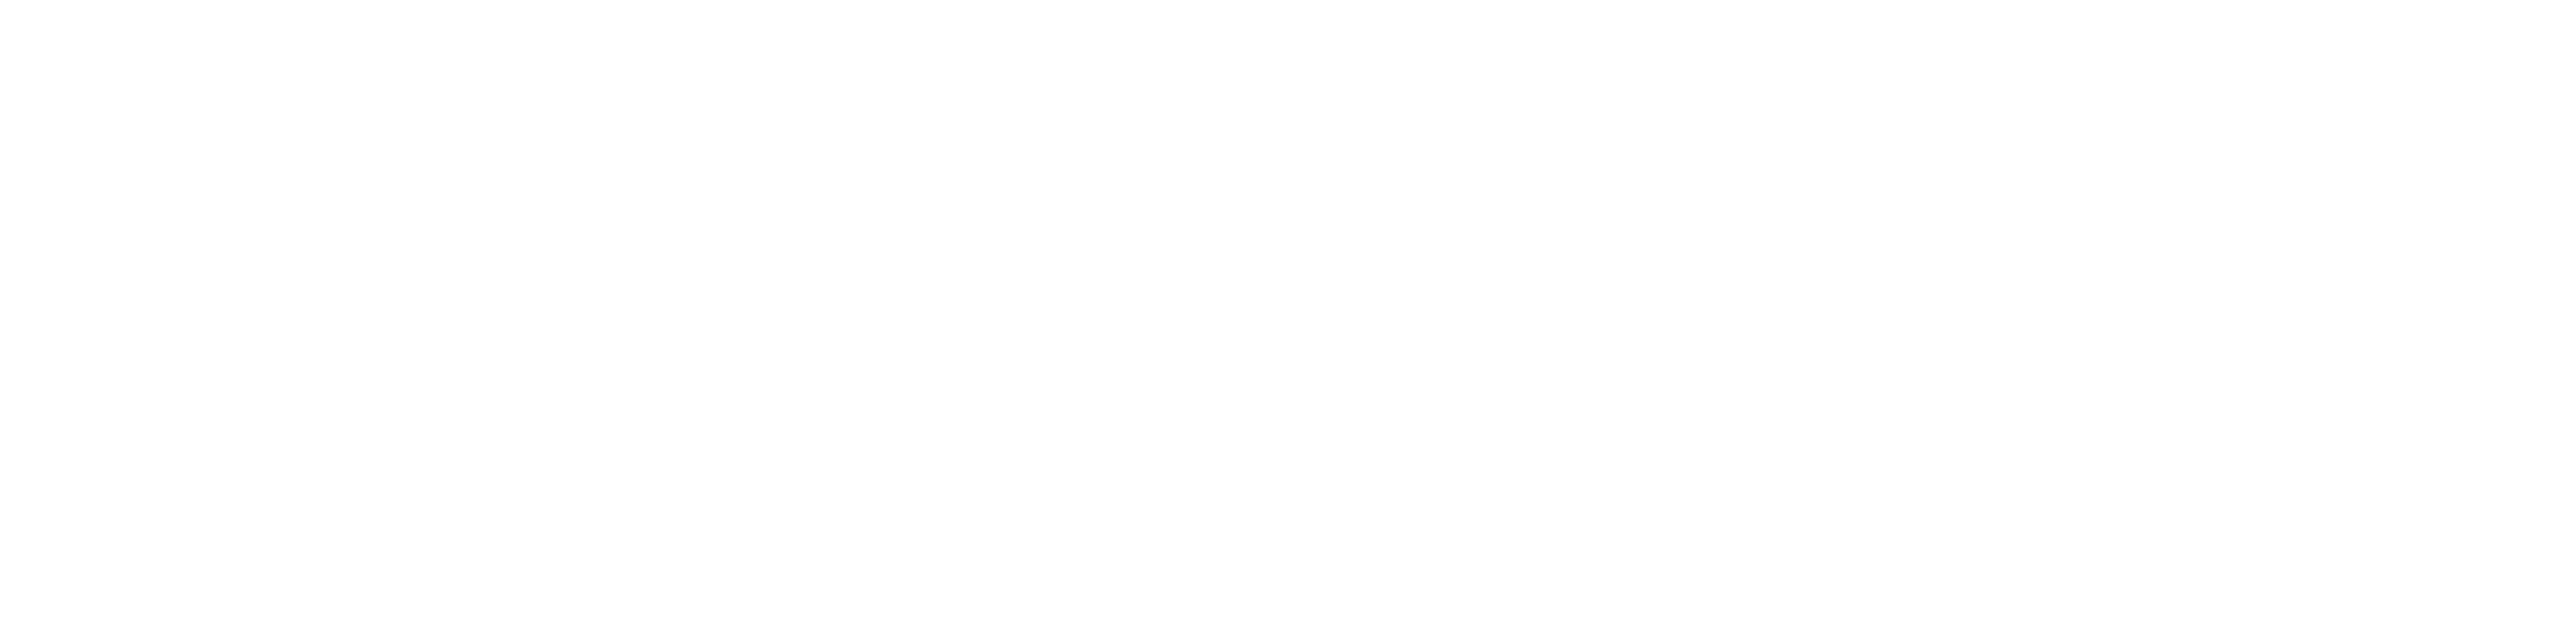

2020-06-10 14:51:36,682 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:51:42,744 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:51:48,869 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:51:54,976 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:52:01,069 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


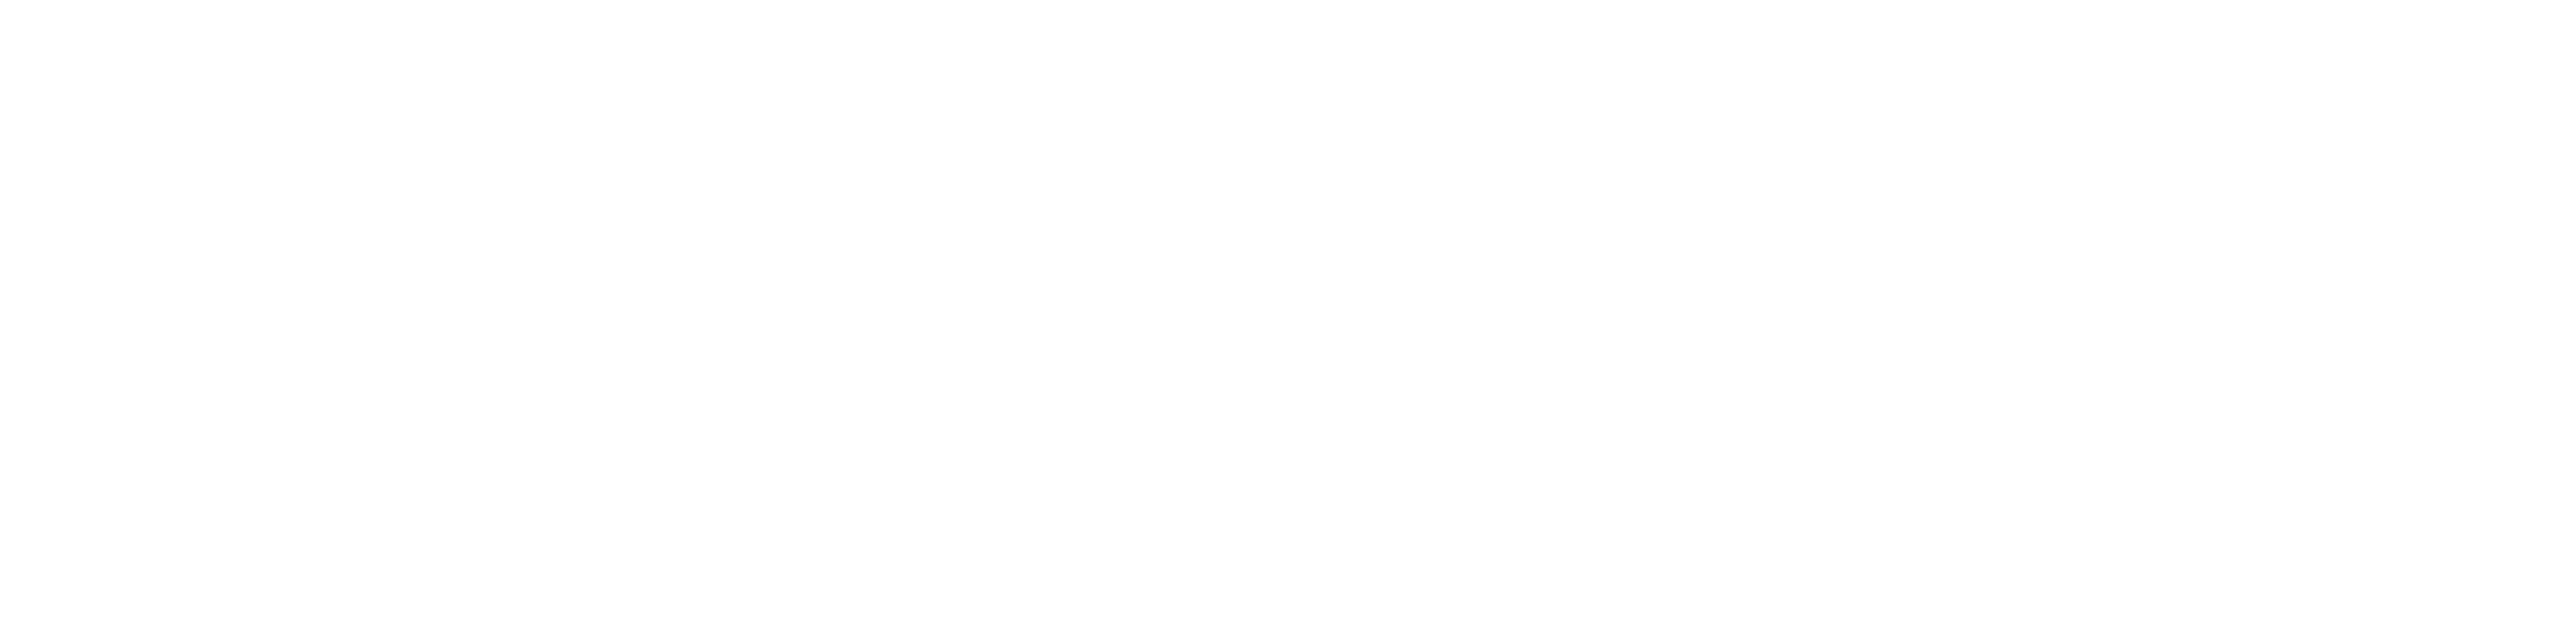

2020-06-10 14:52:25,025 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:52:31,128 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:52:37,204 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:52:43,321 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:52:49,406 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


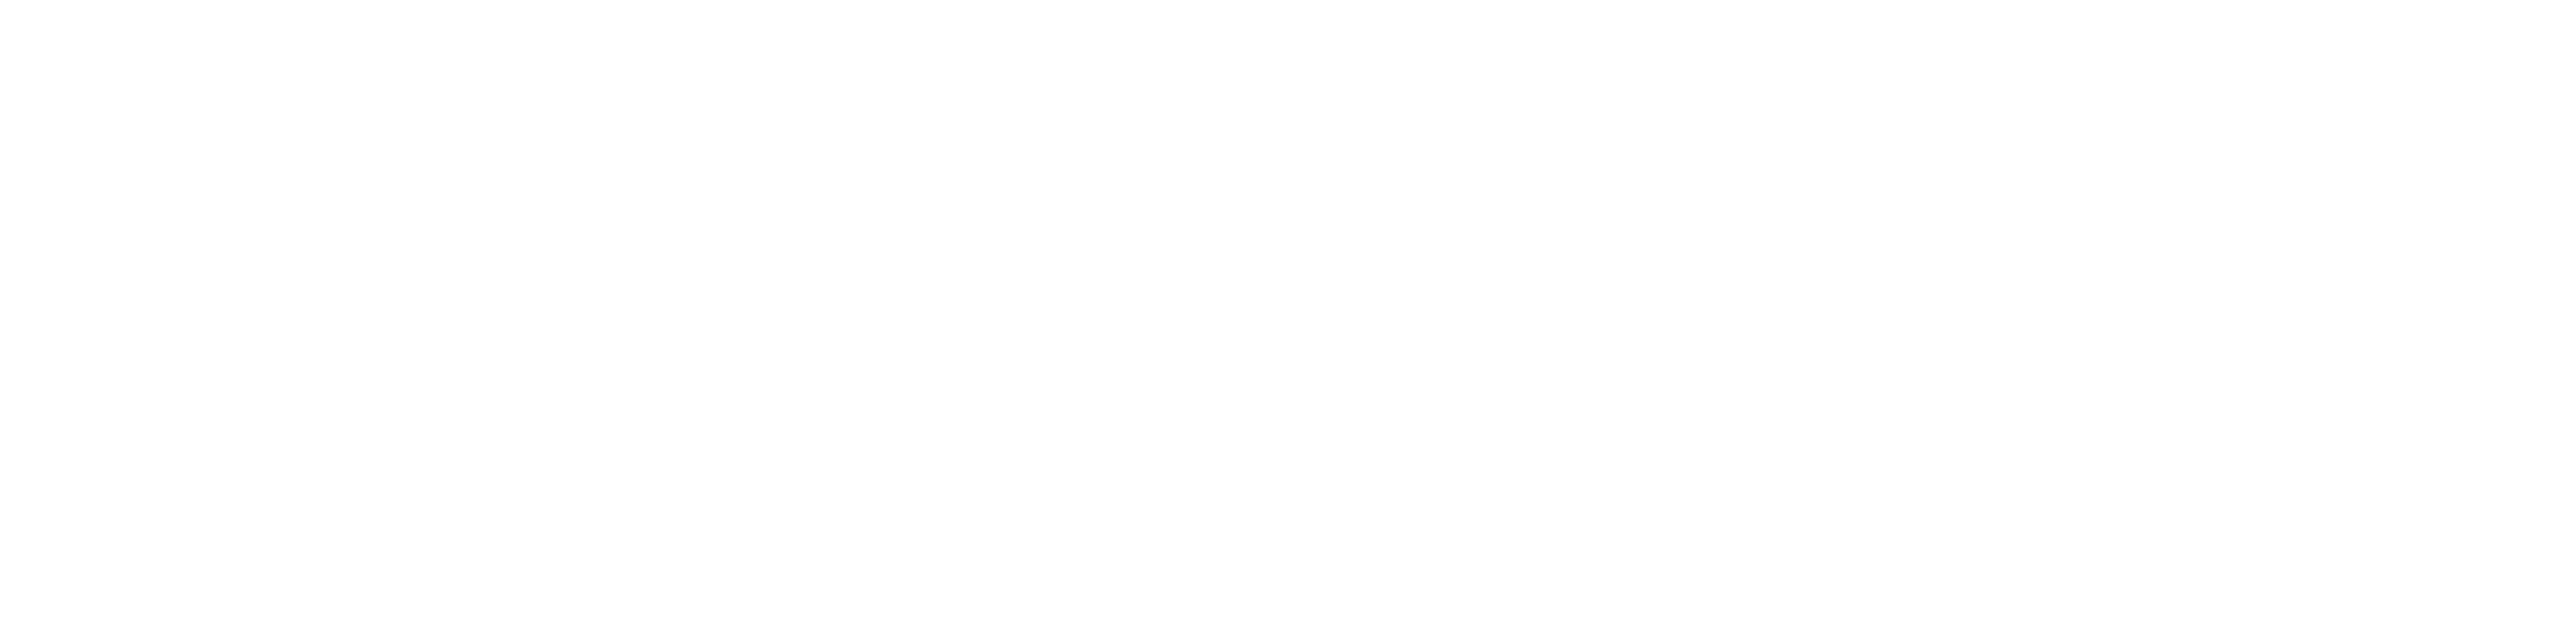

2020-06-10 14:53:13,267 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:53:19,334 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:53:25,468 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:53:31,543 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:53:37,664 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


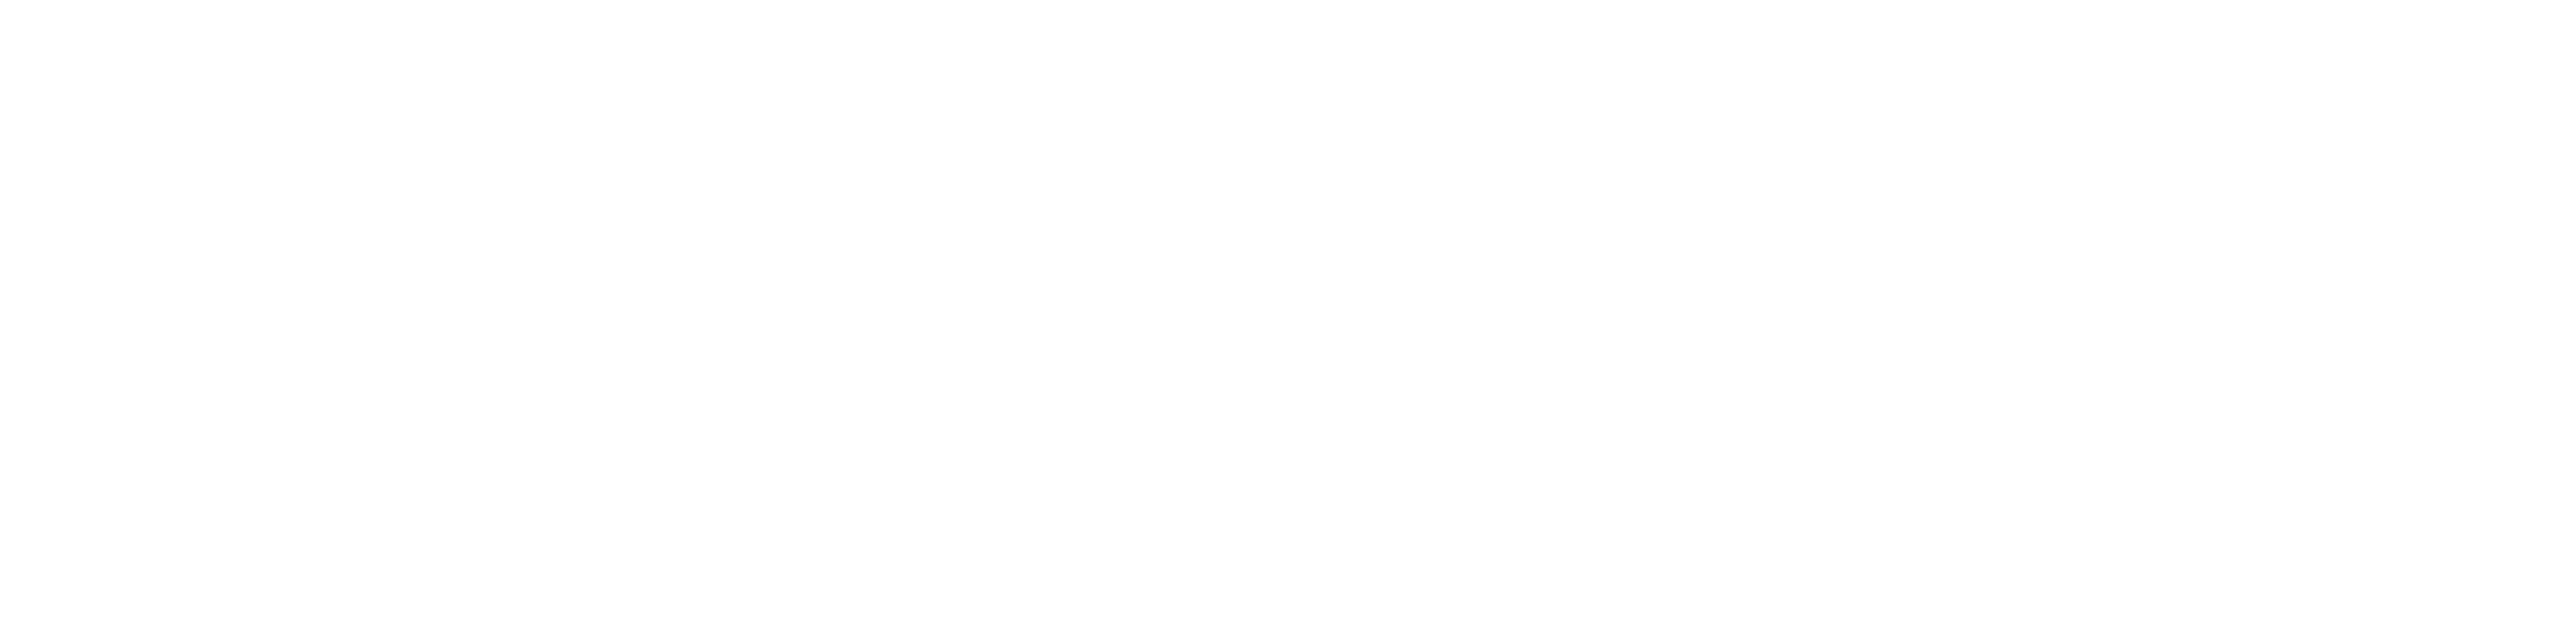

2020-06-10 14:54:01,457 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:54:07,631 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:54:13,705 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:54:19,816 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:54:25,930 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


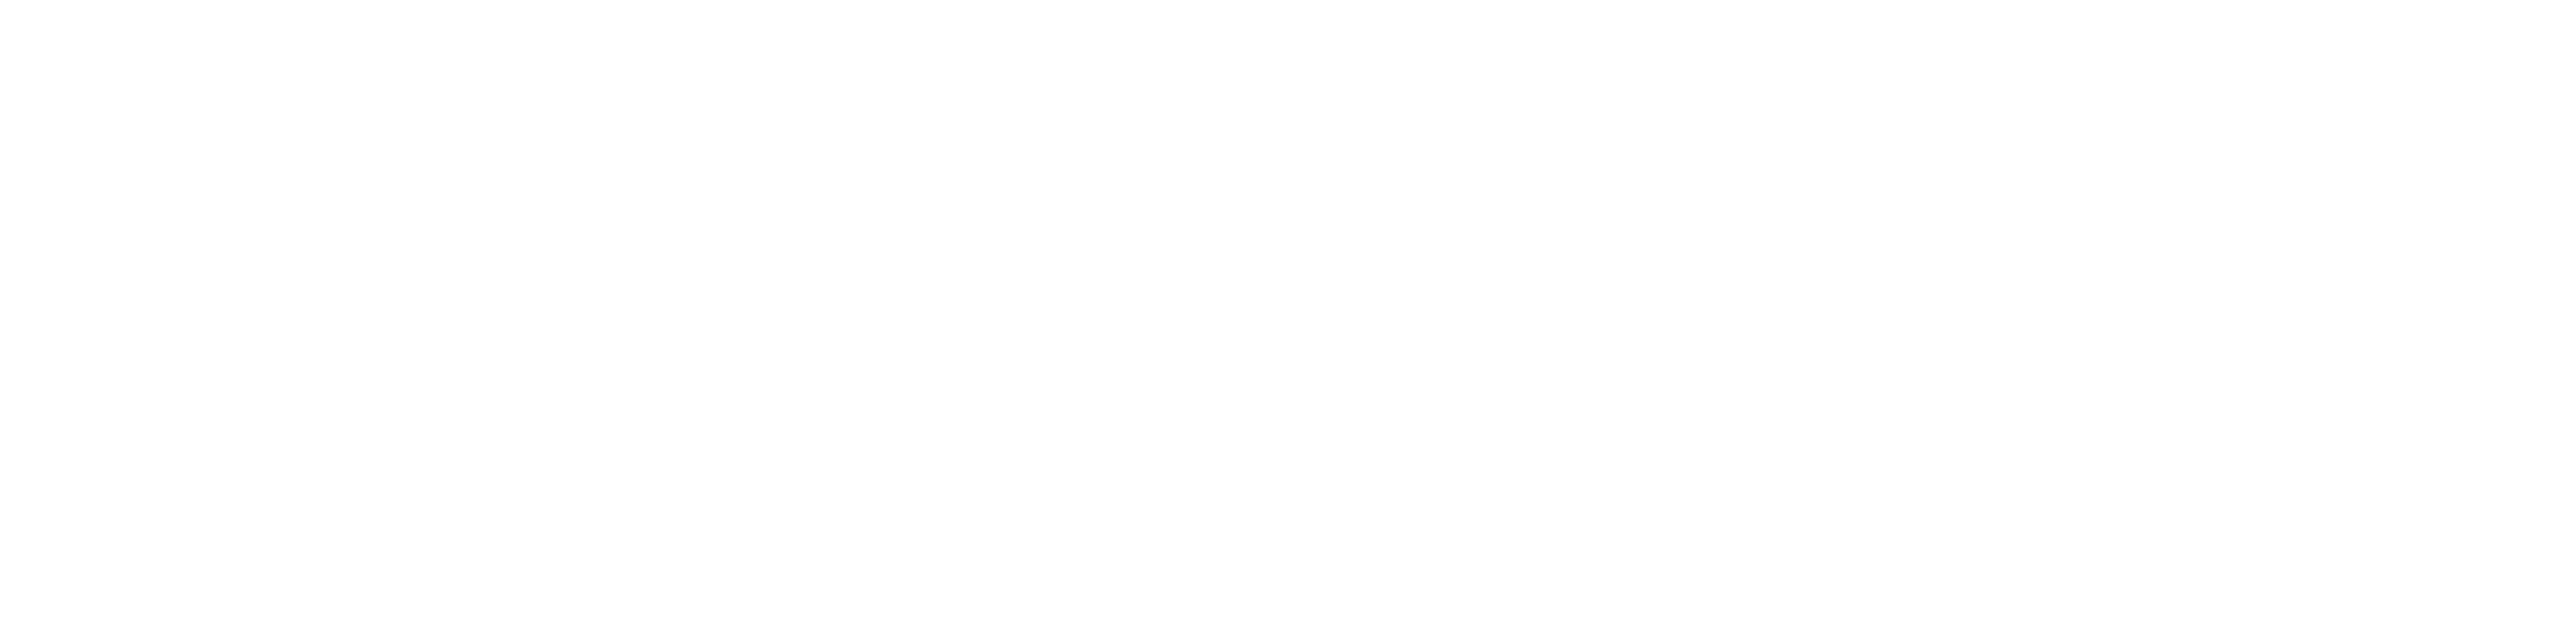

2020-06-10 14:54:49,885 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:54:55,956 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:55:02,067 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:55:08,154 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:55:14,291 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


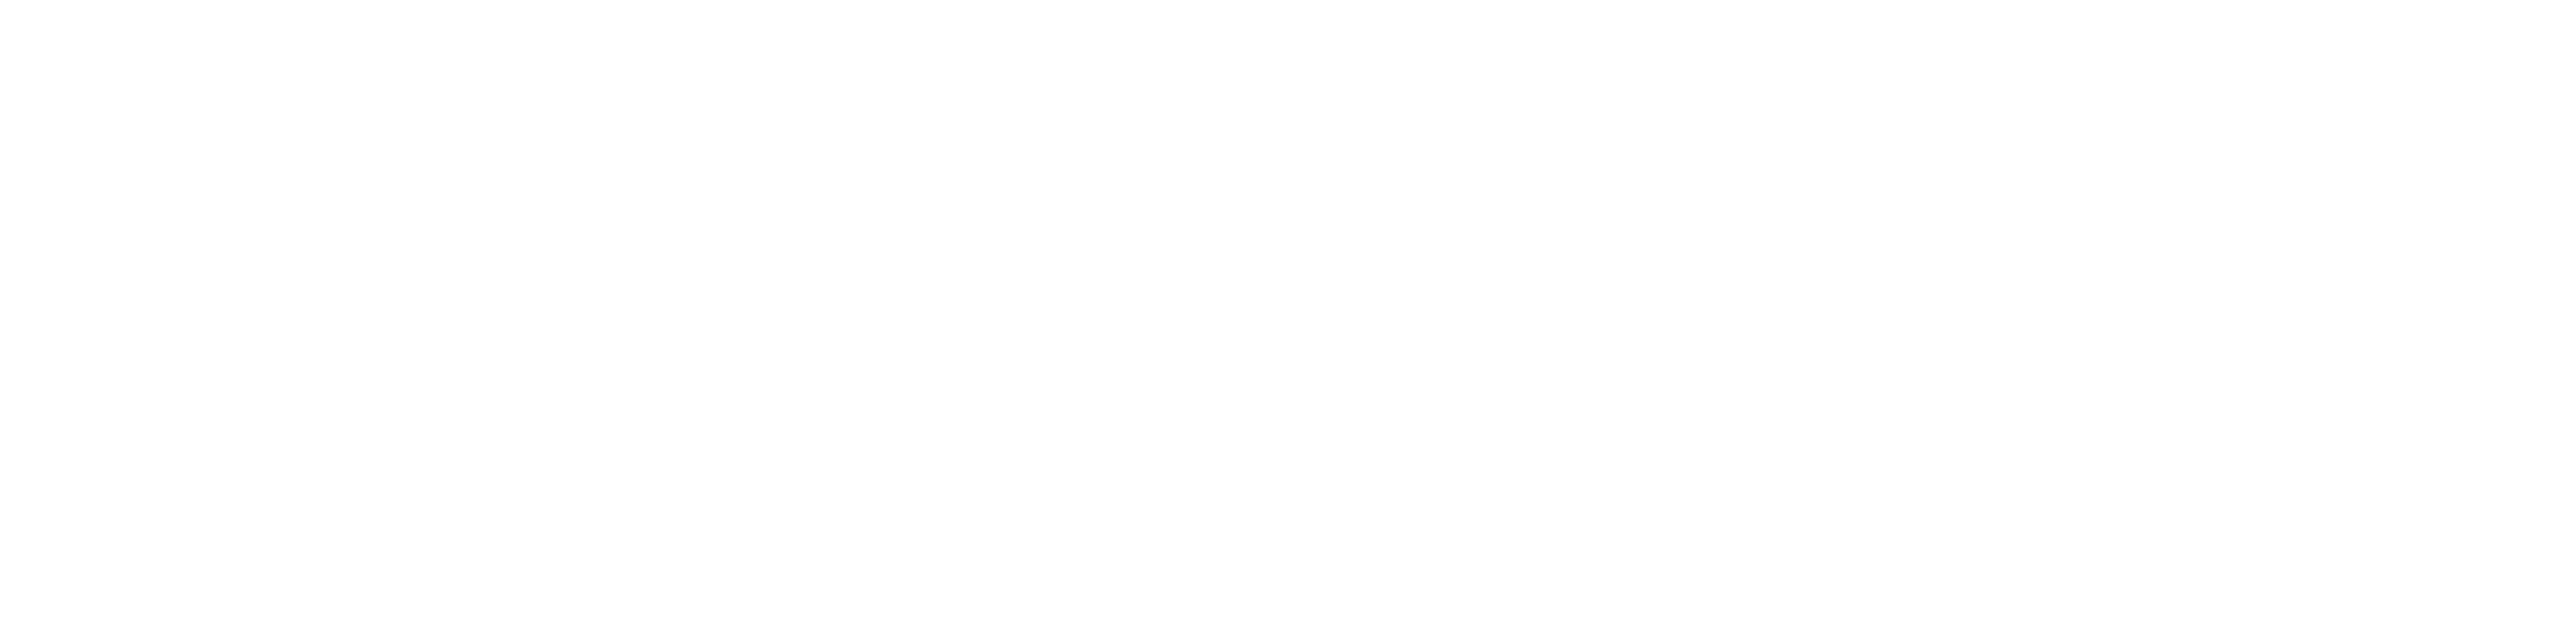

2020-06-10 14:55:38,137 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:55:44,304 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:55:50,390 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:55:56,506 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:56:02,609 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


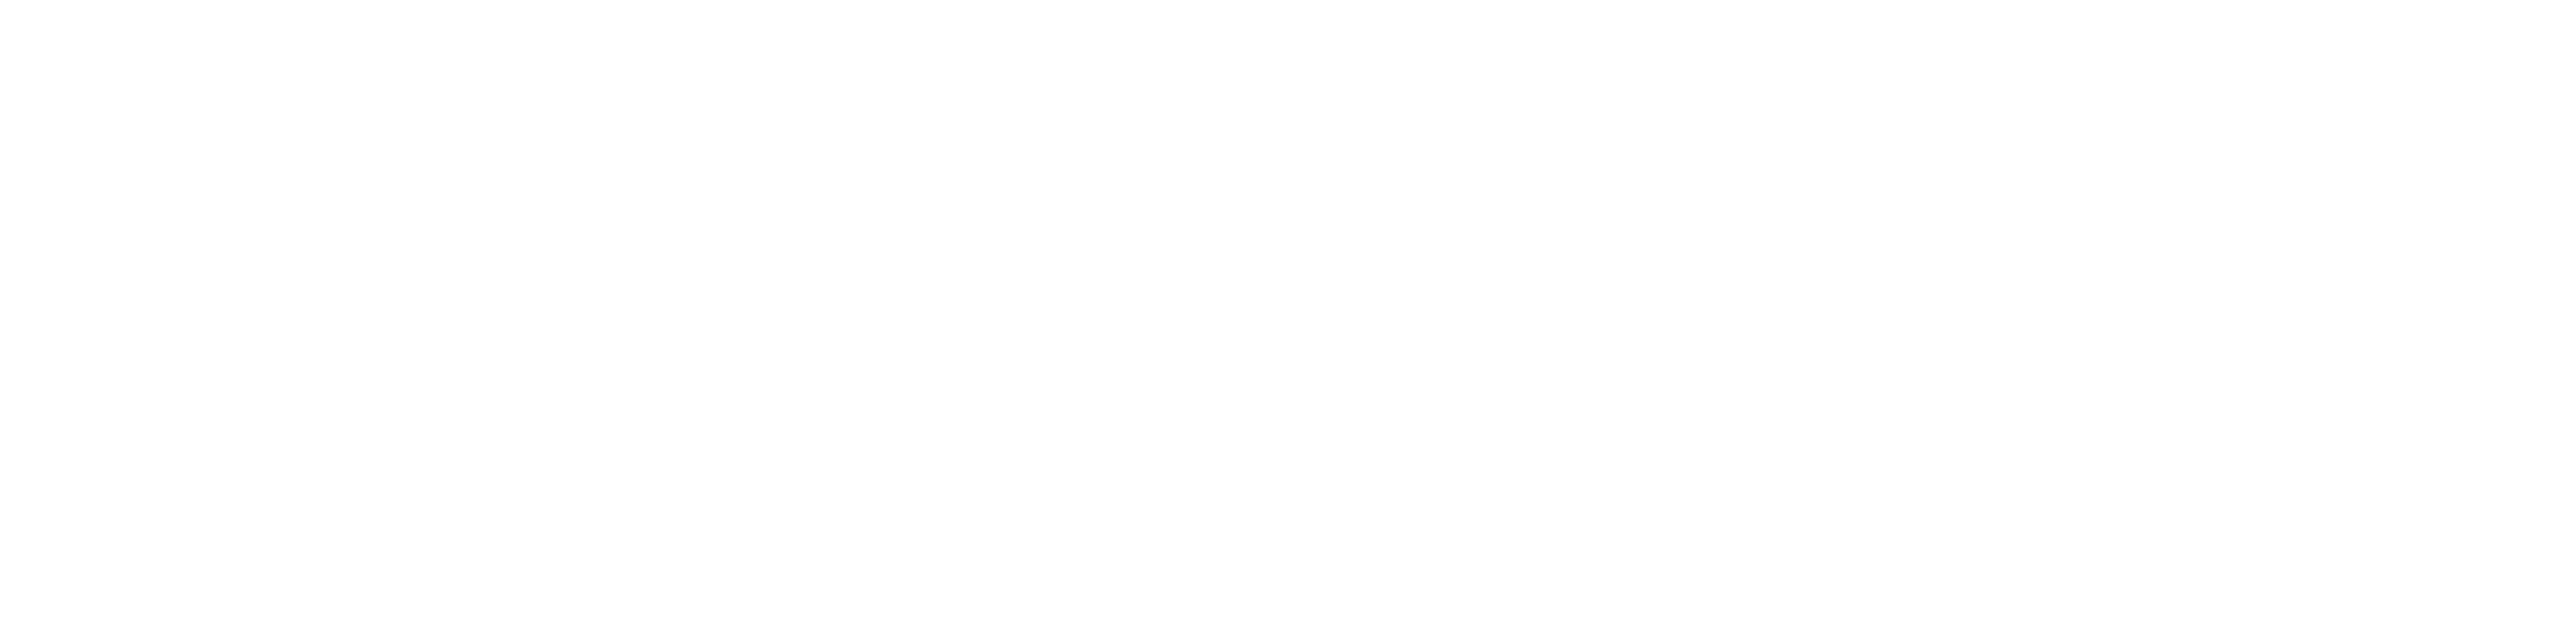

2020-06-10 14:56:26,555 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:56:32,615 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:56:38,737 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:56:44,834 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:56:50,951 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


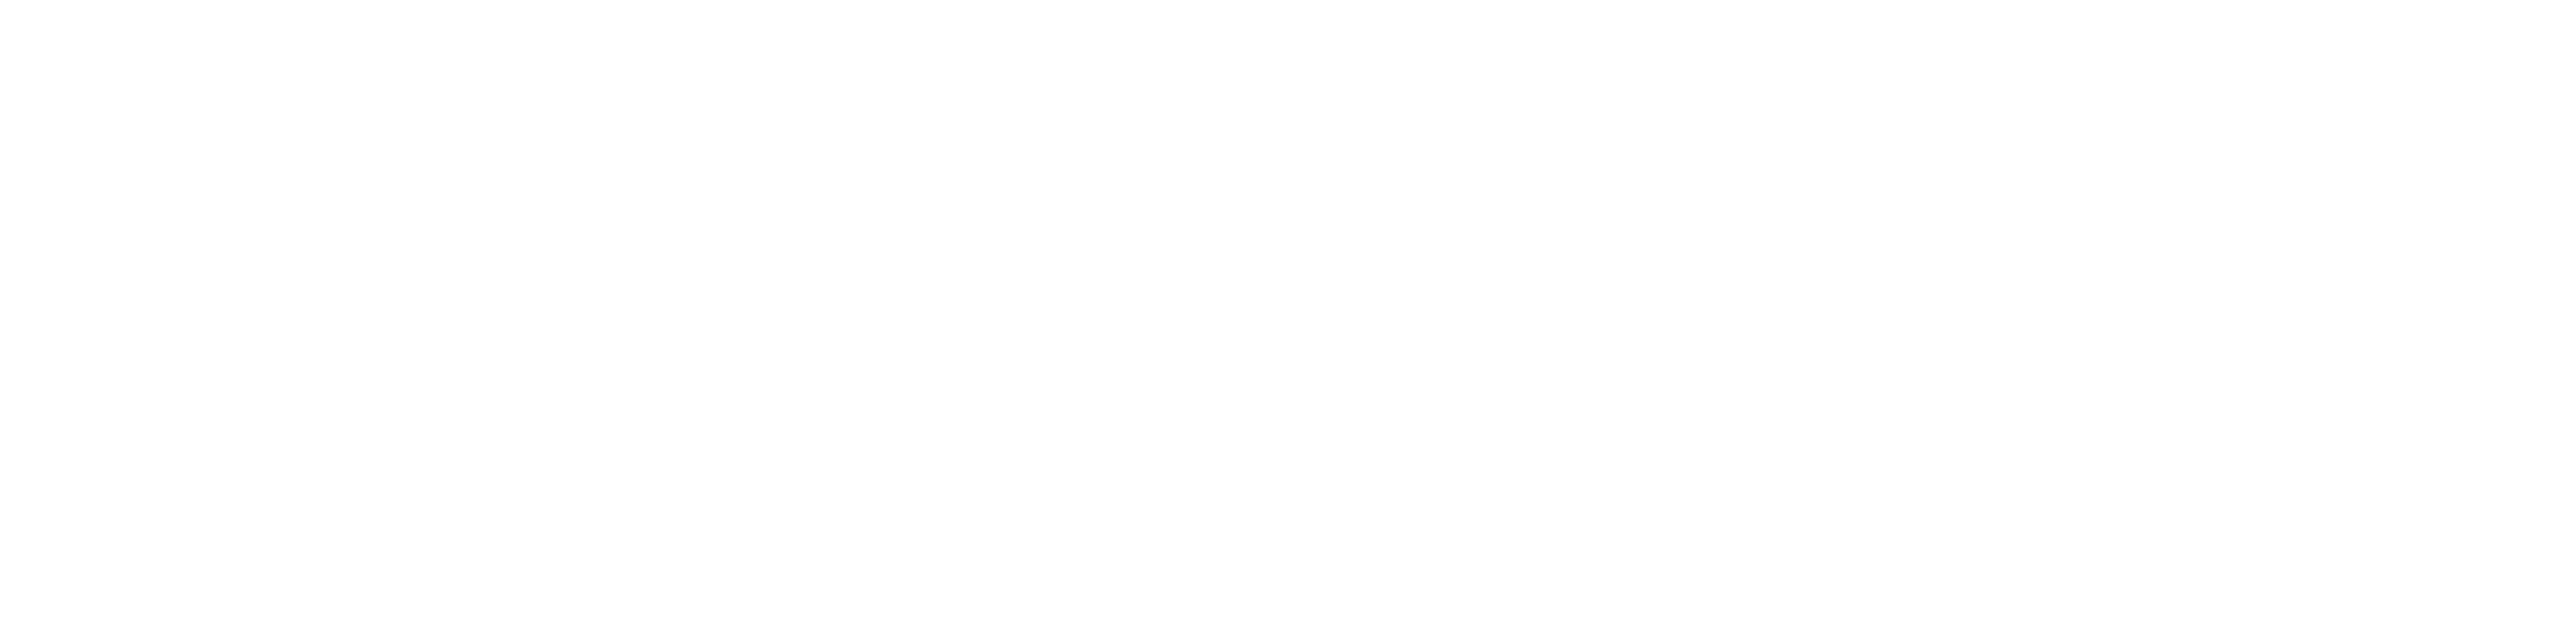

2020-06-10 14:57:14,861 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:57:20,916 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:57:27,045 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:57:33,122 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:57:39,237 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


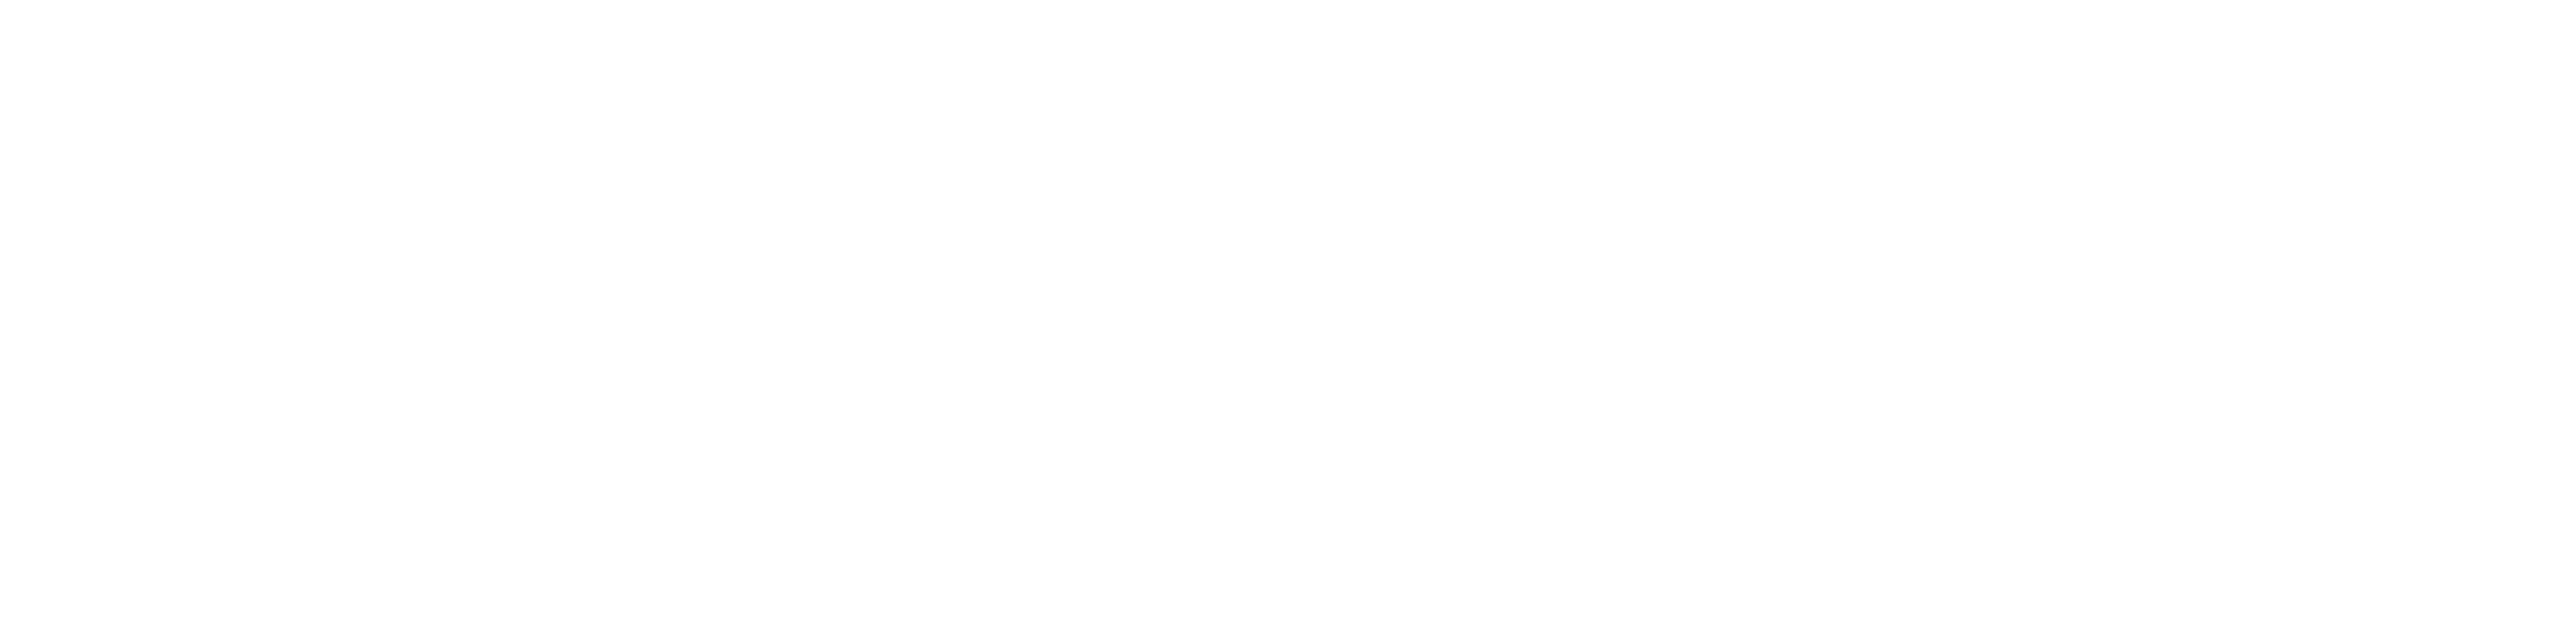

2020-06-10 14:58:03,161 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:58:09,283 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:58:15,362 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:58:21,473 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:58:27,561 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


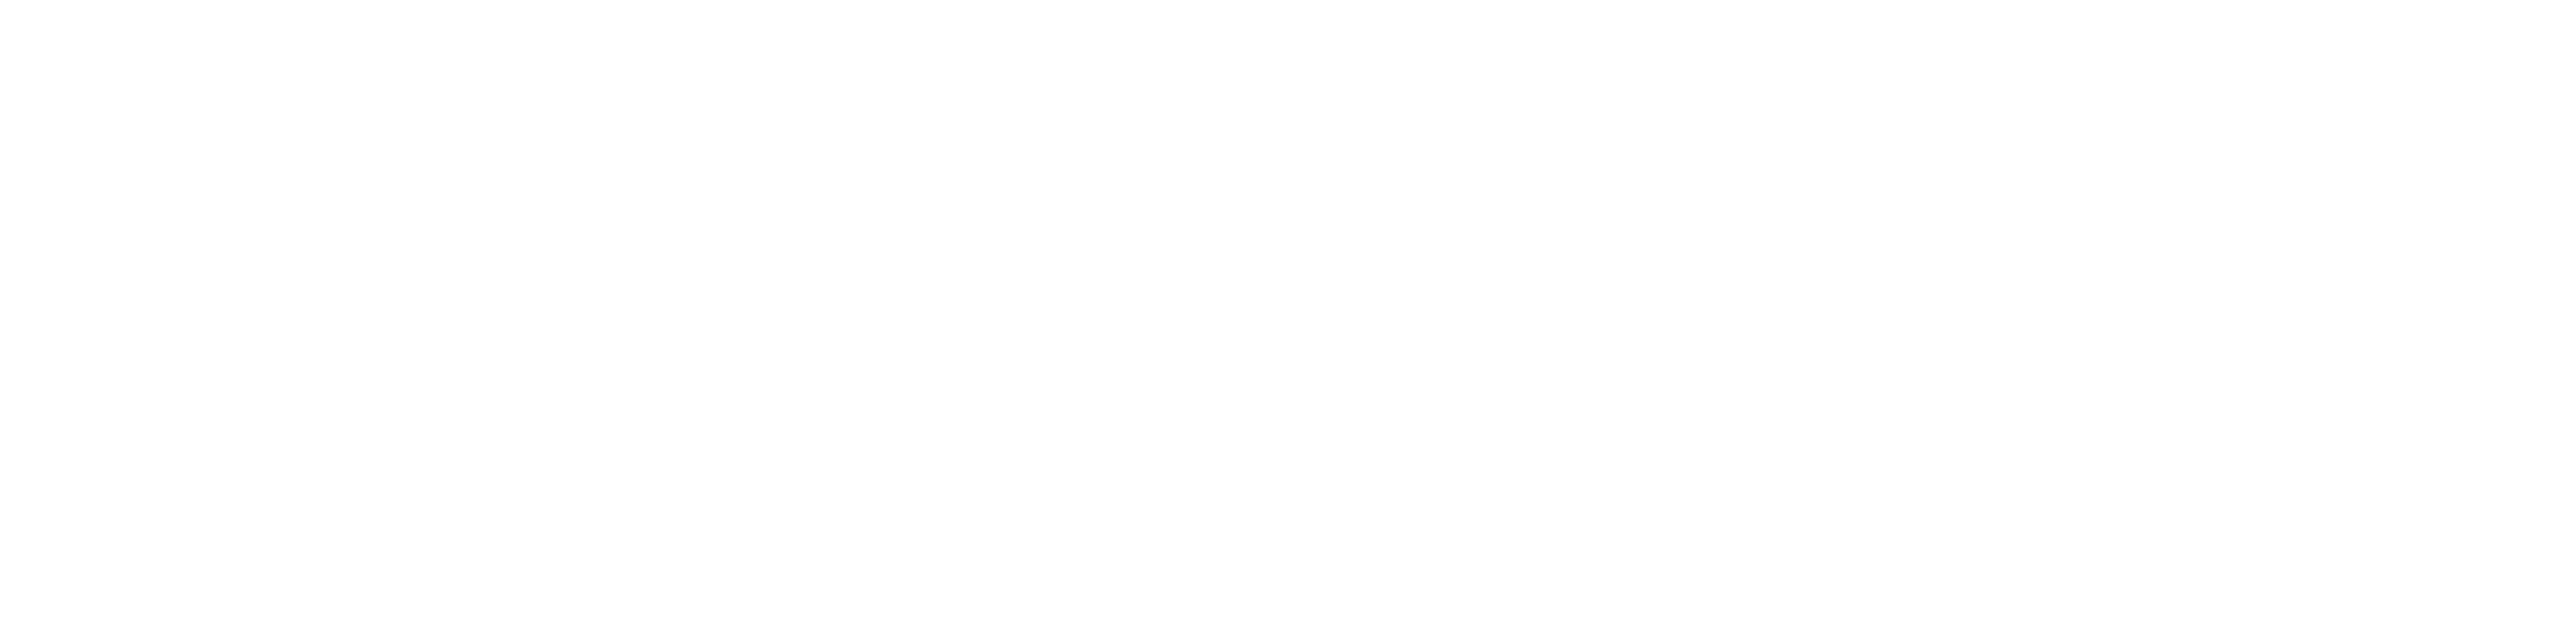

2020-06-10 14:58:51,382 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:58:57,455 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:59:03,576 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:59:09,651 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:59:15,764 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


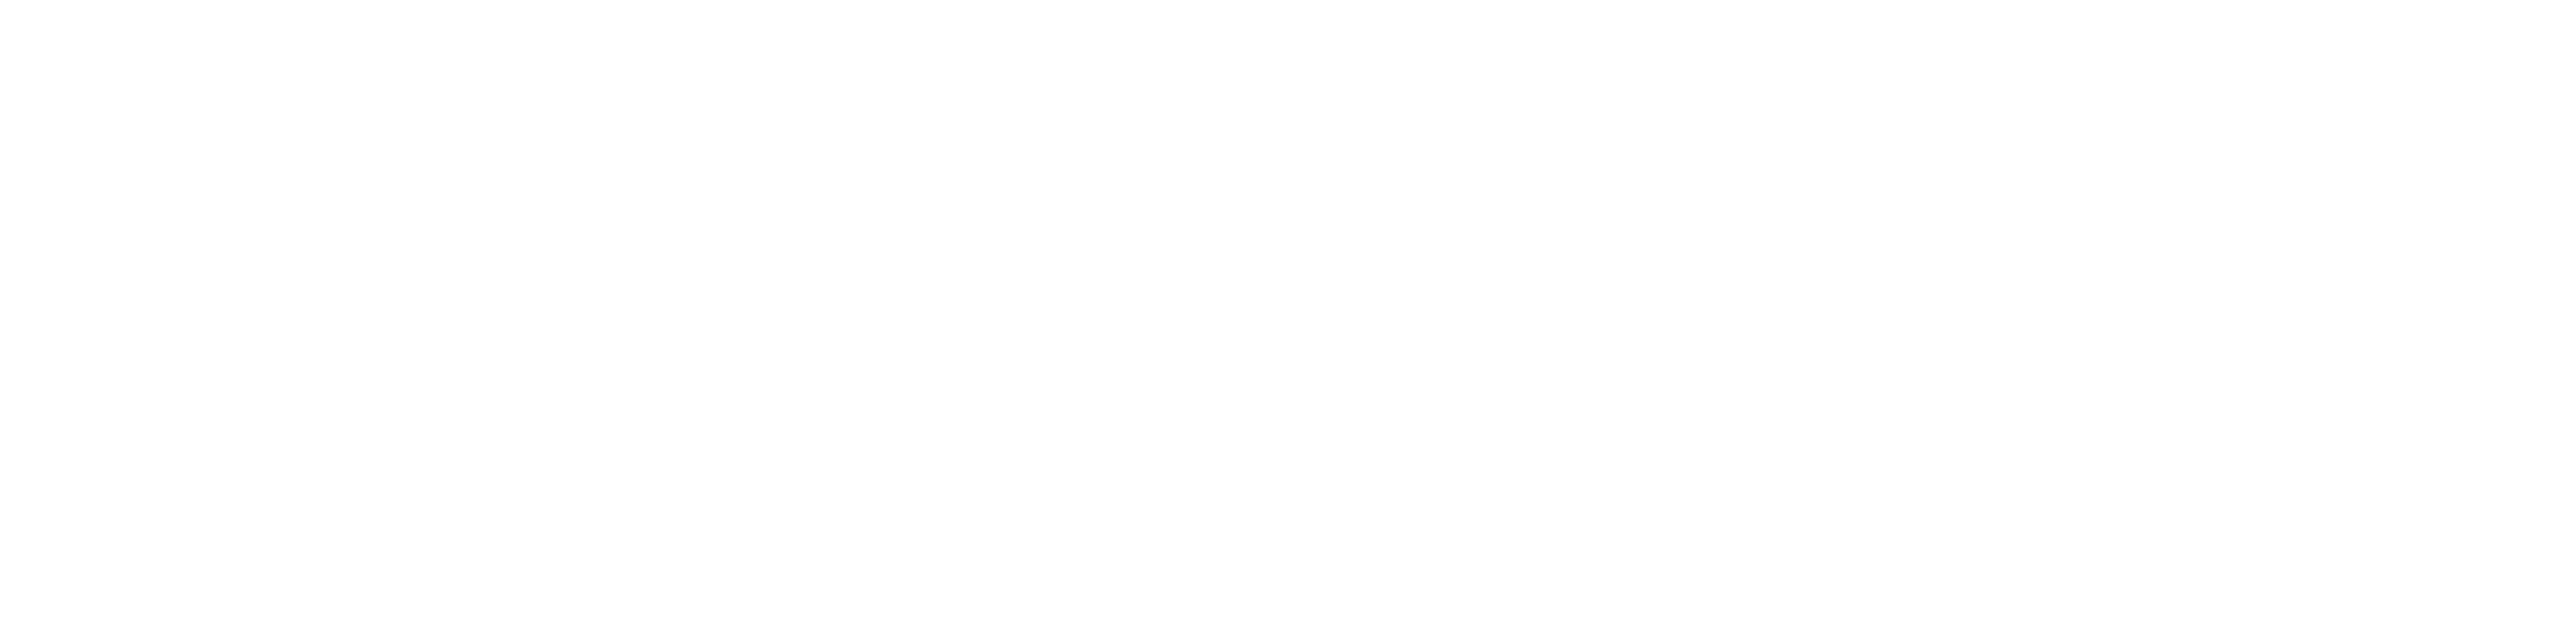

2020-06-10 14:59:39,512 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:59:45,775 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:59:52,017 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 14:59:58,313 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:00:04,818 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


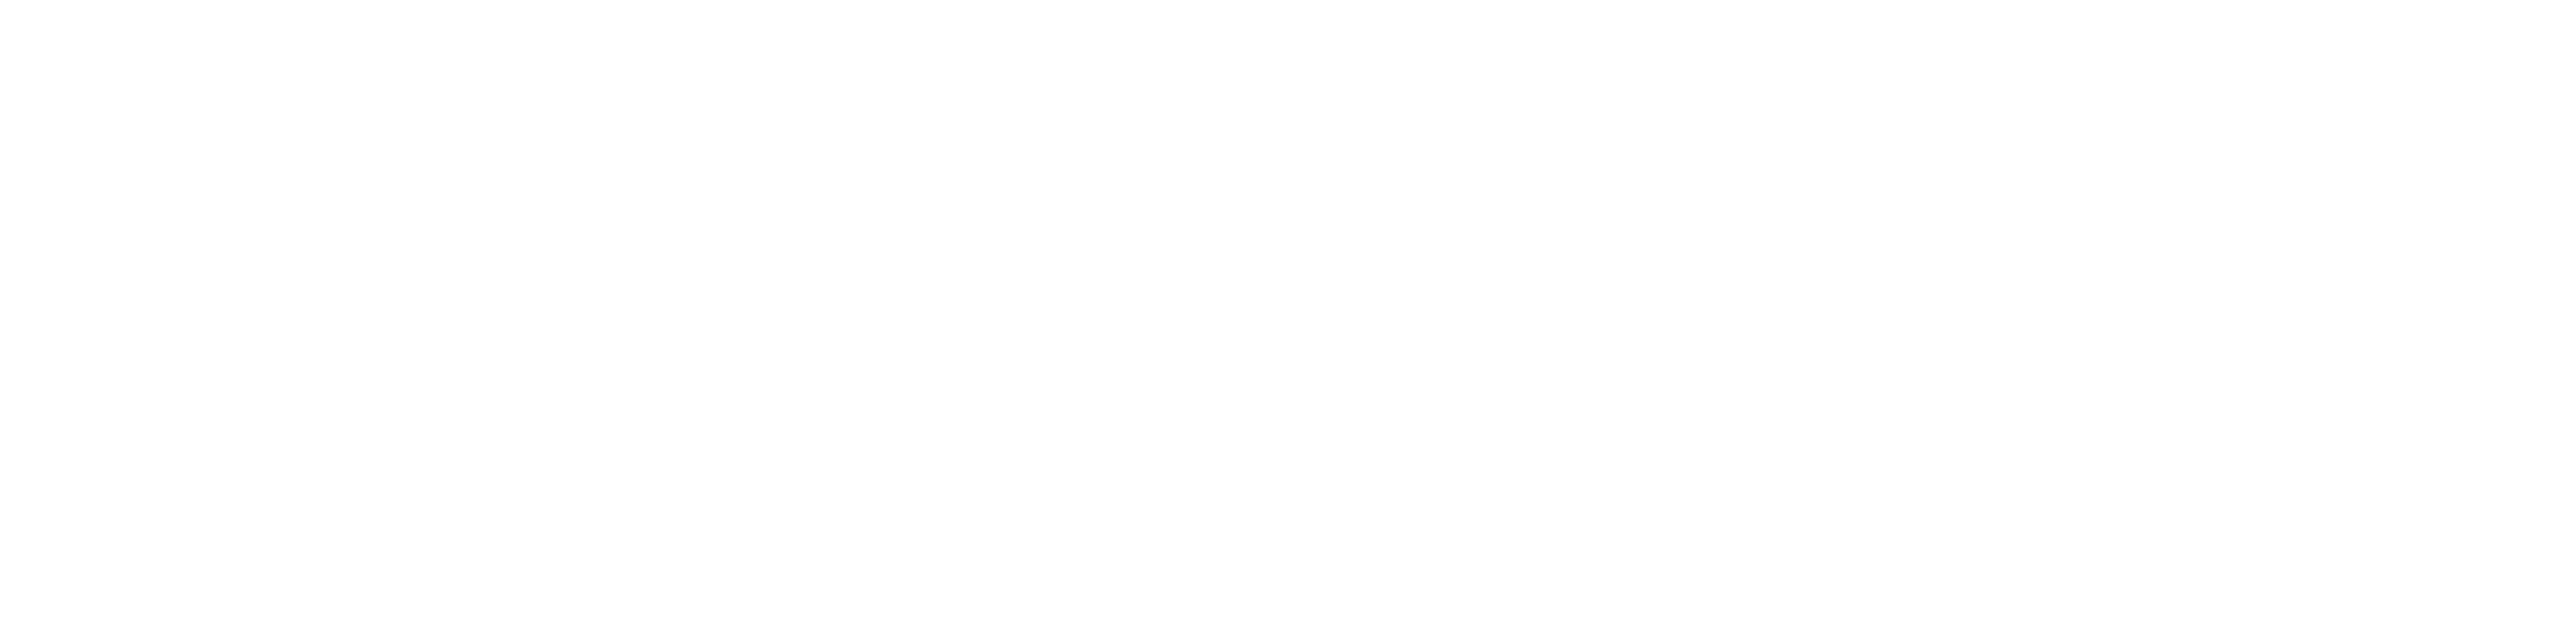

2020-06-10 15:00:29,384 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:00:35,648 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:00:41,954 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:00:48,397 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:00:54,823 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


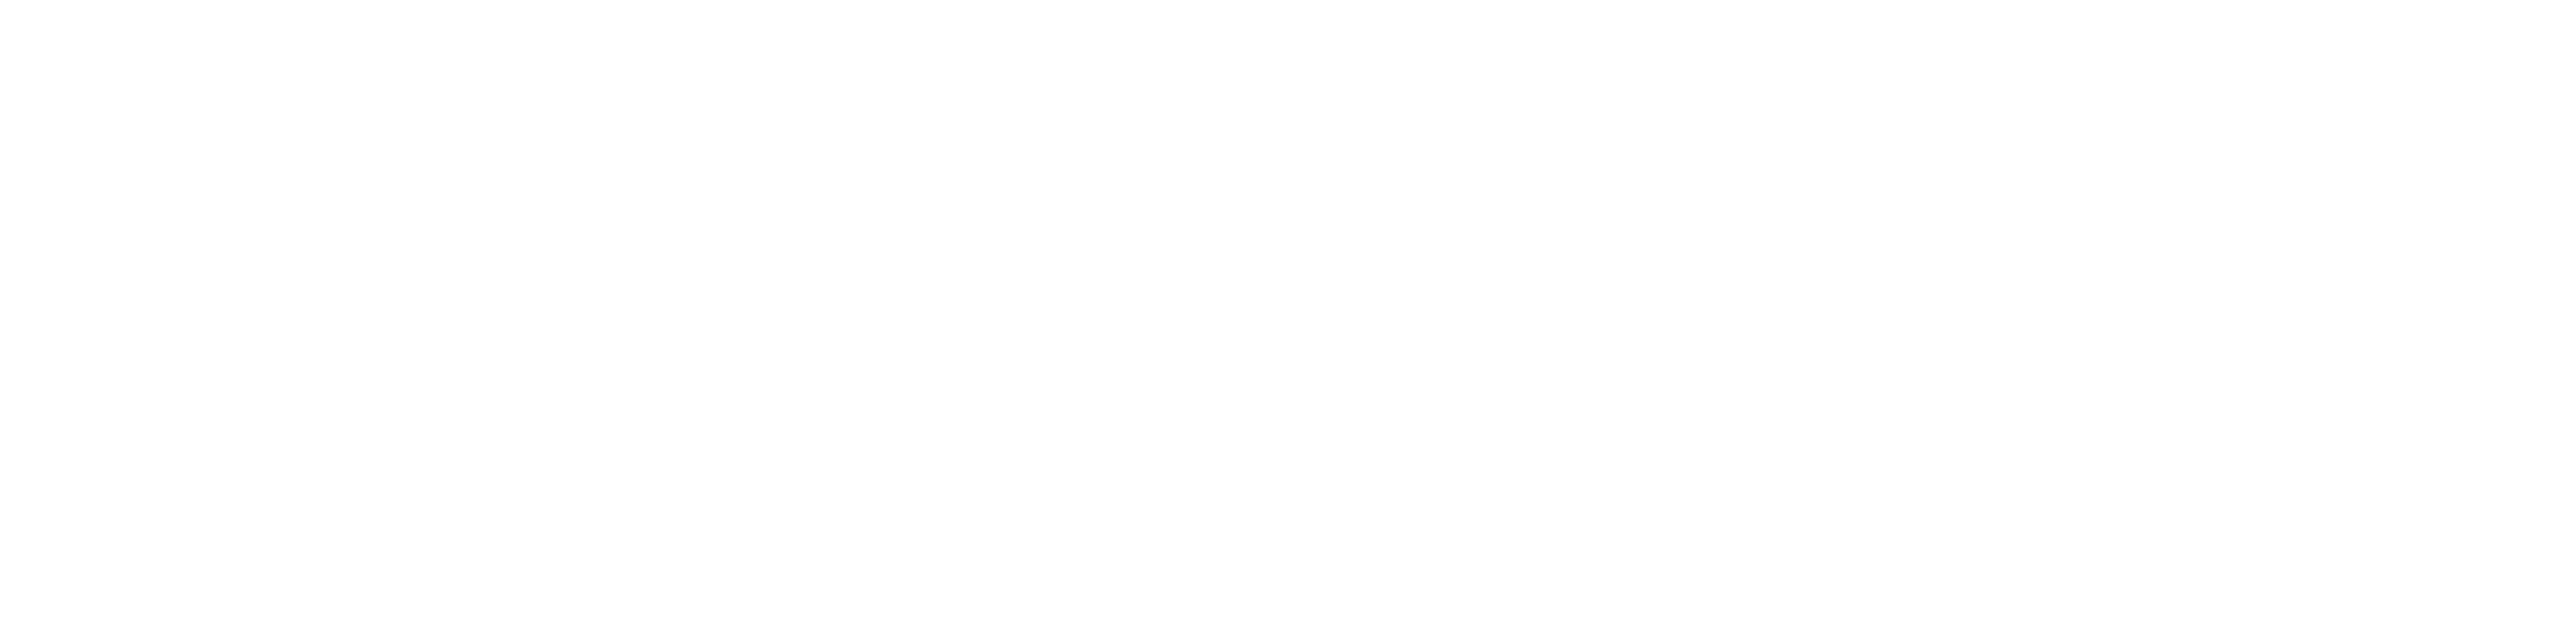

2020-06-10 15:01:19,222 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:01:25,654 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:01:32,078 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:01:38,443 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:01:44,836 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


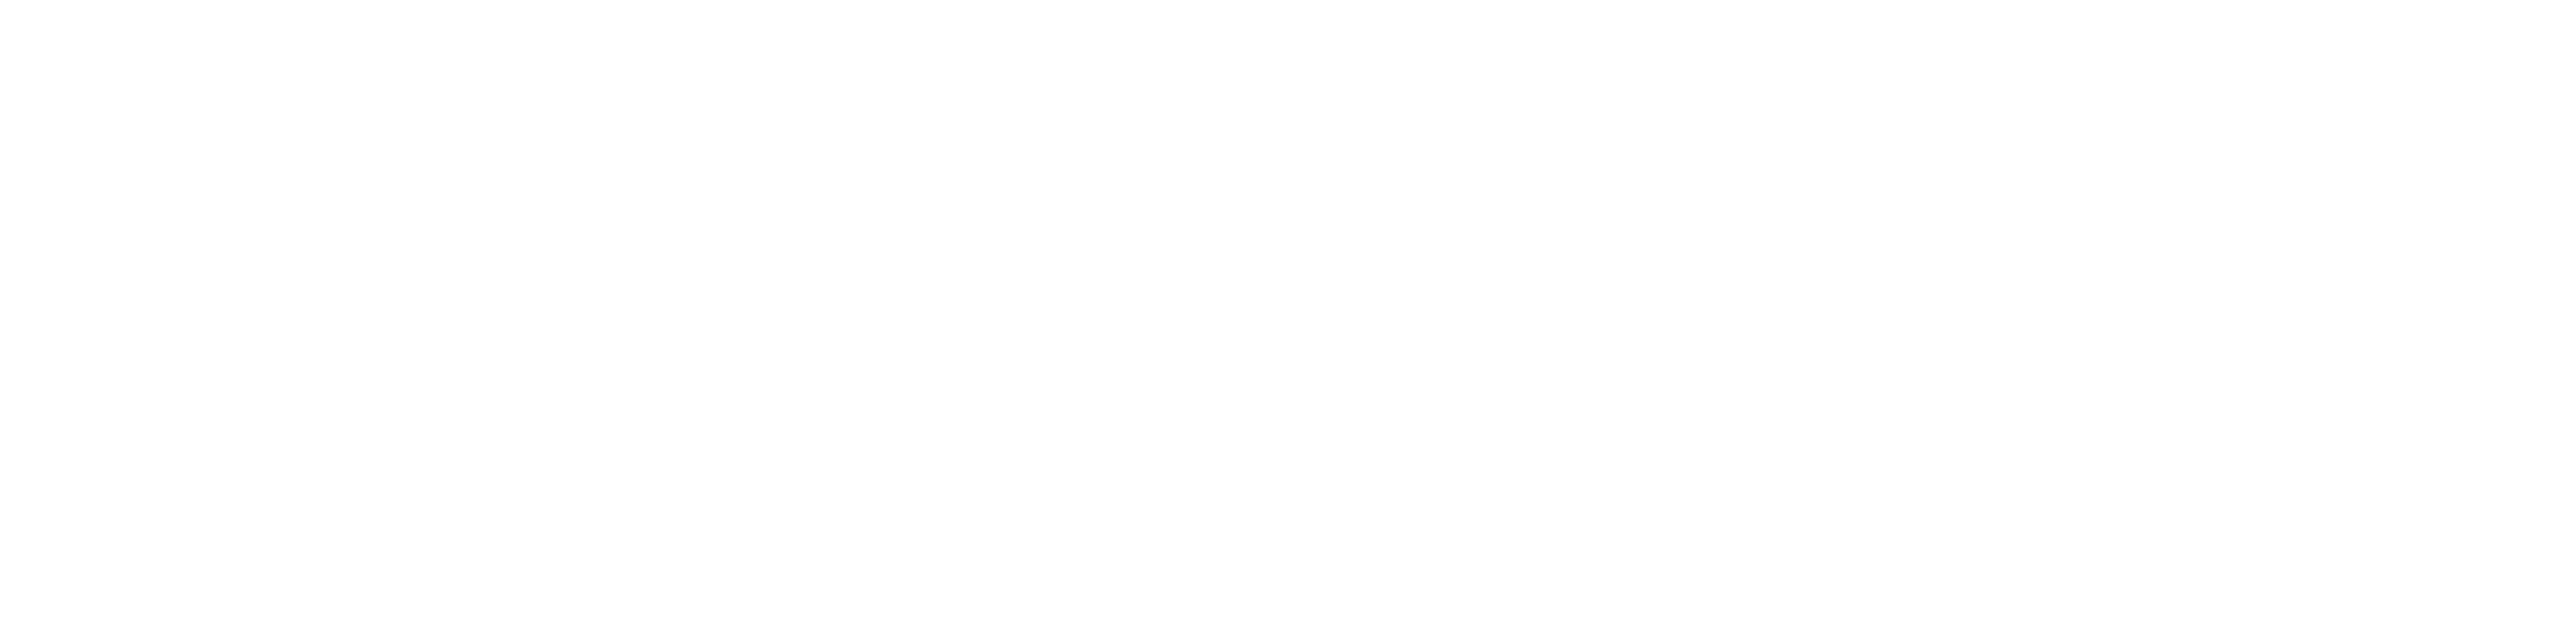

2020-06-10 15:02:09,333 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:02:16,242 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:02:22,978 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:02:29,245 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:02:35,636 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


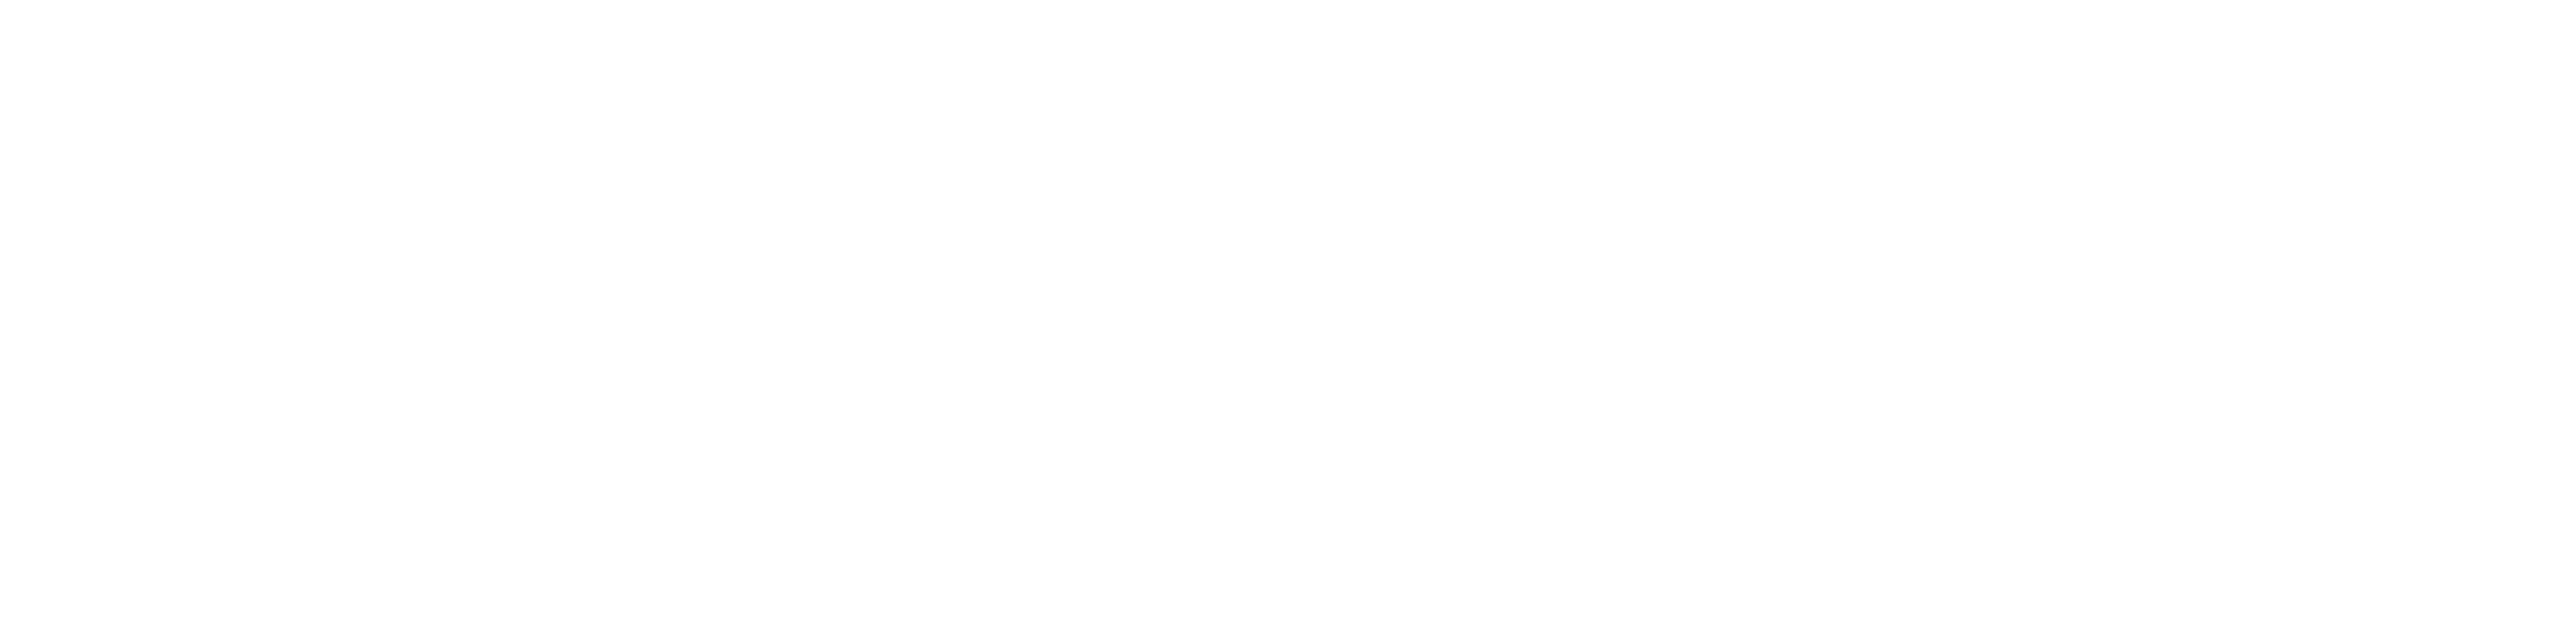

2020-06-10 15:02:59,924 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:03:06,169 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:03:12,439 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:03:18,818 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:03:25,154 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


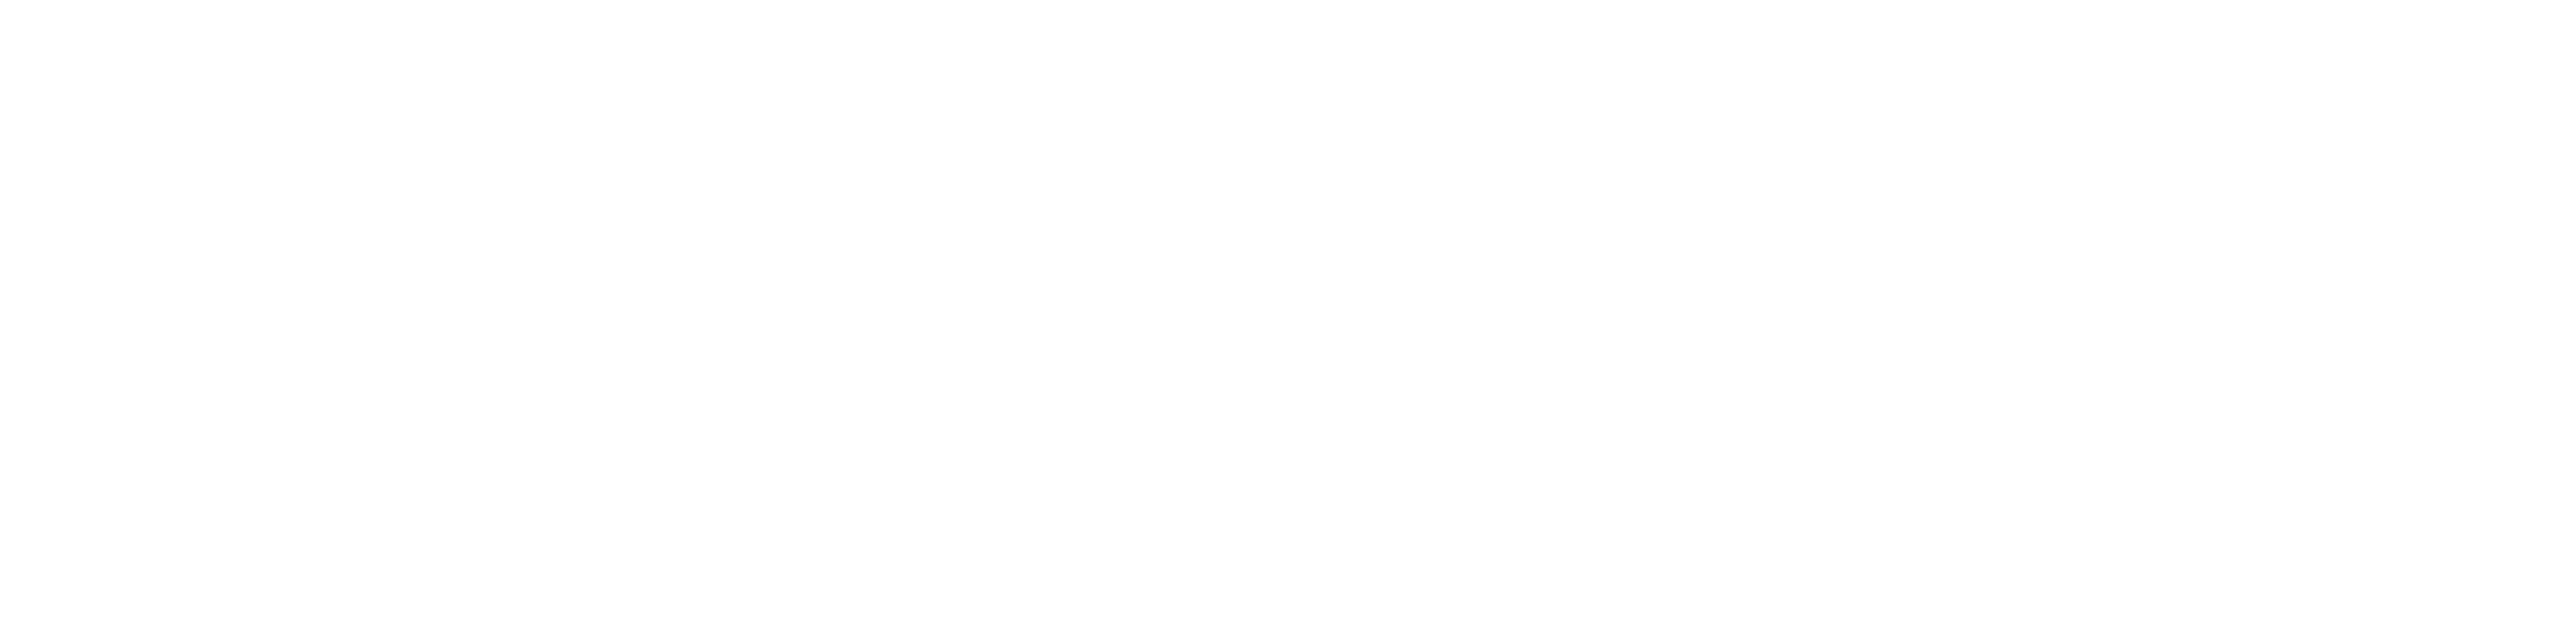

2020-06-10 15:03:49,567 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:03:55,830 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:04:02,069 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:04:08,551 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:04:15,070 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


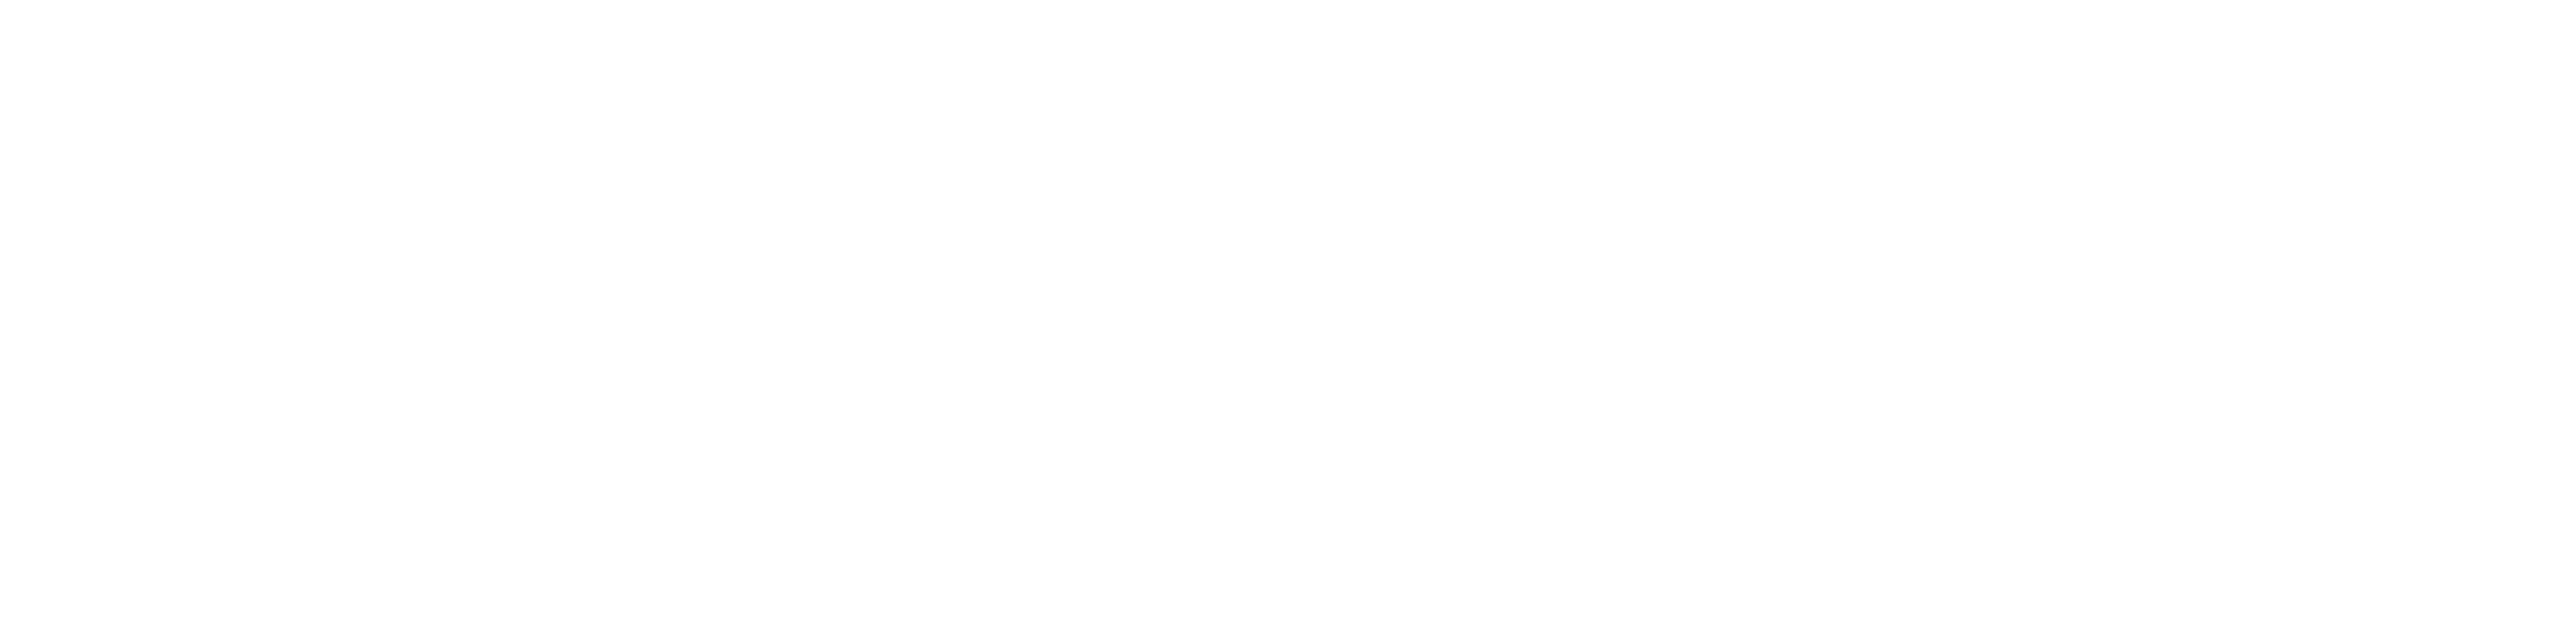

2020-06-10 15:04:39,676 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:04:45,922 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:04:52,309 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:04:58,749 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:05:05,137 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


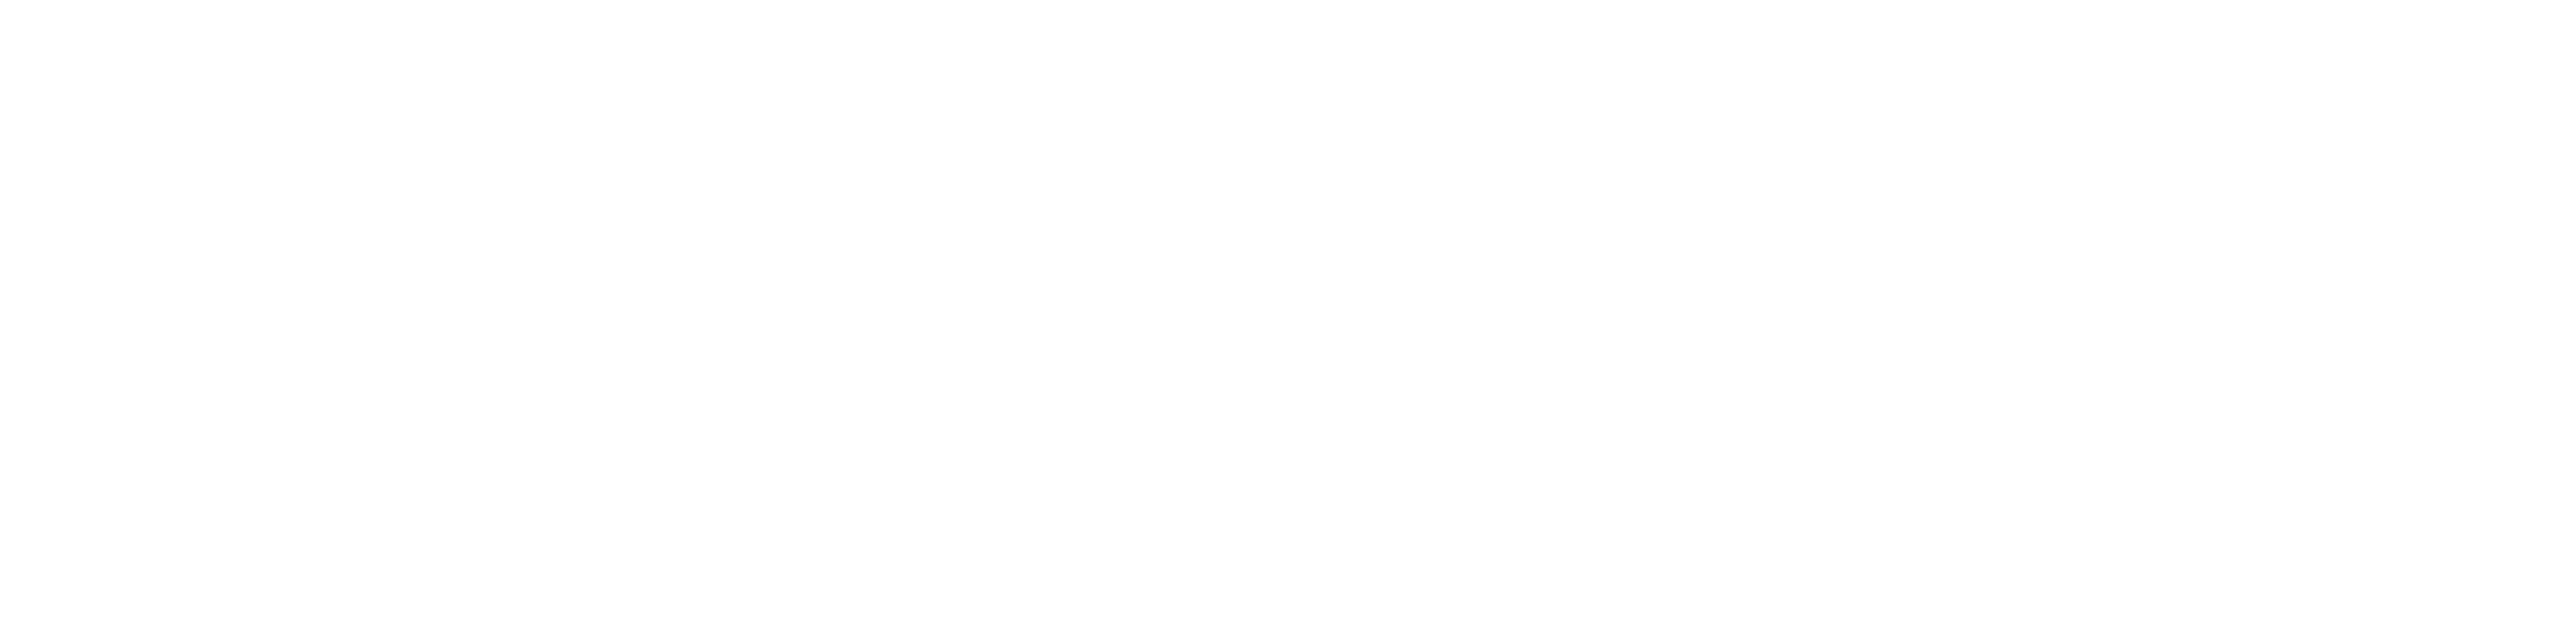

2020-06-10 15:05:29,492 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:05:35,907 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:05:42,254 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:05:48,672 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:05:55,245 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


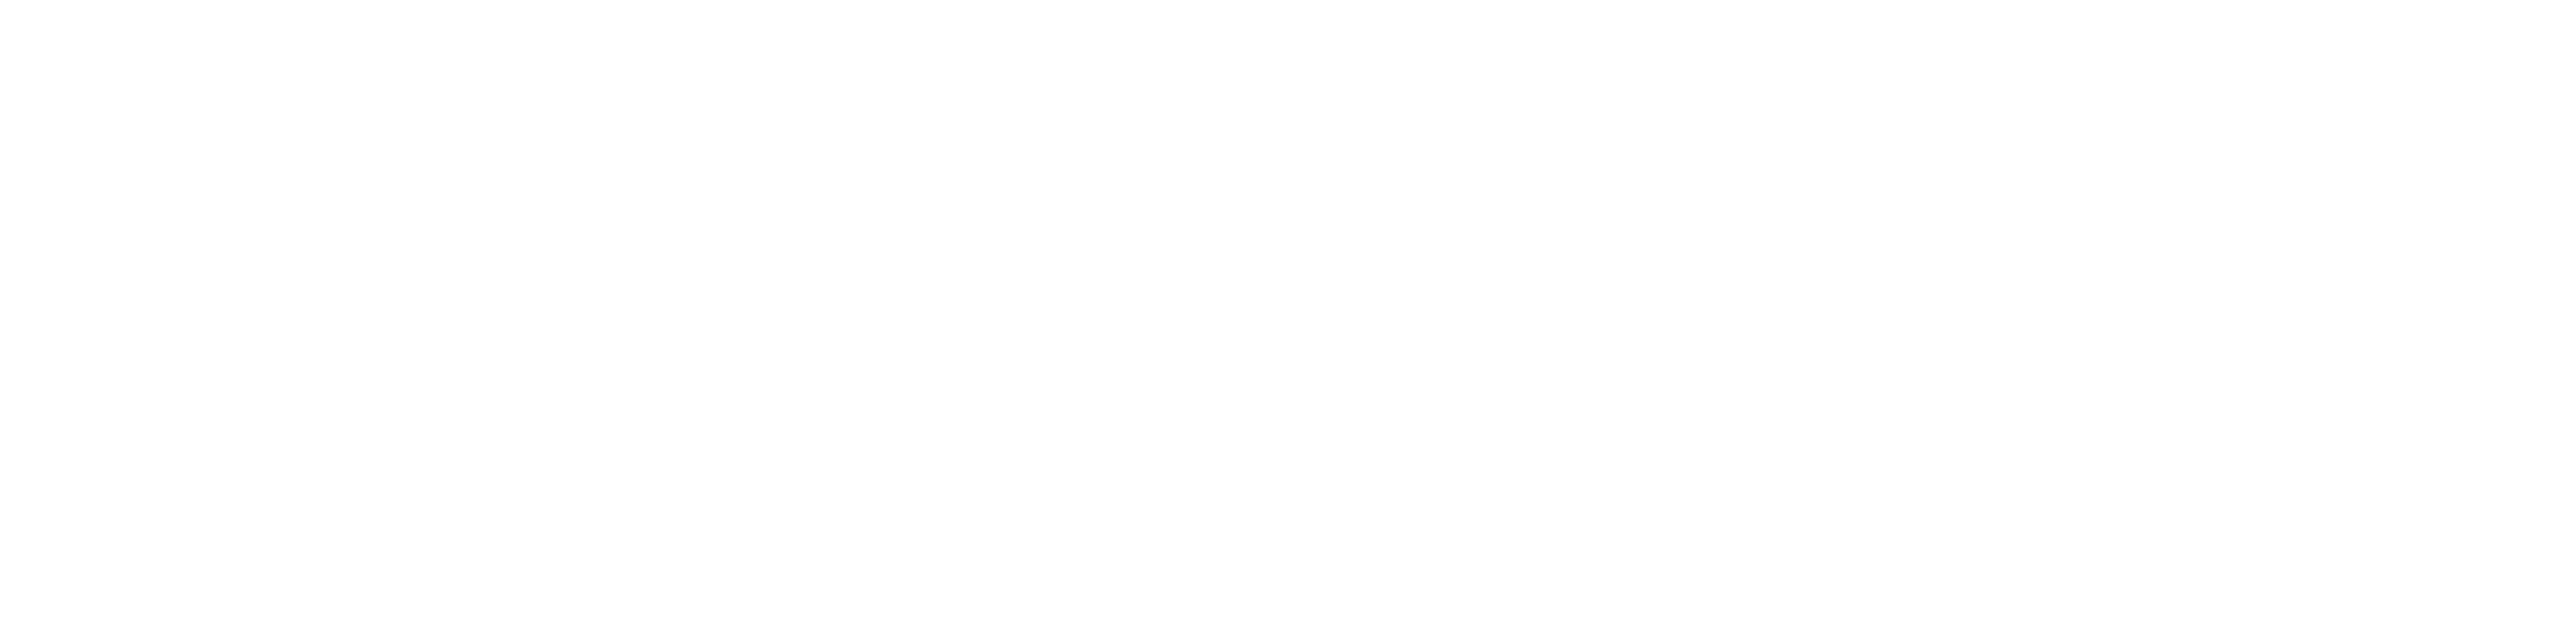

2020-06-10 15:06:19,640 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:06:25,786 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:06:31,990 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:06:38,308 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:06:44,620 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>


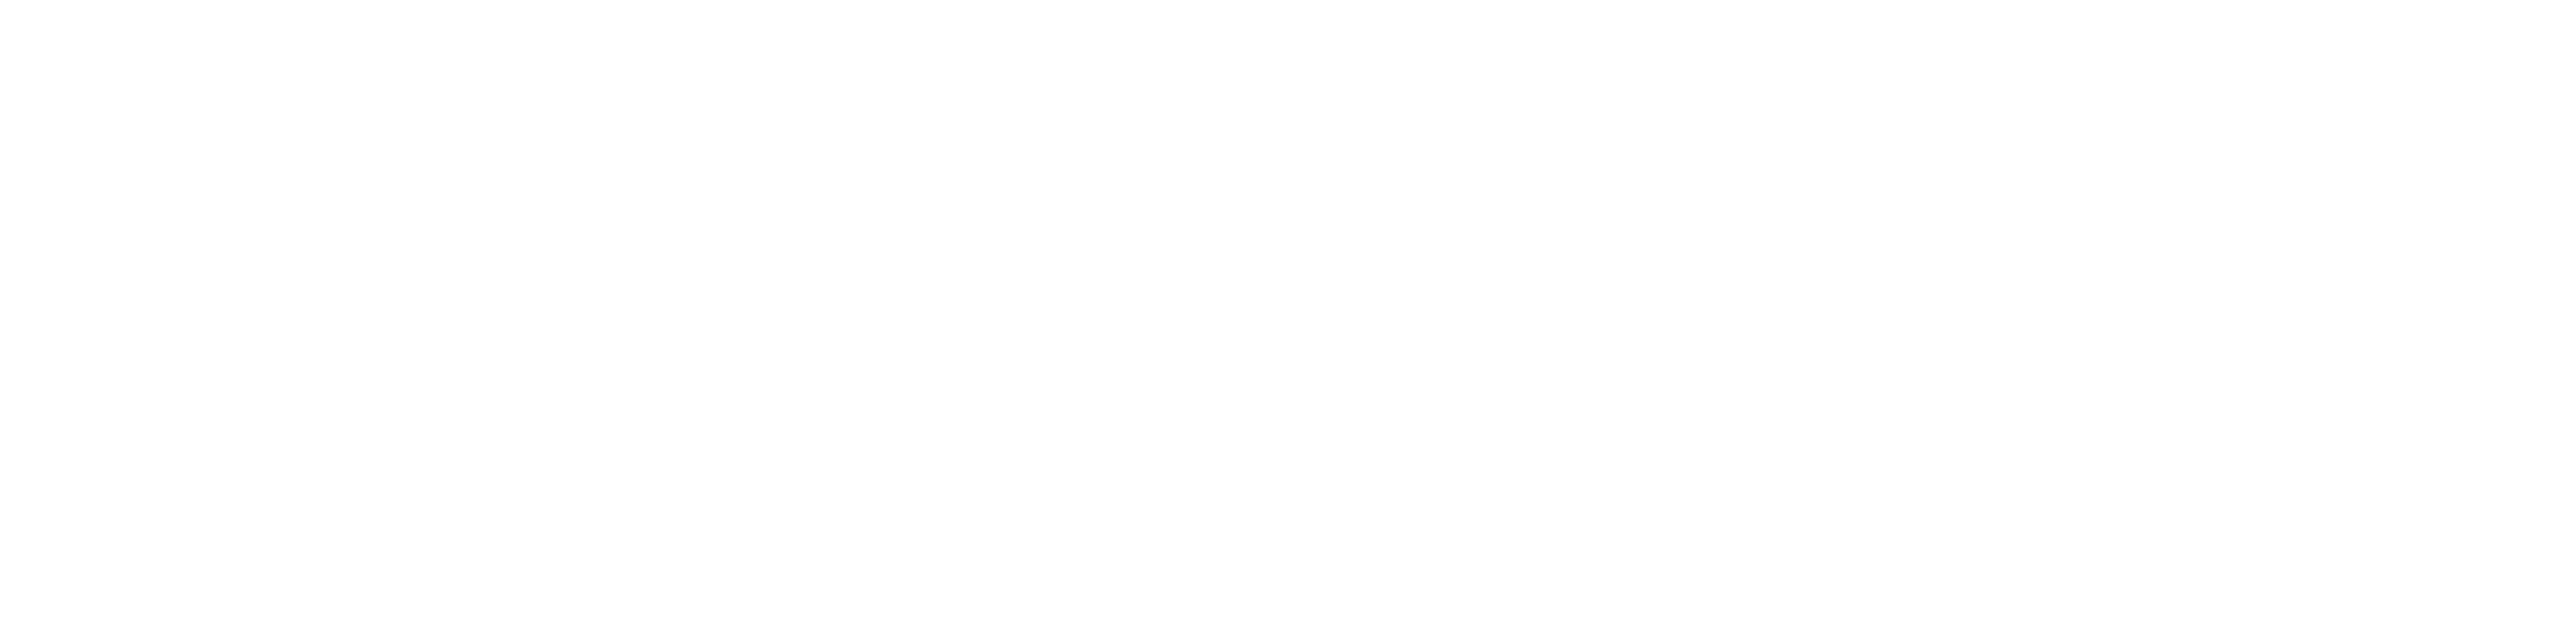

2020-06-10 15:07:08,744 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:07:14,911 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:07:21,032 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:07:27,223 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:07:33,328 logger INFO loss 1.26, MemUsed:231.75
Before release: active_bytes.all.current: 231.74656 MB
After release: active_bytes.all.current: 231.74656 MB


<IPython.core.display.Javascript object>

2020-06-10 15:07:57,442 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:08:03,669 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:08:09,826 logger INFO loss 1.26, MemUsed:231.75
2020-06-10 15:08:15,920 logger INFO loss 1.26, MemUsed:231.75


In [ ]:
cfg.numIterations = 300
loop = tqdm_notebook(range(cfg.numIterations))
# saveVTK(join(outFolderMesh, 'Target.vtk'), modifiedVertsRef.cpu().detach().numpy(), smplshExampleMesh)
for i in loop:
    optimizer.zero_grad()
#     torch.cuda.empty_cache()

    lossVal = 0
    for iCam in range(cfg.numCams):
        # refImg = torch.tensor(imagesRef[iCam][..., 3], dtype=torch.float64, device=device, requires_grad=False)
        refImg = torch.tensor(imagesRef[iCam], dtype=torch.float64, device=device, requires_grad=False)

        modifiedVerts = verts + xyzShift
        mesh = Meshes(
                verts=[modifiedVerts],   
                faces=[faces_idx], 
#                 textures=textures.to(device)
            )
        
        images = renderSynth.renderer(mesh, cameras=cams[iCam])
#         print(images.requires_grad)
#         print(modifiedVerts.requires_grad)
        loss = 1 - torch.norm(refImg * images[0, ..., 3], p=1) / torch.norm(refImg + images[0, ..., 3] - refImg * images[0, ..., 3], p=1)
        
        loss.backward()
        lossVal += loss.item()
        #showCudaMemUsage(device)
    
    modifiedVerts = verts + xyzShift
    mesh = Meshes(
                verts=[modifiedVerts],   
                faces=[faces_idx], 
#                 textures=textures.to(device)
            )
    
#     loss = cfg.lpSmootherW * mesh_laplacian_smoothing(mesh) + cfg.normalSmootherW * mesh_normal_consistency(mesh)
    loss = cfg.normalSmootherW * mesh_normal_consistency(mesh)
    normalSmootherVal = loss.item()
    loss = loss + cfg.lpSmootherW * xyzShift[:,0:1].transpose(0,1) @ LNP @ xyzShift[:,0:1]
    loss = loss + cfg.lpSmootherW * xyzShift[:,1:2].transpose(0,1) @ LNP @ xyzShift[:,1:2]
    loss = loss + cfg.lpSmootherW * xyzShift[:,2:3].transpose(0,1) @ LNP @ xyzShift[:,2:3]
    lpSmootherVal = loss.item() - normalSmootherVal
    
    loss.backward()
    lossVal += loss.item()
    
    loss = torch.sum(xyzShift[indicesToFix, :]**2)
    loss.backward()

    # targetImg = images[0, ..., :3]
    # loss, _ = model()
    
    # recordData
    losses.append(lossVal)
    
    optimizer.step()
    memStats = torch.cuda.memory_stats(device=device)
    memAllocated =  memStats['active_bytes.all.current'] / 1000000
    torch.cuda.empty_cache()

#     dis3D = modifiedVerts.cpu().detach().numpy() - modifiedVertsRef.cpu().numpy()
#     dis3D = np.mean(np.sqrt(dis3D[:,0]**2 + dis3D[:,1]**2 + dis3D[:,2]**2))
    
    infoStr = 'Fitting loss %.2f, normal regularizer loss %.6f, Laplacian regularizer loss %.6f, MemUsed:%.2f' \
        % (lossVal, normalSmootherVal, lpSmootherVal, memAllocated)
    
    loop.set_description(infoStr)
    logger.info(infoStr)
    
    #if lossVal < cfg.terminateLoss:
    #    break
    
    # Save outputs to create a GIF. 
    if i % cfg.plotStep == 0:
        showCudaMemUsage(device)
        modifiedVerts = verts + xyzShift
        mesh = Meshes(
                verts=[modifiedVerts],   
                faces=[faces_idx], 
#                 textures=textures.to(device)
            )
        
        torch.cuda.empty_cache()
        plt.close('all')
        
        outImgFile = join(outFolderForExperiment, 'Fig_' + str(i).zfill(5) + '.png')
        diffImages = []
        with torch.no_grad():
            for iCam in range(len(cams)):
                image_cur = renderSynth.renderer(mesh,  cameras=cams[iCam])
#                 images.append(image_cur.cpu().detach().numpy())
                imgDiff = np.abs(image_cur.cpu().detach().numpy()[0, ..., 3] - imagesRef[iCam])
                diffImages.append(imgDiff)
                torch.cuda.empty_cache()

#             showCudaMemUsage(device)
        visualize2DResults(diffImages, outImgFile=outImgFile, sizeInInches=5, pytorch3DImg=False)
        
        saveVTK(join(outFolderMesh, 'Fit' + str(i).zfill(5) + '.vtk'), modifiedVerts.cpu().detach().numpy(), smplshExampleMesh)


In [ ]:
saveVTK(join(outFolderForExperiment, 'FinalMesh.ply'), modifiedVerts.cpu().detach().numpy(), smplshExampleMesh)

In [ ]:
def visualize2DSilhouetteResults(images, backGroundImages=None, outImgFile=None, rows = 2, pytorch3DImg=True, sizeInInches = 2):
    lossVal = 0
    numCams = len(images)
    numCols = int(numCams / rows)
    fig, axs = plt.subplots(rows, numCols)
    fig.set_size_inches(numCols*sizeInInches, rows*sizeInInches)
    with torch.no_grad():
        for iRow in range(rows):
            for iCol in range(numCols):
                iCam = rows* iRow + iCol
                imgAlpha = images[iCam][0,...,3]
                    
                if backGroundImages is not None:
                    img = np.copy(backGroundImages[iCam]) * 0.5
#                     fgMask = np.logical_not(np.where())
#                     for iChannel in range(3):
                    img[..., 0] = img[..., 0] + imgAlpha * 0.5
                    imgAlpha = img
                    
                imgAlpha = cv2.flip(imgAlpha, -1)
                
                axs[iRow, iCol].imshow(imgAlpha, vmin=0.0, vmax=1.0)
                axs[iRow, iCol].axis('off')

        if outImgFile is not None:
            fig.savefig(outImgFile, dpi=512, transparent=True, bbox_inches='tight', pad_inches=0)

In [ ]:
images = []
outImgFile = join(outFolderForExperiment, 'FinalImage.png')
with torch.no_grad():
    for iCam in range(len(cams)):
        image_cur = renderSynth.renderer(mesh,  cameras=cams[iCam])
        images.append(image_cur.cpu().detach().numpy())

visualize2DSilhouetteResults(images, backGroundImages = crops_out, outImgFile=outImgFile, sizeInInches=5)

In [ ]:
diffImages[0].shape

In [ ]:
np.max(diffImages[0])

In [ ]:
if True:
    showCudaMemUsage(device)
    modifiedVerts = verts + xyzShift
    mesh = Meshes(
            verts=[modifiedVerts],   
            faces=[faces_idx], 
        )
    
    torch.cuda.empty_cache()
    plt.close('all')
    
    outImgFile = join(outFolderForExperiment, 'Fig_' + str(0).zfill(5) + '.png')
    diffImages = []
    with torch.no_grad():
        for iCam in range(len(cams)):
            image_cur = renderSynth.renderer(mesh,  cameras=cams[iCam])
            imgDiff =  np.abs(image_cur.cpu().detach().numpy() - imagesRef[iCam])
            diffImages.append(imgDiff)
    visualize2DResults(diffImages, outImgFile=outImgFile, sizeInInches=5)
    
    saveVTK(join(outFolderMesh, 'Fit' + str(0).zfill(5) + '.vtk'), modifiedVerts.cpu().detach().numpy(), smplshExampleMesh)